In [1]:
%pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 KB 7.8 MB/s eta 0:00:008.6 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 3.9 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 23.9 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 KB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 45.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 25.8 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 35.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 KB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 KB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 26.9 MB/s eta 

In [4]:
# Creating reusable training function

""" Testing on Training Set"""
import glob
import math
from ultralytics import YOLO
import time
import shutil
import os

# Returns model and the time it took to load the model
def load_model(model_name='yolov8x.pt'):
    start_time = time.perf_counter()
    model = YOLO(model_name)
    end_time = time.perf_counter()
    return model, end_time - start_time

# Returns trained model, results of training, and time to train the model
def train_model(model, yaml_filename, epochs=100, batch=4, patience=50, save_period=-1):
    start_time = time.perf_counter()
    results = model.train(data=yaml_filename, epochs=epochs, imgsz=640, device=[0], patience=patience, batch=batch, save_period=save_period)
    end_time = time.perf_counter()
    model.export()
    return model, results, end_time - start_time

# Returns # images fully labeled correct, # images, # lights identified correct, # lights, time to predict all images
def predict_images(model, input_im_path, output_im_path, print_scores=False, verbose=False):
    start_time = time.perf_counter()

    # Loading images
    test_images = glob.glob(f"{input_im_path}/images/*")

    # For calculating accuracy
    light_all = 0 
    image_all = 0
    light_correct = 0
    image_correct = 0
    
    for image in test_images:
    
        # Updating image counts
        image_all += 1
    
        # Making prediction
        prediction = model(image, save=True, boxes=True, save_conf=True, imgsz=320, project=output_im_path, verbose=verbose)
        coords = prediction[0].boxes.xywh
    
        # Reading from corresponding text file
        real_objects = []
        with open(f"{input_im_path}/labels/{image.split('/')[-1][:-4]}.txt", 'r') as f:
            for line in f:
                if line == "\n": continue
                vals = line.split(' ')
                # print(vals)
                real_objects.append( ( float(vals[1]), float(vals[2]), float(vals[3]), float(vals[4]) ) )
                light_all += 1
    
        # Determining how many images match
        no_errors = True
        for c in coords:
            this_x = float(c[0])
            this_y = float(c[1])
            this_w = float(c[2])
            this_h = float(c[3])

            # Checking each predicted box against each row of the true data
            this_coord_match = False
            for line in real_objects:
                if abs(this_x / 1280 - line[0]) <= 0.05 and abs(this_y / 960 - line[1]) <= 0.05 and abs(this_w / 1280 - line[2]) <= 0.05 and abs(this_h / 960 - line[3]) <= 0.05:
                    light_correct += 1
                    real_objects.remove(line)
                    if real_objects == None: real_objects = []
                    this_coord_match = True
                    break
    
            if not this_coord_match: no_errors = False
    
        if no_errors and len(real_objects): image_correct += 1

    # Moving all prediction images into one folder
    all_folders = glob.glob(f"{output_im_path}/*")
    for f in all_folders:
        these_files = glob.glob(f"{f}/*")
        if len(these_files) > 0:
            # print(these_files[0].split('/')[-1])
            
            shutil.copy(these_files[0], f"{output_im_path}/{these_files[0].split('/')[-1]}") # Copying over file
            os.remove(these_files[0])
            os.rmdir(f)

    end_time = time.perf_counter()
    if print_scores:
        print(f"Image accuracy: {image_correct} / {image_all}")
        print(f"Light accuracy: {light_correct} / {light_all}")

    return image_correct, image_all, light_correct, light_all, end_time - start_time
        

In [35]:
## Loading and predicting with untrained models
m, load_time = load_model()

ic, ia, lc, la, predict_time = predict_images(m, "YOLO_data/DatasetComp_2000/train", "Dataset2000_Comp_UntrainedModel_Predictions")

print(f"Image accuracy: {ic} / {ia}")
print(f"Light accuracy: {lc} / {la}")

print(f"Load time: {load_time} seconds.")
print(f"Predict time: {predict_time} seconds.")

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict2
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict3
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict4
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict5


['2', '0.621875', '0.32083333333333336', '0.0125', '0.028125\n']
['2', '0.69765625', '0.365625', '0.0109375', '0.028125\n']
['2', '0.7796875', '0.03958333333333333', '0.04609375', '0.07916666666666666\n']
['2', '0.56328125', '0.36041666666666666', '0.0109375', '0.021875\n']
['2', '0.64375', '0.403125', '0.0140625', '0.021875\n']
['2', '0.40390625', '0.37916666666666665', '0.00546875', '0.0125\n']
['2', '0.54375', '0.3385416666666667', '0.009375', '0.01875\n']
['2', '0.609375', '0.37395833333333334', '0.00703125', '0.015625\n']
['2', '0.9265625', '0.21354166666666666', '0.0390625', '0.0875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict6
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict7
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict8
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict9


['2', '0.52734375', '0.340625', '0.0125', '0.021875\n']
['2', '0.5640625', '0.34375', '0.009375', '0.025\n']
['2', '0.6296875', '0.37395833333333334', '0.01484375', '0.0375\n']
['2', '0.871875', '0.140625', '0.021875', '0.075\n']
['3', '0.67421875', '0.13541666666666666', '0.0359375', '0.078125\n']
['2', '0.04921875', '0.35104166666666664', '0.009375', '0.03125\n']
['2', '0.4265625', '0.3625', '0.009375', '0.025\n']
['2', '0.4640625', '0.23333333333333334', '0.01796875', '0.040625\n']
['2', '0.5765625', '0.3416666666666667', '0.01640625', '0.034375\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict10
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict11
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict12
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict13
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict14


['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['4', '0.5546875', '0.328125', '0.01015625', '0.03125\n']
['4', '0.6125', '0.3572916666666667', '0.0140625', '0.026041666666666668\n']
['2', '0.5109375', '0.26458333333333334', '0.01796875', '0.034375\n']
['2', '0.60625', '0.35208333333333336', '0.01640625', '0.03125\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.5328125', '0.38645833333333335', '0.01171875', '0.03125\n']
['2', '0.63828125', '0.42604166666666665', '0.0140625', '0.036458333333333336\n']
['0', '0.7359375', '0.19166666666666668', '0.04453125', '0.10729166666666666\n']
['0', '0.89921875', '0.24166666666666667', '0.0375', '0.10729166666666666\n']
['1'

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict15
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict16
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict17
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict18


['0', '0.615625', '0.065625', '0.04765625', '0.09791666666666667\n']
['0', '0.946875', '0.24479166666666666', '0.04765625', '0.10104166666666667\n']
['2', '0.69609375', '0.396875', '0.009375', '0.01875\n']
['2', '0.91015625', '0.3489583333333333', '0.01796875', '0.0375\n']
['2', '0.984375', '0.4010416666666667', '0.01953125', '0.04375\n']
['3', '0.96015625', '0.022916666666666665', '0.04921875', '0.046875\n']
['2', '0.5171875', '0.32395833333333335', '0.0125', '0.021875\n']
['2', '0.56015625', '0.32708333333333334', '0.0109375', '0.01875\n']
['2', '0.6375', '0.3645833333333333', '0.0078125', '0.025\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict19
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict20
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict21
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict22


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['4', '0.52109375', '0.3625', '0.01171875', '0.028125\n']
['2', '0.53671875', '0.37916666666666665', '0.00546875', '0.0125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict23
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict24
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict25
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict26
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict27


['0', '0.56015625', '0.2916666666666667', '0.028125', '0.065625\n']
['0', '0.2921875', '0.15625', '0.01875', '0.0375\n']
['2', '0.51875', '0.32916666666666666', '0.0140625', '0.025\n']
['2', '0.23515625', '0.384375', '0.00546875', '0.015625\n']
['2', '0.621875', '0.3729166666666667', '0.01484375', '0.034375\n']
['0', '0.54375', '0.32708333333333334', '0.01484375', '0.03854166666666667\n']
['0', '0.6078125', '0.36666666666666664', '0.01015625', '0.030208333333333334\n']
['2', '0.053125', '0.35104166666666664', '0.0078125', '0.03125\n']
['2', '0.4265625', '0.3614583333333333', '0.0078125', '0.021875\n']
['2', '0.4640625', '0.23645833333333333', '0.01640625', '0.0375\n']
['2', '0.575', '0.34375', '0.01640625', '0.03125\n']
['2', '0.63125', '0.19583333333333333', '0.0265625', '0.06875\n']
['2', '0.78203125', '0.20520833333333333', '0.01953125', '0.04375\n']
['2', '0.0390625', '0.24583333333333332', '0.0390625', '0.090625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict28
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict29
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict30
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict31


['2', '0.9140625', '0.14895833333333333', '0.028125', '0.078125\n']
['3', '0.6984375', '0.14270833333333333', '0.028125', '0.071875\n']
['2', '0.55703125', '0.33958333333333335', '0.00703125', '0.015625\n']
['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.0640625', '0.275', '0.02109375', '0.041666666666666664\n']
['1', '0.61953125', '0.14583333333333334', '0.021875', '0.04479166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict32
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict33
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict34
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict35


['0', '0.4984375', '0.08125', '0.0375', '0.075\n']
['0', '0.7734375', '0.26458333333333334', '0.046875', '0.103125\n']
['2', '0.44375', '0.365625', '0.0078125', '0.021875\n']
['2', '0.60390625', '0.33125', '0.0109375', '0.01875\n']
['2', '0.65625', '0.36770833333333336', '0.009375', '0.028125\n']
['0', '0.6859375', '0.23958333333333334', '0.02578125', '0.06979166666666667\n']
['0', '0.840625', '0.334375', '0.01640625', '0.053125\n']
['1', '0.17421875', '0.3125', '0.00703125', '0.021875\n']
['1', '0.584375', '0.23020833333333332', '0.01640625', '0.03854166666666667\n']
['0', '0.03671875', '0.2635416666666667', '0.02578125', '0.046875\n']
['0', '0.49921875', '0.10833333333333334', '0.0375', '0.06979166666666667\n']
['0', '0.74609375', '0.275', '0.0421875', '0.103125\n']
['0', '0.71796875', '0.20625', '0.02109375', '0.0375\n']
['0', '0.8734375', '0.25729166666666664', '0.0234375', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict36
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict37
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict38
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict39
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict40


['2', '0.30703125', '0.34375', '0.00703125', '0.028125\n']
['2', '0.55625', '0.3072916666666667', '0.0140625', '0.03125\n']
['2', '0.5984375', '0.3125', '0.0140625', '0.028125\n']
['2', '0.69296875', '0.35833333333333334', '0.01640625', '0.034375\n']
['2', '0.57890625', '0.35833333333333334', '0.00703125', '0.015625\n']
['2', '0.5984375', '0.36041666666666666', '0.00546875', '0.0125\n']
['0', '0.1921875', '0.303125', '0.028125', '0.06145833333333333\n']
['0', '0.5921875', '0.21354166666666666', '0.021875', '0.06145833333333333\n']
['0', '0.79375', '0.32708333333333334', '0.02578125', '0.06666666666666667\n']
['2', '0.696875', '0.26875', '0.01640625', '0.05\n']
['2', '0.78984375', '0.2708333333333333', '0.01953125', '0.040625\n']
['2', '0.35703125', '0.3177083333333333', '0.02109375', '0.053125\n']
['0', '0.775', '0.2', '0.021875', '0.06666666666666667\n']
['1', '0.628125', '0.18645833333333334', '0.01484375', '0.03854166666666667\n']
['0', '0.1421875', '0.3020833333333333', '0.02109375

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict41
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict42
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict43
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict44


['2', '0.01484375', '0.34270833333333334', '0.0125', '0.05\n']
['2', '0.48515625', '0.26145833333333335', '0.01953125', '0.040625\n']
['2', '0.65390625', '0.340625', '0.01484375', '0.040625\n']
['0', '0.51875', '0.3614583333333333', '0.009375', '0.01875\n']
['0', '0.37890625', '0.29791666666666666', '0.009375', '0.03229166666666667\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.259375', '0.03046875', '0.07291666666666667\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict45
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict46
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict47
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict48


['2', '0.5328125', '0.38645833333333335', '0.01171875', '0.026041666666666668\n']
['2', '0.6375', '0.42291666666666666', '0.02109375', '0.046875\n']
['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.66640625', '0.21875', '0.02109375', '0.05625\n']
['0', '0.7828125', '0.2520833333333333', '0.028125', '0.065625\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['2', '0.5625', '0.3614583333333333', '0.0109375', '0.015625\n']
['2', '0.628125', '0.39791666666666664', '0.00546875', '0.0125\n']
['0', '0.15625', '0.27291666666666664', '0.02109375', '0.041666666666666664\n']
['0', '0.2484375', '0.28125', '0.01875', '0.0375\n']
['0', '0.38046875', '0.3770833333333333', '0.0140625', '0.028125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict49
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict50
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict51
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict52
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict53


['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.1', '0.3854166666666667', '0.01640625', '0.041666666666666664\n']
['2', '0.471875', '0.26458333333333334', '0.01875', '0.026041666666666668\n']
['2', '0.65', '0.37395833333333334', '0.01640625', '0.03125\n']
['0', '0.51796875', '0.35833333333333334', '0.0078125', '0.028125\n']
['0', '0.57109375', '0.378125', '0.00546875', '0.013541666666666667\n']
['2', '0.48125', '0.30416666666666664', '0.0140625', '0.034375\n']
['2', '0.51953125', '0.3104166666666667', '0.0125', '0.03125\n']
['2', '0.60625', '0.35208333333333336', '0.0125', '0.028125\n']
['0', '0.49453125', '0.35', '0.01484375', '0.04166666666666666

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict54
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict55
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict56
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict57


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.259375', '0.03046875', '0.07291666666666667\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.30703125', '0.334375', '0.009375', '0.022916666666666665\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict58
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict59
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict60
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict61


['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.765625', '0.371875', '0.009375', '0.01875\n']
['2', '0.59296875', '0.38333333333333336', '0.00703125', '0.0125\n']
['2', '0.5328125', '0.3541666666666667', '0.009375', '0.025\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict62
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict63
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict64
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict65
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict66


['0', '0.68671875', '0.3385416666666667', '0.009375', '0.01875\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['0', '0.45625', '0.36666666666666664', '0.0125', '0.028125\n']
['0', '0.49453125', '0.3885416666666667', '0.01171875', '0.021875\n']
['2', '0.528125', '0.353125', '0.0078125', '0.021875\n']
['2', '0.56015625', '0.35625', '0.00703125', '0.0125\n']
['2', '0.41875', '0.3770833333333333', '0.00546875', '0.0125\n']
['2', '0.48984375', '0.33541666666666664', '0.0109375', '0.025\n']
['2', '0.52578125', '0.3385416666666667', '0.0125', '0.028125\n']
['2', '0.609375', '0.3802083333333333', '0.0078125', '0.025\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict67
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict68
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict69
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict70
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict71


['0', '0.51953125', '0.3541666666666667', '0.01015625', '0.028125\n']
['0', '0.57734375', '0.37916666666666665', '0.0078125', '0.021875\n']
['2', '0.07734375', '0.32708333333333334', '0.025', '0.0625\n']
['2', '0.5', '0.23229166666666667', '0.021875', '0.05\n']
['2', '0.66875', '0.32708333333333334', '0.021875', '0.04375\n']
['0', '0.80625', '0.17395833333333333', '0.02578125', '0.06979166666666667\n']
['1', '0.64375', '0.16041666666666668', '0.01640625', '0.03854166666666667\n']
['2', '0.53671875', '0.03333333333333333', '0.03359375', '0.06770833333333333\n']
['2', '0.96875', '0.2375', '0.0390625', '0.090625\n']
['2', '0.51640625', '0.3072916666666667', '0.01484375', '0.03125\n']
['2', '0.575', '0.3072916666666667', '0.0140625', '0.028125\n']
['2', '0.68125', '0.3572916666666667', '0.0140625', '0.034375\n']
['2', '0.2203125', '0.353125', '0.0078125', '0.03125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict72
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict73
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict74
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict75


['0', '0.50546875', '0.34791666666666665', '0.0078125', '0.01875\n']
['0', '0.63671875', '0.315625', '0.0078125', '0.025\n']
['0', '0.70625', '0.35520833333333335', '0.01171875', '0.036458333333333336\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.51953125', '0.33958333333333335', '0.0109375', '0.021875\n']
['2', '0.55234375', '0.3416666666666667', '0.0109375', '0.021875\n']
['2', '0.61328125', '0.371875', '0.00703125', '0.021875\n']
['0', '0.6609375', '0.20625', '0.028125', '0.06041666666666667\n']
['1', '0.46484375', '0.21458333333333332', '0.0328125', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict76
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict77
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict78
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict79


['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.0640625', '0.2791666666666667', '0.02578125', '0.06145833333333333\n']
['1', '0.61953125', '0.14583333333333334', '0.01953125', '0.04479166666666667\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']
['2', '0.7625', '0.17291666666666666', '0.03046875', '0.071875\n']
['2', '0.9859375', '0.31875', '0.0234375', '0.05625\n']
['3', '0.05859375', '0.2864583333333333', '0.03359375', '0.071875\n']
['3', '0.61640625', '0.159375', '0.0234375', '0.065625\n']
['2', '0.7015625', '0.10833333333333334', '0.0375', '0.09375\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict80
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict81
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict82
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict83
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict84


['0', '0.7203125', '0.20520833333333333', '0.01875', '0.041666666666666664\n']
['0', '0.875', '0.25416666666666665', '0.01875', '0.0375\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.54765625', '0.3625', '0.01171875', '0.030208333333333334\n']
['2', '0.5421875', '0.3625', '0.00546875', '0.0125\n']
['2', '0.53125', '0.3458333333333333', '0.0078125', '0.025\n']
['2', '0.4265625', '0.36666666666666664', '0.00546875', '0.0125\n']
['2', '0.58515625', '0.3229166666666667', '0.0109375', '0.028125\n']
['2', '0.6359375', '0.36666666666666664', '0.0078125', '0.021875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict85
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict86
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict87
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict88


['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.0640625', '0.27395833333333336', '0.02421875', '0.046875\n']
['1', '0.6203125', '0.14583333333333334', '0.02109375', '0.041666666666666664\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['0', '0.72109375', '0.20833333333333334', '0.0234375', '0.046875\n']
['0', '0.875', '0.25625', '0.01875', '0.0375\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.66484375', '0.375', '0.0109375', '0.03125\n']
['2', '0.55703125', '0.3177083333333333', '0.01484375', '0.028125\n']
['2', '0.26015625', '0.35833333333333334', '0.00546875', '0.015625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict89
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict90
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict91
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict92


['2', '0.021875', '0.3458333333333333', '0.0125', '0.034375\n']
['2', '0.434375', '0.3625', '0.0078125', '0.01875\n']
['2', '0.46953125', '0.221875', '0.01953125', '0.040625\n']
['2', '0.5890625', '0.3375', '0.01796875', '0.046875\n']
['2', '0.15390625', '0.334375', '0.0109375', '0.040625\n']
['2', '0.4609375', '0.2864583333333333', '0.01640625', '0.034375\n']
['2', '0.51328125', '0.29375', '0.01484375', '0.028125\n']
['2', '0.63203125', '0.35208333333333336', '0.0125', '0.025\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['2', '0.115625', '0.36354166666666665', '0.0078125', '0.034375\n']
['2', '0.4953125', '0.290625', '0.01640625', '0.040625\n']
['2', '0.634375', '0.353125', '0.0140625', '0.03125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict93
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict94
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict95
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict96


['2', '0.68046875', '0.15729166666666666', '0.0140625', '0.052083333333333336\n']
['2', '0.46875', '0.3625', '0.00703125', '0.01875\n']
['2', '0.62421875', '0.32708333333333334', '0.0109375', '0.01875\n']
['2', '0.675', '0.3645833333333333', '0.009375', '0.01875\n']
['0', '0.6953125', '0.24791666666666667', '0.02421875', '0.06979166666666667\n']
['0', '0.8375', '0.334375', '0.0171875', '0.053125\n']
['1', '0.603125', '0.23854166666666668', '0.0140625', '0.03854166666666667\n']
['2', '0.67421875', '0.175', '0.0328125', '0.08333333333333333\n']
['0', '0.57890625', '0.29791666666666666', '0.028125', '0.065625\n']
['0', '0.29375', '0.15729166666666666', '0.02578125', '0.046875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict97
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict98
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict99
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict100


['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.6640625', '0.20520833333333333', '0.03046875', '0.05625\n']
['1', '0.4609375', '0.2125', '0.0375', '0.065625\n']
['2', '0.18984375', '0.365625', '0.00546875', '0.025\n']
['2', '0.5109375', '0.3', '0.0140625', '0.03125\n']
['2', '0.628125', '0.35208333333333336', '0.0109375', '0.025\n']
['0', '0.1546875', '0.27395833333333336', '0.02109375', '0.041666666666666664\n']
['0', '0.246875', '0.2833333333333333', '0.01875', '0.0375\n']
['0', '0.378125', '0.3770833333333333', '0.01875', '0.028125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict101
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict102
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict103
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict104
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict105


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.51796875', '0.321875', '0.0125', '0.034375\n']
['2', '0.565625', '0.325', '0.0140625', '0.025\n']
['2', '0.65390625', '0.36875', '0.0109375', '0.03125\n']
['0', '0.90625', '0.328125', '0.01640625', '0.041666666666666664\n']
['0', '0.7765625', '0.24791666666666667', '0.01875', '0.041666666666666664\n']
['0', '0.6640625', '0.21770833333333334', '0.028125', '0.05625\n']
['2', '0.5390625', '0.3645833333333333', '0.0078125', '0.0125\n']
['2', '0.3421875', '0.36666666666666664', '0.0078125', '0.021875\n']
['2', '0.51796875', '0.31875', '0.0125', '0.028125\n']
['2', '0.6', '0.365625', '0.009375', '0.01875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict106
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict107
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict108
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict109
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict110


['2', '0.0671875', '0.359375', '0.0109375', '0.04375\n']
['2', '0.4890625', '0.28229166666666666', '0.01796875', '0.0375\n']
['2', '0.64296875', '0.35104166666666664', '0.0125', '0.03125\n']
['2', '0.3515625', '0.3697916666666667', '0.0078125', '0.021875\n']
['2', '0.51640625', '0.32395833333333335', '0.0109375', '0.025\n']
['2', '0.59375', '0.3645833333333333', '0.009375', '0.021875\n']
['0', '0.4984375', '0.08125', '0.0375', '0.075\n']
['0', '0.7734375', '0.26458333333333334', '0.046875', '0.103125\n']
['3', '0.09296875', '0.196875', '0.06328125', '0.128125\n']
['2', '0.51953125', '0.2875', '0.01484375', '0.028125\n']
['2', '0.6', '0.359375', '0.0140625', '0.0375\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict111
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict112
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict113
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict114
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict115


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['0', '0.01171875', '0.25729166666666664', '0.0234375', '0.046875\n']
['0', '0.5140625', '0.309375', '0.009375', '0.01875\n']
['0', '0.63125', '0.38645833333333335', '0.009375', '0.01875\n']
['1', '0.18359375', '0.43333333333333335', '0.0234375', '0.028125\n']
['2', '0.4234375', '0.3729166666666667', '0.00703125', '0.021875\n']
['2', '0.56640625', '0.3385416666666667', '0.0109375', '0.021875\n']
['2', '0.625', '0.37395833333333334', '0.009375', '0.025\n']
['2', '0.35234375', '0.38333333333333336', '0.00546875', '0.0125\n']
['2', '0.5359375', '0.35', '0.009375', '0.021875\n']
['2', '0.6375', '0.38958333333333334', '0.0078125', '0.015625\n']
['2', '0.5585

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict116
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict117
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict118
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict119


['0', '0.0828125', '0.28958333333333336', '0.01875', '0.0375\n']
['0', '0.5234375', '0.3302083333333333', '0.009375', '0.01875\n']
['1', '0.23203125', '0.44479166666666664', '0.0140625', '0.028125\n']
['0', '0.6640625', '0.20520833333333333', '0.03046875', '0.05625\n']
['1', '0.45859375', '0.20833333333333334', '0.01875', '0.051041666666666666\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['0', '0.20234375', '0.41041666666666665', '0.01640625', '0.03229166666666667\n']
['0', '0.425', '0.38645833333333335', '0.01875', '0.01875\n']
['0', '0.596875', '0.38229166666666664', '0.01640625', '0.03229166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict120
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict121
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict122
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict123


['0', '0.72109375', '0.20833333333333334', '0.0234375', '0.046875\n']
['0', '0.875', '0.25625', '0.01875', '0.0375\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['4', '0.51484375', '0.35520833333333335', '0.0078125', '0.020833333333333332\n']
['4', '0.64296875', '0.32083333333333336', '0.0140625', '0.03854166666666667\n']
['4', '0.71015625', '0.359375', '0.0078125', '0.028125\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['2', '0.66640625', '0.19375', '0.0234375', '0.0625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict124
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict125
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict126
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict127


['0', '0.496875', '0.3802083333333333', '0.009375', '0.01875\n']
['0', '0.409375', '0.340625', '0.01171875', '0.01875\n']
['2', '0.53359375', '0.3770833333333333', '0.009375', '0.026041666666666668\n']
['2', '0.45078125', '0.3302083333333333', '0.01171875', '0.026041666666666668\n']
['2', '0.4078125', '0.3260416666666667', '0.01171875', '0.026041666666666668\n']
['0', '0.615625', '0.065625', '0.04765625', '0.09791666666666667\n']
['0', '0.946875', '0.24479166666666666', '0.04765625', '0.10104166666666667\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict128
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict129
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict130
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict131


['2', '0.53984375', '0.37083333333333335', '0.00546875', '0.0125\n']
['2', '0.15625', '0.2791666666666667', '0.01171875', '0.03125\n']
['2', '0.24765625', '0.2875', '0.01640625', '0.03125\n']
['2', '0.37890625', '0.38125', '0.01640625', '0.03125\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict132
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict133
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict134
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict135
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict136


['2', '0.534375', '0.3625', '0.0078125', '0.01875\n']
['2', '0.5234375', '0.24166666666666667', '0.02109375', '0.040625\n']
['2', '0.63984375', '0.34375', '0.01953125', '0.05\n']
['0', '0.50859375', '0.3489583333333333', '0.0125', '0.03333333333333333\n']
['0', '0.5859375', '0.38125', '0.0078125', '0.021875\n']
['2', '0.51875', '0.34479166666666666', '0.009375', '0.021875\n']
['2', '0.5515625', '0.34479166666666666', '0.01484375', '0.0375\n']
['2', '0.61640625', '0.378125', '0.00703125', '0.025\n']
['2', '0.51640625', '0.33958333333333335', '0.0109375', '0.021875\n']
['2', '0.553125', '0.34270833333333334', '0.0078125', '0.01875\n']
['2', '0.634375', '0.3729166666666667', '0.0078125', '0.015625\n']
['2', '0.3875', '0.36354166666666665', '0.00546875', '0.021875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict137
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict138
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict139
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict140


['2', '0.0296875', '0.39895833333333336', '0.01875', '0.036458333333333336\n']
['2', '0.89296875', '0.39791666666666664', '0.03046875', '0.052083333333333336\n']
['2', '0.6515625', '0.32708333333333334', '0.01640625', '0.020833333333333332\n']
['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['3', '0.5828125', '0.1625', '0.0515625', '0.109375\n']
['2', '0.540625', '0.40208333333333335', '0.0078125', '0.0125\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict141
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict142
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict143
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict144


['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.7', '0.10833333333333334', '0.0375', '0.09375\n']
['0', '0.4984375', '0.08125', '0.0375', '0.075\n']
['0', '0.7734375', '0.26458333333333334', '0.046875', '0.103125\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict145
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict146
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict147
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict148


['0', '0.61328125', '0.06666666666666667', '0.046875', '0.08958333333333333\n']
['0', '0.93984375', '0.24895833333333334', '0.040625', '0.10625\n']
['0', '0.71796875', '0.20625', '0.02109375', '0.0375\n']
['0', '0.8734375', '0.25729166666666664', '0.0234375', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.52265625', '0.36041666666666666', '0.00546875', '0.015625\n']
['2', '0.5453125', '0.3625', '0.00546875', '0.01875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict149
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict150
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict151
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict152


['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['0', '0.7609375', '0.25104166666666666', '0.01953125', '0.058333333333333334\n']
['0', '0.959375', '0.3489583333333333', '0.0140625', '0.036458333333333336\n']
['1', '0.184375', '0.3177083333333333', '0.01640625', '0.04479166666666667\n']
['1', '0.653125', '0.24166666666666667', '0.009375', '0.028125\n']
['2', '0.7515625', '0.3645833333333333', '0.0234375', '0.052083333333333336\n']
['2', '0.88359375', '0.40729166666666666', '0.0328125', '0.06770833333333333\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict153
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict154
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict155
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict156


['2', '0.478125', '0.30520833333333336', '0.0140625', '0.03125\n']
['2', '0.521875', '0.3125', '0.0140625', '0.03125\n']
['2', '0.62109375', '0.3625', '0.0109375', '0.01875\n']
['0', '0.77734375', '0.21770833333333334', '0.02109375', '0.046875\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.11640625', '0.38958333333333334', '0.0140625', '0.03125\n']
['2', '0.4734375', '0.26979166666666665', '0.01875', '0.03125\n']
['2', '0.6453125', '0.37604166666666666', '0.0140625', '0.03125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict157
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict158
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict159
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict160


['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.5578125', '0.3541666666666667', '0.0078125', '0.01875\n']
['0', '0.0203125', '0.234375', '0.03515625', '0.075\n']
['0', '0.5921875', '0.11875', '0.03046875', '0.078125\n']
['0', '0.8734375', '0.27395833333333336', '0.028125', '0.075\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict161
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict162
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict163
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict164
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict165


['0', '0.15625', '0.27395833333333336', '0.02109375', '0.041666666666666664\n']
['0', '0.2484375', '0.2833333333333333', '0.01875', '0.0375\n']
['0', '0.38046875', '0.3770833333333333', '0.0140625', '0.028125\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.7640625', '0.16979166666666667', '0.0265625', '0.065625\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.065625', '0.278125', '0.0234375', '0.06145833333333333\n']
['1', '0.61875', '0.14375', '0.01640625', '0.030208333333333334\n']
['2', '0.596875', '0.3229166666666667', '0.0078125', '0.01875\n']
['2', '0.6453125', '0.3645833333333333', '0.0078125', '0.021875\n']
['2', '0.7640625', '0.16979166666666667', '0.0265625', '0.065625\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.06640625', '0.275', '0.0234375', '0.036458333

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict166
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict167
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict168
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict169
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict170


['2', '0.5328125', '0.38645833333333335', '0.01171875', '0.026041666666666668\n']
['2', '0.6375', '0.42291666666666666', '0.02109375', '0.046875\n']
['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.51796875', '0.32708333333333334', '0.0125', '0.01875\n']
['2', '0.5640625', '0.32916666666666666', '0.0078125', '0.0125\n']
['2', '0.6625', '0.36354166666666665', '0.009375', '0.028125\n']
['2', '0.359375', '0.35625', '0.0078125', '0.025\n']
['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict171
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict172
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict173
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict174


['2', '0.13203125', '0.33958333333333335', '0.009375', '0.04375\n']
['2', '0.4578125', '0.2875', '0.01640625', '0.0375\n']
['2', '0.5140625', '0.2947916666666667', '0.01640625', '0.0375\n']
['2', '0.63984375', '0.35520833333333335', '0.0125', '0.025\n']
['0', '0.08984375', '0.28541666666666665', '0.01875', '0.03229166666666667\n']
['0', '0.525', '0.328125', '0.0140625', '0.01875\n']
['1', '0.2390625', '0.4427083333333333', '0.01875', '0.03229166666666667\n']
['0', '0.615625', '0.065625', '0.04765625', '0.09791666666666667\n']
['0', '0.946875', '0.24479166666666666', '0.04765625', '0.10104166666666667\n']
['2', '0.58984375', '0.384375', '0.00703125', '0.015625\n']
['2', '0.53125', '0.35625', '0.009375', '0.021875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict175
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict176
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict177
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict178


['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.571875', '0.284375', '0.01953125', '0.040625\n']
['2', '0.72265625', '0.3625', '0.0125', '0.040625\n']
['2', '0.15078125', '0.3385416666666667', '0.009375', '0.040625\n']
['2', '0.5328125', '0.38645833333333335', '0.01171875', '0.026041666666666668\n']
['2', '0.6375', '0.42291666666666666', '0.02109375', '0.046875\n']
['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.615625', '0.065625', '0.04765625', '0.09791666666666667\n']
['0', '0.946875', '0.24479166666666666', '0.04765625', '0.10104166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict179
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict180
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict181
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict182


['2', '0.5328125', '0.38645833333333335', '0.01171875', '0.026041666666666668\n']
['2', '0.6375', '0.42291666666666666', '0.02109375', '0.046875\n']
['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['3', '0.1015625', '0.278125', '0.03515625', '0.071875\n']
['0', '0.7375', '0.18541666666666667', '0.04453125', '0.09791666666666667\n']
['0', '0.9015625', '0.23645833333333333', '0.0375', '0.09375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.66484375', '0.20520833333333333', '0.0328125', '0.05625\n']
['1', '0.4609375', '0.2125', '0.03515625', '0.06041666666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict183
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict184
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict185
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict186


['0', '0.74375', '0.359375', '0.009375', '0.01875\n']
['0', '0.62890625', '0.31979166666666664', '0.009375', '0.022916666666666665\n']
['0', '0.3375', '0.353125', '0.009375', '0.01875\n']
['0', '0.5984375', '0.315625', '0.01015625', '0.03333333333333333\n']
['0', '0.65546875', '0.375', '0.0078125', '0.028125\n']
['0', '0.71796875', '0.20625', '0.02109375', '0.0375\n']
['0', '0.8734375', '0.25729166666666664', '0.0234375', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict187
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict188
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict189
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict190


['0', '0.4859375', '0.328125', '0.01875', '0.05\n']
['0', '0.53515625', '0.3302083333333333', '0.01875', '0.04479166666666667\n']
['0', '0.621875', '0.3697916666666667', '0.0125', '0.03333333333333333\n']
['0', '0.52265625', '0.35625', '0.01015625', '0.028125\n']
['0', '0.5875', '0.38333333333333336', '0.0078125', '0.01875\n']
['2', '0.7359375', '0.16458333333333333', '0.04453125', '0.11979166666666667\n']
['2', '0.90078125', '0.21979166666666666', '0.046875', '0.10416666666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict191
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict192
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict193
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict194
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict195


['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['4', '0.825', '0.28854166666666664', '0.01484375', '0.04895833333333333\n']
['1', '0.36875', '0.35104166666666664', '0.0125', '0.03333333333333333\n']
['1', '0.7375', '0.2833333333333333', '0.00703125', '0.01875\n']
['0', '0.615625', '0.065625', '0.04765625', '0.09791666666666667\n']
['0', '0.946875', '0.24479166666666666', '0.04765625', '0.10104166666666667\n']
['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.259375', '0.03046875', '0.07291666666666667\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.325', '0.3416666666666667', '0.0078125', '0.025\n']
['2', '0.553125', '0.303125', '0.0140625', '0.025\n']
['2', '0.5921875', '0.3072916666666667', '0.0140625', '0.028125\n']
['2', '0.68046875', '0.351041666

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict196
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict197
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict198
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict199


['2', '0.9', '0.24583333333333332', '0.0390625', '0.08125\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.56953125', '0.11458333333333333', '0.03203125', '0.065625\n']
['2', '0.76953125', '0.29375', '0.03046875', '0.075\n']
['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict200
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict201
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict202
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict203


['0', '0.615625', '0.065625', '0.04765625', '0.09791666666666667\n']
['0', '0.946875', '0.24479166666666666', '0.04765625', '0.10104166666666667\n']
['0', '0.71484375', '0.275', '0.02109375', '0.046875\n']
['0', '0.9625', '0.36875', '0.02109375', '0.041666666666666664\n']
['3', '0.14453125', '0.3875', '0.0140625', '0.020833333333333332\n']
['3', '0.6', '0.27395833333333336', '0.03046875', '0.052083333333333336\n']
['2', '0.53046875', '0.35', '0.009375', '0.015625\n']
['2', '0.5609375', '0.35208333333333336', '0.0078125', '0.01875\n']
['2', '0.61484375', '0.378125', '0.00546875', '0.021875\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict204
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict205
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict206
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict207


['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.175', '0.2833333333333333', '0.0140625', '0.03125\n']
['2', '0.26796875', '0.29583333333333334', '0.009375', '0.020833333333333332\n']
['2', '0.4015625', '0.39166666666666666', '0.01171875', '0.020833333333333332\n']
['2', '0.48203125', '0.31145833333333334', '0.0125', '0.028125\n']
['2', '0.5203125', '0.31666666666666665', '0.0140625', '0.03125\n']
['2', '0.6078125', '0.35625', '0.0109375', '0.021875\n']
['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict208
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict209
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict210
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict211


['2', '0.16328125', '0.33125', '0.01796875', '0.053125\n']
['2', '0.49140625', '0.2635416666666667', '0.01953125', '0.03125\n']
['2', '0.621875', '0.33958333333333335', '0.02109375', '0.040625\n']
['0', '0.7203125', '0.20520833333333333', '0.01875', '0.041666666666666664\n']
['0', '0.875', '0.25416666666666665', '0.01875', '0.0375\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.71796875', '0.20625', '0.02109375', '0.0375\n']
['0', '0.8734375', '0.25729166666666664', '0.0234375', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict212
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict213
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict214
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict215


['2', '0.2', '0.33541666666666664', '0.0140625', '0.05\n']
['2', '0.49140625', '0.278125', '0.01953125', '0.0375\n']
['2', '0.6078125', '0.346875', '0.0140625', '0.034375\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.51640625', '0.3104166666666667', '0.01484375', '0.03125\n']
['2', '0.56875', '0.3125', '0.0140625', '0.025\n']
['2', '0.66328125', '0.35833333333333334', '0.0125', '0.0375\n']
['2', '0.2515625', '0.346875', '0.0078125', '0.028125\n']
['2', '0.5625', '0.38125', '0.0078125', '0.015625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict216
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict217
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict218
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict219


['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.0765625', '0.38125', '0.01640625', '0.041666666666666664\n']
['2', '0.46953125', '0.2520833333333333', '0.0234375', '0.026041666666666668\n']
['2', '0.65703125', '0.365625', '0.01640625', '0.036458333333333336\n']
['0', '0.0890625', '0.38229166666666664', '0.02578125', '0.046875\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict220
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict221
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict222
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict223


['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.57265625', '0.303125', '0.009375', '0.01875\n']
['2', '0.52890625', '0.32916666666666666', '0.0109375', '0.025\n']
['2', '0.57890625', '0.32916666666666666', '0.0109375', '0.021875\n']
['2', '0.35078125', '0.359375', '0.009375', '0.028125\n']
['4', '0.7140625', '0.21354166666666666', '0.02109375', '0.046875\n']
['4', '0.86640625', '0.2635416666666667', '0.0140625', '0.03229166666666667\n']
['1', '0.57109375', '0.2', '0.0375', '0.06041666666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict224
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict225
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict226
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict227
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict228


['0', '0.7375', '0.18541666666666667', '0.04453125', '0.09791666666666667\n']
['0', '0.9015625', '0.23645833333333333', '0.0375', '0.09375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.1234375', '0.33958333333333335', '0.01875', '0.0375\n']
['0', '0.19140625', '0.340625', '0.009375', '0.01875\n']
['0', '0.28828125', '0.41354166666666664', '0.0140625', '0.01875\n']
['0', '0.71796875', '0.20625', '0.02109375', '0.0375\n']
['0', '0.8734375', '0.25729166666666664', '0.0234375', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.5125', '0.2989583333333333', '0.01484375', '0.034375\n']
['2', '0.57421875', '0.3020833333333333', '0.01484375', '0.025\n']
['2', '0.690625', '0.35520833333333335', '0.0140625', '0.0375\n']
['2', '0.18984375', '0.346875', '0.009375', '0.034375\n']
['2', '0.2890625', '0.359375', '0.0078125', '0.034375\n']
['2', '0.55390625', '0.315625', '0.02109375', '0.04375\n']
['2',

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict229
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict230
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict231
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict232
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict233


['2', '0.53671875', '0.35625', '0.00703125', '0.0125\n']
['0', '0.615625', '0.065625', '0.04765625', '0.09791666666666667\n']
['0', '0.946875', '0.24479166666666666', '0.04765625', '0.10104166666666667\n']
['2', '0.76640625', '0.19791666666666666', '0.02109375', '0.05625\n']
['2', '0.98984375', '0.3416666666666667', '0.0203125', '0.05625\n']
['3', '0.05234375', '0.30520833333333336', '0.03359375', '0.071875\n']
['3', '0.61875', '0.18541666666666667', '0.01640625', '0.0375\n']
['2', '0.36484375', '0.10416666666666667', '0.03203125', '0.078125\n']
['2', '0.503125', '0.12291666666666666', '0.03203125', '0.078125\n']
['2', '0.81640625', '0.27291666666666664', '0.028125', '0.065625\n']
['0', '0.51640625', '0.346875', '0.01171875', '0.03333333333333333\n']
['0', '0.540625', '0.34479166666666666', '0.01015625', '0.028125\n']
['0', '0.5890625', '0.36666666666666664', '0.009375', '0.021875\n']
['0', '0.52265625', '0.35833333333333334', '0.01015625', '0.025\n']
['0', '0.5859375', '0.383333333333

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict234
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict235
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict236
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict237


['0', '0.71484375', '0.275', '0.0234375', '0.051041666666666666\n']
['0', '0.96171875', '0.36770833333333336', '0.02578125', '0.041666666666666664\n']
['1', '0.59921875', '0.271875', '0.01171875', '0.03229166666666667\n']
['1', '0.1421875', '0.37604166666666666', '0.01640625', '0.01875\n']
['2', '0.34296875', '0.3770833333333333', '0.00703125', '0.0125\n']
['2', '0.53359375', '0.3333333333333333', '0.0140625', '0.040625\n']
['2', '0.56640625', '0.33958333333333335', '0.0109375', '0.021875\n']
['2', '0.64140625', '0.3729166666666667', '0.00703125', '0.015625\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']
['4', '0.68828125', '0.23333333333333334', '0.01640625', '0.0375\n']
['4', '0.82421875', '0.27291666666666664', '0.01640625', '0.041666666666666664\n']
['4', '0.98046875', '0.3729166666666667', '0.0140625', '0.0375\n']
['1',

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict238
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict239
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict240
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict241


['0', '0.81328125', '0.196875', '0.0234375', '0.051041666666666666\n']
['4', '0.703125', '0.31666666666666665', '0.0140625', '0.041666666666666664\n']
['4', '0.82890625', '0.378125', '0.01015625', '0.036458333333333336\n']
['2', '0.8765625', '0.14583333333333334', '0.021875', '0.075\n']
['3', '0.6765625', '0.140625', '0.028125', '0.075\n']
['2', '0.74921875', '0.41041666666666665', '0.0140625', '0.03125\n']
['2', '0.596875', '0.36041666666666666', '0.01171875', '0.020833333333333332\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict242
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict243
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict244
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict245
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict246


['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.75546875', '0.246875', '0.01953125', '0.06145833333333333\n']
['0', '0.9578125', '0.34791666666666665', '0.01171875', '0.041666666666666664\n']
['1', '0.165625', '0.3145833333333333', '0.0140625', '0.041666666666666664\n']
['1', '0.6453125', '0.23854166666666668', '0.01171875', '0.03333333333333333\n']
['2', '0.63828125', '0.215625', '0.028125', '0.057291666666666664\n']
['2', '0.59765625', '0.3875', '0.00703125', '0.0125\n']
['2', '0.5359375', '0.35833

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict247
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict248
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict249
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict250
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict251


['2', '0.48359375', '0.10729166666666666', '0.03359375', '0.078125\n']
['2', '0.62890625', '0.13125', '0.03359375', '0.0625\n']
['2', '0.95546875', '0.2947916666666667', '0.025', '0.046875\n']
['2', '0.53203125', '0.35625', '0.00703125', '0.01875\n']
['2', '0.5578125', '0.35625', '0.0078125', '0.015625\n']
['2', '0.60546875', '0.38125', '0.0078125', '0.01875\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.42578125', '0.3645833333333333', '0.00703125', '0.015625\n']
['2', '0.58984375', '0.328125', '0.0109375', '0.021875\n']
['2', '0.64375', '0.36875', '0.0078125', '0.01875\n']
['0', '0.6796875', '0.22916666666666666', '0.02578125', '0.07291666666666667\n']
['0', '0.8453125', '0.3302083333333333', '0.01875', '0.053125\n']
['1', '0.1296875', '0.30416666666666664', '0.01015625', '0.02812

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict252
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict253
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict254
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict255


['2', '0.5484375', '0.3885416666666667', '0.0078125', '0.021875\n']
['2', '0.5328125', '0.38645833333333335', '0.01171875', '0.026041666666666668\n']
['2', '0.6375', '0.42291666666666666', '0.02109375', '0.046875\n']
['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.4828125', '0.3625', '0.0078125', '0.021875\n']
['2', '0.50859375', '0.171875', '0.0234375', '0.05625\n']
['2', '0.6671875', '0.3229166666666667', '0.021875', '0.05625\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict256
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict257
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict258
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict259


['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['3', '0.578125', '0.3125', '0.0421875', '0.08333333333333333\n']
['0', '0.71796875', '0.20625', '0.02109375', '0.0375\n']
['0', '0.8734375', '0.25729166666666664', '0.0234375', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.521875', '0.36666666666666664', '0.0078125', '0.021875\n']
['0', '0.57265625', '0.3885416666666667', '0.0046875', '0.016666666666666666\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict260
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict261
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict262
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict263
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict264


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.31484375', '0.041666666666666664', '0.03515625', '0.084375\n']
['2', '0.49140625', '0.065625', '0.0390625', '0.0875\n']
['2', '0.89140625', '0.25833333333333336', '0.03359375', '0.078125\n']
['0', '0.51171875', '0.35520833333333335', '0.0140625', '0.03854166666666667\n']
['0', '0.53828125', '0.3572916666666667', '0.01171875', '0.03333333333333333\n']
['0', '0.5875', '0.378125', '0.0046875', '0.016666666666666666\n']
['2', '0.2640625', '0.34375', '0.0125', '0.040625\n']
['2', '0.51484375', '0.2947916666666667', '0.01484375', '0.03125\n']
['2', '0.6171875', '0.35520833333333335', '0.0140625', '0.03125\n']
['0', '0.51328125', '0.3541666666666667',

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict265
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict266
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict267
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict268
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict269


['0', '0.71796875', '0.20625', '0.02109375', '0.0375\n']
['0', '0.8734375', '0.25729166666666664', '0.0234375', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.55703125', '0.39166666666666666', '0.00703125', '0.0125\n']
['2', '0.546875', '0.353125', '0.009375', '0.01875\n']
['0', '0.6640625', '0.20520833333333333', '0.03046875', '0.05625\n']
['1', '0.4609375', '0.21145833333333333', '0.0375', '0.05625\n']
['2', '0.60078125', '0.38125', '0.00703125', '0.0125\n']
['2', '0.53828125', '0.35208333333333336', '0.0109375', '0.01875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict270
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict271
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict272
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict273


['0', '0.753125', '0.25104166666666666', '0.01875', '0.041666666666666664\n']
['2', '0.459375', '0.3729166666666667', '0.0078125', '0.01875\n']
['2', '0.61953125', '0.3333333333333333', '0.0109375', '0.028125\n']
['2', '0.68515625', '0.3729166666666667', '0.009375', '0.021875\n']
['2', '0.56328125', '0.3645833333333333', '0.0109375', '0.01875\n']
['2', '0.6328125', '0.4010416666666667', '0.00546875', '0.0125\n']
['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict274
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict275
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict276
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict277


['2', '0.509375', '0.31666666666666665', '0.01875', '0.036458333333333336\n']
['2', '0.64296875', '0.4', '0.0140625', '0.036458333333333336\n']
['1', '0.08515625', '0.45', '0.0328125', '0.0375\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['0', '0.71953125', '0.20625', '0.0234375', '0.041666666666666664\n']
['0', '0.8734375', '0.2552083333333333', '0.01875', '0.041666666666666664\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.51171875', '0.28958333333333336', '0.01484375', '0.034375\n']
['2', '0.57421875', '0.2916666666666667', '0.01484375', '0.03125\n']
['2', '0.69140625', '0.34479166666666666', '0.01484375', '0.040625\n']
['2', '0.18359375', '0.33958333333333335', '0.009375', '0.034375\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict278
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict279
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict280
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict281


['2', '0.7', '0.26458333333333334', '0.01640625', '0.05625\n']
['2', '0.7953125', '0.26979166666666665', '0.0125', '0.0375\n']
['2', '0.35859375', '0.31875', '0.01953125', '0.05\n']
['2', '0.9609375', '0.3697916666666667', '0.02109375', '0.036458333333333336\n']
['2', '0.7140625', '0.271875', '0.02109375', '0.052083333333333336\n']
['5', '0.60078125', '0.275', '0.01875', '0.028125\n']
['5', '0.14375', '0.38125', '0.01875', '0.028125\n']
['2', '0.96171875', '0.365625', '0.0234375', '0.052083333333333336\n']
['2', '0.71484375', '0.2677083333333333', '0.0234375', '0.0625\n']
['5', '0.6', '0.27395833333333336', '0.01171875', '0.028125\n']
['5', '0.14375', '0.3802083333333333', '0.01640625', '0.0375\n']
['2', '0.509375', '0.2791666666666667', '0.01875', '0.041666666666666664\n']
['2', '0.68359375', '0.39479166666666665', '0.0140625', '0.026041666666666668\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict282
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict283
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict284
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict285


['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.4921875', '0.3229166666666667', '0.0140625', '0.028125\n']
['2', '0.52734375', '0.32916666666666666', '0.0125', '0.025\n']
['2', '0.60859375', '0.36875', '0.009375', '0.01875\n']
['2', '0.528125', '0.08229166666666667', '0.0328125', '0.06770833333333333\n']
['2', '0.8859375', '0.3177083333333333', '0.02109375', '0.046875\n']
['2', '0.51640625', '0.37395833333333334', '0.009375', '0.020833333333333332\n']
['2', '0.5609375', '0.3729166666666667', '0.009375', '0.020833333333333332\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict286
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict287
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict288
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict289


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.225', '0.3385416666666667', '0.0125', '0.040625\n']
['2', '0.5515625', '0.28958333333333336', '0.0140625', '0.03125\n']
['2', '0.60625', '0.29583333333333334', '0.01640625', '0.034375\n']
['2', '0.73359375', '0.3572916666666667', '0.0109375', '0.034375\n']
['2', '0.57421875', '0.365625', '0.00546875', '0.01875\n']
['2', '0.59453125', '0.3645833333333333', '0.00703125', '0.015625\n']
['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.51875', '0.3416666666666667', '0.009375', '0.025\n']
['2', '0.55234375', '0.3416666666666667', '0.0109375'

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict290
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict291
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict292
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict293
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict294


['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']
['2', '0.52890625', '0.33125', '0.0109375', '0.028125\n']
['2', '0.56484375', '0.3333333333333333', '0.0109375', '0.025\n']
['2', '0.6328125', '0.365625', '0.0125', '0.0375\n']
['2', '0.5015625', '0.23125', '0.0234375', '0.059375\n']
['2', '0.60546875', '0.23229166666666667', '0.02109375', '0.046875\n']
['2', '0.8', '0.3229166666666667', '0.021875', '0.05625\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.6640625', '0.20520833333333333', '0.03046875', '0.05625\n']
['1', '0.4609375', '0.2125', '0.0375', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict295
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict296
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict297
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict298
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict299


['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']
['0', '0.53125', '0.3625', '0.0078125', '0.025\n']
['0', '0.57421875', '0.37916666666666665', '0.00546875', '0.013541666666666667\n']
['2', '0.4921875', '0.12916666666666668', '0.03046875', '0.065625\n']
['2', '0.6171875', '0.15', '0.02890625', '0.06875\n']
['2', '0.9015625', '0.28958333333333336', '0.025', '0.059375\n']
['2', '0.534375', '0.3385416666666667', '0.009375', '0.021875\n']
['2', '0.559375', '0.340625', '0.009375', '0.01875\n']
['2', '0.60703125', '0.3625', '0.00546875', '0.015625\n']
['2', '0.765625', '0.196875', '0.02109375', '0.059375\n']
['2', '0.9890625', '0.3416666666666667', '0.021875', '0.053125\n']
['3', '0.053125', '0.30625', '0.03046875', '0.071875\n']
['3', '0.61875', '0.18541666666666667', '0.01640625', '0.04375\n']
['2', '0.6609375', '0.375', '0.009375', '

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict300
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict301
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict302
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict303
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict304


['2', '0.7640625', '0.16979166666666667', '0.0265625', '0.065625\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.065625', '0.27708333333333335', '0.0234375', '0.058333333333333334\n']
['1', '0.62109375', '0.14375', '0.0140625', '0.03854166666666667\n']
['2', '0.5171875', '0.321875', '0.0140625', '0.028125\n']
['2', '0.565625', '0.32395833333333335', '0.0140625', '0.025\n']
['2', '0.65703125', '0.36666666666666664', '0.0109375', '0.028125\n']
['2', '0.26328125', '0.36041666666666666', '0.00546875', '0.025\n']
['2', '0.55859375', '0.171875', '0.028125', '0.05625\n']
['2', '0.72109375', '0.315625', '0.025', '0.0625\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['0', '0.5781

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict305
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict306
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict307
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict308
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict309


['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']
['0', '0.509375', '0.31145833333333334', '0.01171875', '0.022916666666666665\n']
['0', '0.640625', '0.39895833333333336', '0.009375', '0.01875\n']
['1', '0.1046875', '0.4510416666666667', '0.03515625', '0.06979166666666667\n']
['2', '0.53828125', '0.3729166666666667', '0.00546875', '0.01875\n']
['2', '0.50703125', '0.15625', '0.02890625', '0.0625\n']
['2', '0.75703125', '0.29791666666666666', '0.0265625', '0.0625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict310
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict311
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict312
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict313


['0', '0.61328125', '0.2875', '0.01171875', '0.028125\n']
['0', '0.7', '0.34479166666666666', '0.01875', '0.051041666666666666\n']
['2', '0.2390625', '0.34270833333333334', '0.01484375', '0.04375\n']
['2', '0.503125', '0.28854166666666664', '0.01796875', '0.040625\n']
['2', '0.6078125', '0.353125', '0.00703125', '0.028125\n']
['0', '0.71796875', '0.20625', '0.02109375', '0.0375\n']
['0', '0.8734375', '0.25729166666666664', '0.0234375', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.546875', '0.37083333333333335', '0.01015625', '0.028125\n']
['0', '0.5890625', '0.3958333333333333', '0.00703125', '0.021875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict314
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict315
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict316
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict317


['2', '0.453125', '0.33958333333333335', '0.009375', '0.020833333333333332\n']
['2', '0.409375', '0.33125', '0.01171875', '0.026041666666666668\n']
['2', '0.53671875', '0.384375', '0.009375', '0.020833333333333332\n']
['2', '0.3078125', '0.040625', '0.03515625', '0.08229166666666667\n']
['2', '0.48984375', '0.059375', '0.0390625', '0.084375\n']
['2', '0.90078125', '0.2604166666666667', '0.03515625', '0.06875\n']
['0', '0.5109375', '0.359375', '0.0125', '0.036458333333333336\n']
['0', '0.53828125', '0.3614583333333333', '0.01171875', '0.03333333333333333\n']
['0', '0.5875', '0.38229166666666664', '0.0046875', '0.016666666666666666\n']
['0', '0.65546875', '0.3260416666666667', '0.01640625', '0.03229166666666667\n']
['0', '0.90390625', '0.42083333333333334', '0.0140625', '0.022916666666666665\n']
['1', '0.5390625', '0.32708333333333334', '0.02109375', '0.03229166666666667\n']
['2', '0.63515625', '0.278125', '0.02578125', '0.057291666666666664\n']
['2', '0.27890625', '0.11041666666666666',

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict318
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict319
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict320
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict321
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict322


['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.54765625', '0.33125', '0.0140625', '0.03854166666666667\n']
['0', '0.6125', '0.37083333333333335', '0.0078125', '0.028125\n']
['0', '0.8734375', '0.13125', '0.02578125', '0.08125\n']
['1', '0.6765625', '0.11875', '0.01875', '0.053125\n']
['2', '0.41875', '0.375', '0.0078125', '0.021875\n']
['2', '0.55703125', '0.3416666666666667', '0.0109375', '0.0125\n']
['2', '0.61328125', '0.375', '0.00703125', '0.025\n']
['0', '0.7078125', '0.2625', '0.02109375', '0.06666666666666667\n']
['0', '0.83515625', '0.3385416666666667', '0.01953125', '0.046875\n']
['1', '0.62421875', '0.253125', '0.0125', '0.03854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict323
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict324
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict325
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict326


['2', '0.50546875', '0.2677083333333333', '0.02109375', '0.053125\n']
['2', '0.59453125', '0.26979166666666665', '0.01953125', '0.040625\n']
['2', '0.75859375', '0.3458333333333333', '0.021875', '0.05625\n']
['2', '0.03515625', '0.334375', '0.01796875', '0.053125\n']
['0', '0.6640625', '0.20625', '0.03046875', '0.065625\n']
['1', '0.4578125', '0.20625', '0.01640625', '0.041666666666666664\n']
['2', '0.15625', '0.2791666666666667', '0.01171875', '0.03125\n']
['2', '0.24765625', '0.2875', '0.01640625', '0.03125\n']
['2', '0.37890625', '0.38125', '0.01640625', '0.03125\n']
['2', '0.67421875', '0.175', '0.03515625', '0.08333333333333333\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict327
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict328
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict329
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict330
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict331


['2', '0.871875', '0.140625', '0.021875', '0.075\n']
['3', '0.67421875', '0.13541666666666666', '0.0359375', '0.078125\n']
['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.52265625', '0.3385416666666667', '0.0109375', '0.025\n']
['2', '0.55703125', '0.3385416666666667', '0.0109375', '0.021875\n']
['2', '0.621875', '0.371875', '0.0078125', '0.025\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.89140625', '0.15416666666666667', '0.03359375', '0.075\n']
['3', '0.68203125', '0.1447916

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict332
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict333
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict334
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict335
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict336


['0', '0.48046875', '0.3229166666666667', '0.01640625', '0.028125\n']
['0', '0.29609375', '0.23541666666666666', '0.0140625', '0.028125\n']
['2', '0.5015625', '0.23229166666666667', '0.0234375', '0.053125\n']
['2', '0.609375', '0.234375', '0.021875', '0.040625\n']
['2', '0.8109375', '0.3260416666666667', '0.028125', '0.053125\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['0', '0.50859375', '0.35', '0.0125', '0.028125\n']
['0', '0.5859375', '0.3854166666666667', '0.0078125', '0.025\n']
['0', '0.225', '0.34270833333333334', '0.0140625', '0.041666666666666664\n']
['0', '0.45390625', '0.28020833333333334', '0.01484375', '0.030208333333333334\n']
['0', '0.571875', '0.3489583333333333', '0.01640625'

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict337
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict338
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict339
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict340
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict341


['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.065625', '0.278125', '0.0234375', '0.06145833333333333\n']
['1', '0.61953125', '0.14479166666666668', '0.021875', '0.036458333333333336\n']
['2', '0.88671875', '0.153125', '0.025', '0.0625\n']
['3', '0.68125', '0.14270833333333333', '0.03046875', '0.078125\n']
['3', '0.55390625', '0.2677083333333333', '0.0359375', '0.075\n']
['0', '0.6640625', '0.20520833333333333', '0.03046875', '0.05625\n']
['3', '0.4625', '0.21041666666666667', '0.0375', '0.08854166666666667\n']
['0', '0.7375', '0.18541666666666667', '0.04453125', '0.09791666666666667\n']
['0', '0.9015625', '0.23645833333333333', '0.0375', '0.09375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict342
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict343
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict344
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict345


['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']
['2', '0.51875', '0.34479166666666666', '0.0078125', '0.015625\n']
['2', '0.5546875', '0.3458333333333333', '0.0078125', '0.015625\n']
['2', '0.39296875', '0.36666666666666664', '0.00703125', '0.021875\n']
['0', '0.715625', '0.275', '0.01875', '0.051041666666666666\n']
['0', '0.9625', '0.36770833333333336', '0.02109375', '0.0375\n']
['3', '0.14453125', '0.38333333333333336', '0.0140625', '0.026041666666666668\n']
['3', '0.60078125', '0.27395833333333336', '0.028125', '0.046875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict346
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict347
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict348
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict349
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict350


['2', '0.5078125', '0.153125', '0.03046875', '0.0625\n']
['2', '0.76171875', '0.29791666666666666', '0.028125', '0.06875\n']
['2', '0.5703125', '0.165625', '0.02890625', '0.05625\n']
['2', '0.86484375', '0.31354166666666666', '0.0265625', '0.0625\n']
['2', '0.56171875', '0.37916666666666665', '0.009375', '0.01875\n']
['2', '0.3546875', '0.13125', '0.03515625', '0.0875\n']
['2', '0.52578125', '0.13854166666666667', '0.03359375', '0.06875\n']
['2', '0.84375', '0.29583333333333334', '0.03515625', '0.078125\n']
['2', '0.6796875', '0.36666666666666664', '0.0140625', '0.034375\n']
['2', '0.559375', '0.30416666666666664', '0.0140625', '0.028125\n']
['2', '0.21875', '0.35', '0.00703125', '0.025\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict351
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict352
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict353
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict354
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict355


['2', '0.6140625', '0.06979166666666667', '0.03203125', '0.075\n']
['2', '0.94453125', '0.253125', '0.0234375', '0.0625\n']
['2', '0.3859375', '0.3875', '0.00546875', '0.0125\n']
['2', '0.5578125', '0.35625', '0.009375', '0.01875\n']
['2', '0.5875', '0.35833333333333334', '0.0078125', '0.021875\n']
['2', '0.653125', '0.390625', '0.00703125', '0.021875\n']
['2', '0.58046875', '0.38645833333333335', '0.00546875', '0.0125\n']
['2', '0.59609375', '0.3854166666666667', '0.00703125', '0.0125\n']
['4', '0.5125', '0.35520833333333335', '0.00703125', '0.0125\n']
['4', '0.63515625', '0.321875', '0.01171875', '0.03333333333333333\n']
['4', '0.69921875', '0.3541666666666667', '0.01484375', '0.03854166666666667\n']
['0', '0.5796875', '0.3072916666666667', '0.009375', '0.01875\n']
['0', '0.4453125', '0.35104166666666664', '0.009375', '0.022916666666666665\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.079

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict356
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict357
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict358
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict359
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict360


['0', '0.51484375', '0.33229166666666665', '0.0125', '0.03333333333333333\n']
['0', '0.6046875', '0.371875', '0.01015625', '0.030208333333333334\n']
['2', '0.3875', '0.35208333333333336', '0.00703125', '0.021875\n']
['2', '0.56171875', '0.31666666666666665', '0.0125', '0.01875\n']
['2', '0.61875', '0.35833333333333334', '0.009375', '0.025\n']
['0', '0.678125', '0.18333333333333332', '0.028125', '0.078125\n']
['0', '0.8765625', '0.3072916666666667', '0.01875', '0.058333333333333334\n']
['3', '0.54375', '0.18020833333333333', '0.0390625', '0.08125\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.478125', '0.24895833333333334', '0.021875', '0.046875\n']
['2', '0.66875', '0.33958333333333335', '0.01640625', '0.04375\n']
['2', '0.50234375', '0.22708333333333333', '0.0265625', '0.05625\n']
['2', '0.6140625', '0.229166666666

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict361
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict362
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict363
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict364
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict365


['2', '0.5703125', '0.17604166666666668', '0.028125', '0.046875\n']
['2', '0.85546875', '0.31875', '0.025', '0.0625\n']
['2', '0.51484375', '0.30833333333333335', '0.01484375', '0.025\n']
['2', '0.56875', '0.30833333333333335', '0.0140625', '0.028125\n']
['2', '0.6671875', '0.3541666666666667', '0.0140625', '0.034375\n']
['2', '0.240625', '0.35104166666666664', '0.00703125', '0.025\n']
['3', '0.45703125', '0.25729166666666664', '0.040625', '0.0625\n']
['0', '0.08671875', '0.290625', '0.02578125', '0.05625\n']
['0', '0.5046875', '0.14791666666666667', '0.0328125', '0.065625\n']
['0', '0.72734375', '0.29270833333333335', '0.0328125', '0.07916666666666666\n']
['0', '0.546875', '0.36041666666666666', '0.01015625', '0.028125\n']
['0', '0.59375', '0.3875', '0.00546875', '0.01875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict366
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict367
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict368
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict369
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict370


['2', '0.615625', '0.35833333333333334', '0.0140625', '0.034375\n']
['2', '0.821875', '0.3145833333333333', '0.02109375', '0.04375\n']
['2', '0.8921875', '0.3645833333333333', '0.01953125', '0.04375\n']
['3', '0.84609375', '0.01875', '0.03515625', '0.03854166666666667\n']
['2', '0.44609375', '0.21979166666666666', '0.0234375', '0.059375\n']
['2', '0.54375', '0.22395833333333334', '0.021875', '0.040625\n']
['2', '0.725', '0.3125', '0.021875', '0.053125\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.3203125', '0.046875', '0.03515625', '0.090625\n']
['2', '0.49296875', '0.07083333333333333', '0.0390625', '0.090625\n']
['2', '0.88203125', '0.2604166666666667', '0.03359375', '0.075\n']
['0', '0.51171875', '0.35208333333333336', '0.0125', '0.036458333333333336\n']
['0', '0.5390625', '0.3541666666666667', '0.01171875', '0.

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict371
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict372
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict373
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict374
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict375


['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']
['2', '0.5', '0.24791666666666667', '0.01796875', '0.04375\n']
['2', '0.5796875', '0.253125', '0.01640625', '0.034375\n']
['2', '0.70390625', '0.34479166666666666', '0.01640625', '0.040625\n']
['2', '0.5390625', '0.36666666666666664', '0.00546875', '0.0125\n']
['2', '0.5578125', '0.36770833333333336', '0.00546875', '0.0125\n']
['2', '0.234375', '0.31354166666666666', '0.021875', '0.053125\n']
['4', '0.8', '0.2989583333333333', '0.0140625', '0.041666666666666664\n']
['4', '0.9484375', '0.36875', '0.02109375', '0.046875\n']
['1', '0.38125', '0.35625', '0.01171875', '0.028125\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict376
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict377
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict378
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict379


['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.46015625', '0.3614583333333333', '0.0078125', '0.021875\n']
['2', '0.48828125', '0.19479166666666667', '0.02109375', '0.05\n']
['2', '0.62890625', '0.328125', '0.02109375', '0.053125\n']
['2', '0.1453125', '0.39479166666666665', '0.0140625', '0.026041666666666668\n']
['2', '0.4765625', '0.2833333333333333', '0.01640625', '0.03125\n']
['2', '0.6359375', '0.38333333333333336', '0.01171875', '0.03125\n']
['0', '0.7375', '0.18541666666666667', '0.04453125', '0.09791666666666667\n']
['0', '0.9015625', '0.23645833333333333', '0.0375', '0.09375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict380
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict381
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict382
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict383


['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.259375', '0.03046875', '0.07291666666666667\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['4', '0.82421875', '0.29270833333333335', '0.0140625', '0.04375\n']
['1', '0.378125', '0.35208333333333336', '0.01171875', '0.028125\n']
['1', '0.7390625', '0.28854166666666664', '0.00703125', '0.01875\n']
['2', '0.50703125', '0.2916666666666667', '0.01875', '0.041666666666666664\n']
['2', '0.6703125', '0.40208333333333335', '0.009375', '0.020833333333333332\n']
['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.065625', '0.278125', '0.0234375', '0.06145833333333333\n']
['1', '0.61875', '0.14583333333333334', '0.01640625', '0.036458333333333336\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict384
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict385
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict386
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict387
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict388


['0', '0.86640625', '0.33645833333333336', '0.0140625', '0.028125\n']
['0', '0.7484375', '0.26458333333333334', '0.01875', '0.0375\n']
['0', '0.6453125', '0.23541666666666666', '0.01875', '0.0375\n']
['2', '0.5328125', '0.3625', '0.0078125', '0.01875\n']
['2', '0.56015625', '0.3625', '0.0078125', '0.01875\n']
['2', '0.61015625', '0.3875', '0.00703125', '0.0125\n']
['2', '0.540625', '0.09791666666666667', '0.0390625', '0.0875\n']
['2', '0.86953125', '0.26979166666666665', '0.03359375', '0.078125\n']
['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict389
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict390
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict391


['0', '0.5109375', '0.31875', '0.01171875', '0.028125\n']
['0', '0.634375', '0.396875', '0.009375', '0.01875\n']
['1', '0.14921875', '0.44583333333333336', '0.02578125', '0.0375\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.39296875', '0.3385416666666667', '0.0125', '0.028125\n']
['2', '0.58671875', '0.29791666666666666', '0.0125', '0.025\n']
['2', '0.65078125', '0.34375', '0.0109375', '0.03125\n']
['2', '0.77109375', '0.0625', '0.03359375', '0.090625\n']
['3', '0.56953125', '0.06458333333333334', '0.03359375', '0.065625\n']
['2', '0.9609375', '0.3697916666666667', '0.02109375', '0.041666666666666664\n']
['2', '0.7140625', '0.271875', '0.02109375', '0.052083333333333336\n']
['5', '0.14296875', '0.37916666666666665', '0.02109375', '0.046875\n']
['5', '0.6', '0.275', '0.01640625', '0

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict392
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict393
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict394
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict395


['0', '0.71484375', '0.275', '0.0234375', '0.051041666666666666\n']
['0', '0.96171875', '0.36770833333333336', '0.02578125', '0.041666666666666664\n']
['1', '0.59921875', '0.271875', '0.01171875', '0.03229166666666667\n']
['1', '0.14296875', '0.37604166666666666', '0.0140625', '0.01875\n']
['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.259375', '0.03046875', '0.07291666666666667\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.73203125', '0.353125', '0.009375', '0.01875\n']
['0', '0.61015625', '0.309375', '0.01640625', '0.022916666666666665\n']
['0', '0.475', '0.303125', '0.02109375', '0.053125\n']
['0', '0.53046875', '0.30520833333333336', '0.01953125', '0.053125\n']
['0', '0.63046875', '0.34791666666666665', '0.01171875', '0.03333333333333333\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict396
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict397
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict398
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict399


['2', '0.54375', '0.10416666666666667', '0.028125', '0.052083333333333336\n']
['2', '0.88828125', '0.28229166666666666', '0.0328125', '0.08333333333333333\n']
['2', '0.34921875', '0.06979166666666667', '0.0375', '0.09375\n']
['0', '0.71796875', '0.20625', '0.02109375', '0.0375\n']
['0', '0.8734375', '0.25729166666666664', '0.0234375', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.4921875', '0.22291666666666668', '0.021875', '0.053125\n']
['2', '0.58515625', '0.23125', '0.02109375', '0.040625\n']
['2', '0.73125', '0.33958333333333335', '0.01796875', '0.04375\n']
['2', '0.53671875', '0.36666666666666664', '0.00703125', '0.01875\n']
['2', '0.17890625', '0.3020833333333333', '0.025', '0.0625\n']
['0', '0.8', '0.19791666666666666', '0.01875', '0.0375\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict400
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict401
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict402
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict403
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict404


['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.33046875', '0.3645833333333333', '0.00546875', '0.01875\n']
['2', '0.54140625', '0.32916666666666666', '0.0109375', '0.01875\n']
['2', '0.57734375', '0.3333333333333333', '0.0109375', '0.015625\n']
['2', '0.6578125', '0.371875', '0.009375', '0.028125\n']
['2', '0.56484375', '0.37083333333333335', '0.00546875', '0.0125\n']
['2', '0.58203125', '0.37083333333333335', '0.00546875', '0.0125\n']
['0', '0.72109375', '0.20833333333333334', '0.0234375', '0.046875\n']
['0', '0.875', '0.25625', '0.01875', '0.0375\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.57265625', '0.2708333333333333', '0.01796875', '0.0375\n']
['2', '0.73984375', '0.3541666666666667', '0.01484375', '0.0375\n']
['2', '0.10546875', '0.334375', '0.0109375', '0.046875\n']
['2', '0.53359375', '0.35625', '0.0078125', '0.01875\n']
['2', '

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict405
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict406
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict407
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict408


['0', '0.54765625', '0.32916666666666666', '0.0140625', '0.03854166666666667\n']
['0', '0.61328125', '0.371875', '0.009375', '0.03333333333333333\n']
['2', '0.71328125', '0.3958333333333333', '0.0140625', '0.03125\n']
['2', '0.49140625', '0.28854166666666664', '0.0140625', '0.036458333333333336\n']
['2', '0.20234375', '0.3614583333333333', '0.0140625', '0.036458333333333336\n']
['2', '0.57734375', '0.29791666666666666', '0.0140625', '0.03125\n']
['0', '0.25', '0.309375', '0.02578125', '0.058333333333333334\n']
['0', '0.61796875', '0.22604166666666667', '0.01953125', '0.05\n']
['0', '0.80703125', '0.33229166666666665', '0.021875', '0.06145833333333333\n']
['0', '0.81328125', '0.196875', '0.0234375', '0.051041666666666666\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict409
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict410
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict411
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict412


['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.93046875', '0.3260416666666667', '0.0234375', '0.046875\n']
['0', '0.659375', '0.2375', '0.02578125', '0.051041666666666666\n']
['2', '0.503125', '0.23020833333333332', '0.021875', '0.053125\n']
['2', '0.60078125', '0.23229166666666667', '0.01953125', '0.04375\n']
['2', '0.78359375', '0.31666666666666665', '0.02109375', '0.05\n']
['0', '0.4984375', '0.08125', '0.0375', '0.075\n']
['0', '0.7734375', '0.26458333333333334', '0.046875', '0.103125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict413
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict414
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict415
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict416


['2', '0.53671875', '0.37083333333333335', '0.009375', '0.03125\n']
['0', '0.6171875', '0.3385416666666667', '0.0140625', '0.046875\n']
['0', '0.67734375', '0.35520833333333335', '0.0140625', '0.041666666666666664\n']
['0', '0.746875', '0.396875', '0.01171875', '0.03229166666666667\n']
['0', '0.9390625', '0.3770833333333333', '0.02109375', '0.041666666666666664\n']
['2', '0.58828125', '0.33541666666666664', '0.0125', '0.025\n']
['2', '0.690625', '0.38958333333333334', '0.00703125', '0.01875\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['2', '0.72734375', '0.45625', '0.009375', '0.020833333333333332\n']
['2', '0.8671875', '0.4479166666666667', '0.0140625', '0.026041666666666668\n']
['3', '0.5640625', '0.4', '0.009375', '0.020833333333333332\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict417
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict418
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict419
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict420
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict421


['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.06484375', '0.2760416666666667', '0.02578125', '0.041666666666666664\n']
['1', '0.61953125', '0.14583333333333334', '0.01953125', '0.041666666666666664\n']
['2', '0.6046875', '0.28125', '0.01953125', '0.05625\n']
['2', '0.684375', '0.28541666666666665', '0.01484375', '0.028125\n']
['2', '0.8609375', '0.35', '0.01796875', '0.040625\n']
['2', '0.315625', '0.32916666666666666', '0.01640625', '0.046875\n']
['2', '0.52109375', '0.325', '0.0125', '0.021875\n']
['2', '0.56875', '0.32708333333333334', '0.0078125', '0.01875\n']
['2', '0.6703125', '0.36354166666666665', '0.009375', '0.028125\n']
['2', '0.35703125', '0.3572916666666667', '0.0078125', '0.025\n']
['2', '0.51171875', '0.325', '0.0125', '0.01875\n']
['2'

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict422
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict423
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict424
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict425


['0', '0.84453125', '0.14375', '0.02421875', '0.07291666666666667\n']
['1', '0.6625', '0.13020833333333334', '0.01875', '0.04479166666666667\n']
['0', '0.5484375', '0.3104166666666667', '0.01640625', '0.03854166666666667\n']
['0', '0.621875', '0.35625', '0.01015625', '0.028125\n']
['1', '0.5', '0.30833333333333335', '0.0140625', '0.025\n']
['2', '0.5328125', '0.38645833333333335', '0.01171875', '0.026041666666666668\n']
['2', '0.6375', '0.42291666666666666', '0.02109375', '0.046875\n']
['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict426
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict427
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict428
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict429


['2', '0.515625', '0.28958333333333336', '0.01484375', '0.034375\n']
['2', '0.57421875', '0.2916666666666667', '0.01484375', '0.025\n']
['2', '0.68515625', '0.3416666666666667', '0.0140625', '0.0375\n']
['2', '0.21015625', '0.3375', '0.009375', '0.03125\n']
['2', '0.59140625', '0.03229166666666667', '0.040625', '0.06458333333333334\n']
['2', '0.3203125', '0.3645833333333333', '0.0078125', '0.025\n']
['2', '0.525', '0.30833333333333335', '0.0140625', '0.03125\n']
['2', '0.6203125', '0.3572916666666667', '0.0125', '0.021875\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict430
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict431
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict432
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict433


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['0', '0.615625', '0.065625', '0.04765625', '0.09791666666666667\n']
['0', '0.946875', '0.24479166666666666', '0.04765625', '0.10104166666666667\n']
['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.259375', '0.03046875', '0.07291666666666667\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict434
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict435
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict436
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict437


['2', '0.340625', '0.35104166666666664', '0.02109375', '0.052083333333333336\n']
['2', '0.73828125', '0.296875', '0.02109375', '0.046875\n']
['2', '0.84921875', '0.30520833333333336', '0.01171875', '0.026041666666666668\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']
['2', '0.5078125', '0.3697916666666667', '0.009375', '0.01875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict438
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict439
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict440
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict441


['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['0', '0.71953125', '0.20625', '0.0234375', '0.041666666666666664\n']
['0', '0.8734375', '0.2552083333333333', '0.01875', '0.041666666666666664\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.11953125', '0.3333333333333333', '0.0109375', '0.04375\n']
['2', '0.45703125', '0.28020833333333334', '0.01640625', '0.040625\n']
['2', '0.5140625', '0.28958333333333336', '0.01640625', '0.03125\n']
['2', '0.6453125', '0.35208333333333336', '0.0140625', '0.03125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict442
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict443
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict444
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict445
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict446


['0', '0.396875', '0.33229166666666665', '0.01875', '0.04479166666666667\n']
['0', '0.69921875', '0.2604166666666667', '0.01484375', '0.046875\n']
['0', '0.8625', '0.35', '0.021875', '0.05625\n']
['0', '0.6640625', '0.20625', '0.03046875', '0.065625\n']
['1', '0.46171875', '0.21979166666666666', '0.0421875', '0.09375\n']
['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.065625', '0.2791666666666667', '0.02578125', '0.053125\n']
['1', '0.62109375', '0.14791666666666667', '0.02109375', '0.04479166666666667\n']
['2', '0.434375', '0.134375', '0.05703125', '0.10625\n']
['2', '0.5015625', '0.32708333333333334', '0.0125', '0.025\n']
['2', '0.53515625', '0.33125', '0.0125', '0.021875\n']
['2', '0.61171875', '0.36875', '0.00703125', '0.015625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict447
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict448
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict449
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict450


['0', '0.0640625', '0.2833333333333333', '0.03046875', '0.065625\n']
['0', '0.503125', '0.1375', '0.0328125', '0.075\n']
['0', '0.73671875', '0.28854166666666664', '0.0375', '0.084375\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.5625', '0.3770833333333333', '0.0078125', '0.01875\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict451
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict452
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict453
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict454


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.64453125', '0.19375', '0.025', '0.05625\n']
['2', '0.78984375', '0.20208333333333334', '0.01953125', '0.040625\n']
['2', '0.07890625', '0.24375', '0.040625', '0.090625\n']
['0', '0.51484375', '0.35208333333333336', '0.01171875', '0.028125\n']
['0', '0.36796875', '0.28125', '0.01171875', '0.022916666666666665\n']
['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict455
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict456
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict457
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict458


['2', '0.50546875', '0.30625', '0.0140625', '0.036458333333333336\n']
['2', '0.65625', '0.40625', '0.009375', '0.020833333333333332\n']
['0', '0.025', '0.315625', '0.03046875', '0.06041666666666667\n']
['0', '0.1046875', '0.3145833333333333', '0.009375', '0.022916666666666665\n']
['0', '0.21640625', '0.39479166666666665', '0.0140625', '0.01875\n']
['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['0', '0.28828125', '0.13854166666666667', '0.02109375', '0.046875\n']
['0', '0.603125', '0.290625', '0.0234375', '0.05625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict459
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict460
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict461
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict462


['2', '0.503125', '0.21979166666666666', '0.021875', '0.053125\n']
['2', '0.59375', '0.23333333333333334', '0.021875', '0.046875\n']
['2', '0.79765625', '0.334375', '0.01796875', '0.04375\n']
['2', '0.53359375', '0.36041666666666666', '0.0078125', '0.01875\n']
['2', '0.5578125', '0.36041666666666666', '0.0078125', '0.015625\n']
['2', '0.60078125', '0.38333333333333336', '0.00703125', '0.0125\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.53203125', '0.3', '0.01015625', '0.028125\n']
['0', '0.6171875', '0.34791666666666665', '0.0125', '0.03854166666666667\n']
['0', '0.36875', '0.334375', '0.009375', '0.01875\n']
['0', '0.57421875', '0.27291666666666664', '0.0140625', '0.028125\n']
['0', '0.68203125', '0.34270833333333334', '0.0140625', '0.041666666666666664\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict463
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict464
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict465
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict466


['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.615625', '0.065625', '0.04765625', '0.09791666666666667\n']
['0', '0.946875', '0.24479166666666666', '0.04765625', '0.10104166666666667\n']
['0', '0.8734375', '0.13125', '0.02578125', '0.08125\n']
['1', '0.6765625', '0.11875', '0.01875', '0.053125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict467
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict468
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict469
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict470


['0', '0.6671875', '0.22083333333333333', '0.02578125', '0.06041666666666667\n']
['0', '0.78203125', '0.253125', '0.0234375', '0.05625\n']
['0', '0.91484375', '0.33229166666666665', '0.02109375', '0.046875\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.5265625', '0.34791666666666665', '0.0078125', '0.01875\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict471
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict472
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict473
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict474


['2', '0.43046875', '0.215625', '0.025', '0.065625\n']
['2', '0.540625', '0.221875', '0.0234375', '0.05625\n']
['2', '0.74765625', '0.3229166666666667', '0.0234375', '0.0625\n']
['0', '0.7375', '0.18541666666666667', '0.04453125', '0.09791666666666667\n']
['0', '0.9015625', '0.23645833333333333', '0.0375', '0.09375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.375', '0.34375', '0.0078125', '0.025\n']
['2', '0.55859375', '0.30625', '0.0109375', '0.01875\n']
['2', '0.61875', '0.3489583333333333', '0.009375', '0.015625\n']
['2', '0.69765625', '0.13645833333333332', '0.02890625', '0.075\n']
['2', '0.940625', '0.28958333333333336', '0.028125', '0.06875\n']
['3', '0.540625', '0.13125', '0.0234375', '0.046875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict475
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict476
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict477
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict478


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']
['0', '0.7375', '0.18541666666666667', '0.04453125', '0.09791666666666667\n']
['0', '0.9015625', '0.23645833333333333', '0.0375', '0.09375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.71875', '0.20729166666666668', '0.01875', '0.041666666666666664\n']
['0', '0.87265625', '0.25729166666666664', '0.02109375', '0.046875\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict479
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict480
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict481
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict482


['4', '0.559375', '0.33229166666666665', '0.01015625', '0.028125\n']
['4', '0.61875', '0.3625', '0.0078125', '0.028125\n']
['0', '0.7203125', '0.20520833333333333', '0.01875', '0.041666666666666664\n']
['0', '0.875', '0.25416666666666665', '0.01875', '0.0375\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.375', '0.34375', '0.009375', '0.025\n']
['2', '0.55859375', '0.30416666666666664', '0.0109375', '0.028125\n']
['2', '0.6171875', '0.3489583333333333', '0.00703125', '0.025\n']
['2', '0.696875', '0.1375', '0.03046875', '0.06875\n']
['2', '0.9375', '0.28958333333333336', '0.0265625', '0.06875\n']
['3', '0.540625', '0.13333333333333333', '0.0234375', '0.05\n']
['0', '0.7875', '0.18958333333333333', '0.0234375', '0.06666666666666667\n']
['1', '0.634375', '0.17708333333333334', '0.01640625', '0.03854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict483
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict484
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict485
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict486


['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']
['4', '0.59453125', '0.034375', '0.0421875', '0.06979166666666667\n']
['0', '0.7375', '0.18541666666666667', '0.04453125', '0.09791666666666667\n']
['0', '0.9015625', '0.23645833333333333', '0.0375', '0.09375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.3625', '0.353125', '0.0109375', '0.034375\n']
['2', '0.5734375', '0.309375', '0.0140625', '0.028125\n']
['2', '0.5734375', '0.309375', '0.0140625', '0.028125\n']
['2', '0.65859375', '0.36041666666666666', '0.0125', '0.034375\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict487
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict488
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict489
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict490
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict491


['2', '0.91171875', '0.39166666666666666', '0.03046875', '0.052083333333333336\n']
['2', '0.64609375', '0.31145833333333334', '0.0140625', '0.026041666666666668\n']
['0', '0.3734375', '0.3458333333333333', '0.0125', '0.028125\n']
['0', '0.4140625', '0.36770833333333336', '0.0125', '0.025\n']
['0', '0.76796875', '0.253125', '0.01875', '0.058333333333333334\n']
['0', '0.96015625', '0.35', '0.0140625', '0.04479166666666667\n']
['1', '0.2046875', '0.31875', '0.0140625', '0.03854166666666667\n']
['1', '0.6609375', '0.24583333333333332', '0.01171875', '0.03854166666666667\n']
['2', '0.67421875', '0.17604166666666668', '0.0328125', '0.078125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict492
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict493
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict494
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict495


['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.35859375', '0.35104166666666664', '0.01796875', '0.034375\n']
['2', '0.43359375', '0.04479166666666667', '0.0390625', '0.08958333333333333\n']
['2', '0.6796875', '0.053125', '0.040625', '0.08125\n']
['2', '0.5234375', '0.3333333333333333', '0.0078125', '0.01875\n']
['2', '0.54140625', '0.359375', '0.00703125', '0.015625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict496
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict497
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict498
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict499
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict500


['2', '0.32578125', '0.35', '0.0109375', '0.03125\n']
['2', '0.55', '0.30416666666666664', '0.0125', '0.03125\n']
['2', '0.55', '0.30416666666666664', '0.0125', '0.03125\n']
['2', '0.64140625', '0.36041666666666666', '0.0125', '0.03125\n']
['0', '0.54609375', '0.35208333333333336', '0.01171875', '0.030208333333333334\n']
['0', '0.6015625', '0.38645833333333335', '0.0078125', '0.025\n']
['2', '0.53828125', '0.3645833333333333', '0.00703125', '0.015625\n']
['2', '0.54765625', '0.3541666666666667', '0.00546875', '0.015625\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict501
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict502
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict503
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict504


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.6734375', '0.18125', '0.03046875', '0.06770833333333333\n']
['0', '0.81328125', '0.196875', '0.0234375', '0.051041666666666666\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict505
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict506
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict507
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict508
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict509


['0', '0.48046875', '0.3489583333333333', '0.0078125', '0.01875\n']
['0', '0.6171875', '0.3145833333333333', '0.0078125', '0.021875\n']
['0', '0.6890625', '0.3572916666666667', '0.01171875', '0.036458333333333336\n']
['0', '0.615625', '0.065625', '0.04765625', '0.09791666666666667\n']
['0', '0.946875', '0.24479166666666666', '0.04765625', '0.10104166666666667\n']
['0', '0.56796875', '0.31145833333333334', '0.0171875', '0.04479166666666667\n']
['0', '0.653125', '0.3645833333333333', '0.01171875', '0.036458333333333336\n']
['1', '0.51171875', '0.30520833333333336', '0.01015625', '0.021875\n']
['2', '0.646875', '0.21145833333333333', '0.02109375', '0.052083333333333336\n']
['2', '0.55', '0.33958333333333335', '0.0078125', '0.01875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict510
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict511
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict512
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict513


['0', '0.54609375', '0.3541666666666667', '0.0125', '0.03333333333333333\n']
['0', '0.603125', '0.3854166666666667', '0.0078125', '0.016666666666666666\n']
['2', '0.58984375', '0.39375', '0.00546875', '0.015625\n']
['2', '0.5375', '0.36770833333333336', '0.009375', '0.01875\n']
['2', '0.54609375', '0.37604166666666666', '0.01171875', '0.026041666666666668\n']
['2', '0.459375', '0.32708333333333334', '0.01875', '0.026041666666666668\n']
['2', '0.41171875', '0.321875', '0.01171875', '0.026041666666666668\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict514
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict515
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict516
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict517


['0', '0.71484375', '0.275', '0.0234375', '0.046875\n']
['0', '0.96171875', '0.36770833333333336', '0.0234375', '0.0375\n']
['3', '0.60078125', '0.28020833333333334', '0.0140625', '0.026041666666666668\n']
['2', '0.64296875', '0.3854166666666667', '0.01171875', '0.03125\n']
['0', '0.6484375', '0.33645833333333336', '0.009375', '0.01875\n']
['0', '0.696875', '0.35', '0.009375', '0.01875\n']
['0', '0.753125', '0.38645833333333335', '0.009375', '0.01875\n']
['0', '0.86015625', '0.37916666666666665', '0.01171875', '0.028125\n']
['2', '0.559375', '0.3854166666666667', '0.01640625', '0.03125\n']
['2', '0.66875', '0.42604166666666665', '0.0140625', '0.03125\n']
['0', '0.78828125', '0.20729166666666668', '0.0234375', '0.046875\n']
['1', '0.61171875', '0.20833333333333334', '0.03515625', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict518
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict519
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict520
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict521


['0', '0.5203125', '0.303125', '0.0234375', '0.05625\n']
['0', '0.284375', '0.18541666666666667', '0.01875', '0.028125\n']
['0', '0.29296875', '0.24270833333333333', '0.0234375', '0.046875\n']
['0', '0.6875', '0.37604166666666666', '0.01171875', '0.01875\n']
['1', '0.6046875', '0.375', '0.0140625', '0.028125\n']
['2', '0.5390625', '0.35833333333333334', '0.0078125', '0.01875\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict522
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict523
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict524
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict525


['0', '0.45625', '0.34375', '0.009375', '0.021875\n']
['0', '0.596875', '0.3104166666666667', '0.0078125', '0.028125\n']
['0', '0.6703125', '0.3541666666666667', '0.01015625', '0.03333333333333333\n']
['0', '0.71796875', '0.20625', '0.02109375', '0.0375\n']
['0', '0.8734375', '0.25729166666666664', '0.0234375', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.478125', '0.33958333333333335', '0.01875', '0.0375\n']
['0', '0.28359375', '0.24375', '0.0140625', '0.028125\n']
['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict526
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict527
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict528
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict529
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict530


['0', '0.7375', '0.18541666666666667', '0.04453125', '0.09791666666666667\n']
['0', '0.9015625', '0.23645833333333333', '0.0375', '0.09375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.540625', '0.3416666666666667', '0.0078125', '0.0125\n']
['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.0640625', '0.2791666666666667', '0.02421875', '0.05625\n']
['1', '0.6203125', '0.14791666666666667', '0.0171875', '0.05\n']
['2', '0.50625', '0.12604166666666666', '0.03359375', '0.059375\n']
['2', '0.7796875', '0.28020833333333334', '0.03203125', '0.071875\n']
['2', '0.5234375', '0.3770833333333333', '0.01171875', '0.026041666666666668\n']
['2', '0.4546875', '0.34270833333333334', '0.009375', '0.020833333333333332\n']
['2', '0.41796875', '0.3375', '0.009375', '0.020833333333333332\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict531
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict532
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict533
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict534
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict535


['2', '0.69609375', '0.3958333333333333', '0.0140625', '0.026041666666666668\n']
['2', '0.49453125', '0.303125', '0.01171875', '0.03125\n']
['2', '0.234375', '0.371875', '0.0140625', '0.03125\n']
['2', '0.57265625', '0.309375', '0.0140625', '0.026041666666666668\n']
['2', '0.3578125', '0.3885416666666667', '0.00546875', '0.0125\n']
['2', '0.53671875', '0.35833333333333334', '0.0109375', '0.021875\n']
['2', '0.5671875', '0.36354166666666665', '0.0078125', '0.01875\n']
['2', '0.63515625', '0.39791666666666664', '0.00703125', '0.0125\n']
['2', '0.55859375', '0.39166666666666666', '0.00546875', '0.0125\n']
['2', '0.575', '0.3927083333333333', '0.00703125', '0.0125\n']
['2', '0.42734375', '0.37395833333333334', '0.0078125', '0.01875\n']
['2', '0.571875', '0.33958333333333335', '0.009375', '0.01875\n']
['0', '0.61328125', '0.06666666666666667', '0.046875', '0.08958333333333333\n']
['0', '0.93984375', '0.24895833333333334', '0.040625', '0.10625\n']
['0', '0.6671875', '0.21770833333333334', '0

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict536
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict537
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict538
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict539


['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.5125', '0.28229166666666666', '0.01796875', '0.040625\n']
['2', '0.5796875', '0.28541666666666665', '0.01640625', '0.03125\n']
['2', '0.7046875', '0.3458333333333333', '0.0140625', '0.01875\n']
['2', '0.16171875', '0.32916666666666666', '0.0109375', '0.0375\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['1', '0.58359375', '0.17604166666666668', '0.046875

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict540
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict541
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict542
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict543


['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['0', '0.6671875', '0.22083333333333333', '0.02578125', '0.06041666666666667\n']
['0', '0.78203125', '0.253125', '0.0234375', '0.05625\n']
['0', '0.91484375', '0.33229166666666665', '0.02109375', '0.046875\n']
['2', '0.81484375', '0.22083333333333333', '0.02109375', '0.0625\n']
['3', '0.625', '0.21666666666666667', '0.03515625', '0.057291666666666664\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict544
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict545
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict546
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict547


['0', '0.7703125', '0.371875', '0.009375', '0.01875\n']
['0', '0.67421875', '0.3375', '0.0140625', '0.028125\n']
['2', '0.5125', '0.3416666666666667', '0.009375', '0.01875\n']
['2', '0.5515625', '0.34270833333333334', '0.0078125', '0.01875\n']
['2', '0.3765625', '0.3645833333333333', '0.00546875', '0.021875\n']
['2', '0.2', '0.40208333333333335', '0.009375', '0.03125\n']
['2', '0.4828125', '0.31145833333333334', '0.0140625', '0.020833333333333332\n']
['2', '0.61875', '0.39479166666666665', '0.01171875', '0.026041666666666668\n']
['2', '0.5203125', '0.4197916666666667', '0.009375', '0.020833333333333332\n']
['2', '0.5890625', '0.4510416666666667', '0.009375', '0.020833333333333332\n']
['4', '0.603125', '0.3729166666666667', '0.01640625', '0.041666666666666664\n']
['4', '0.66640625', '0.390625', '0.0140625', '0.046875\n']
['4', '0.73671875', '0.4354166666666667', '0.01640625', '0.041666666666666664\n']
['5', '0.2390625', '0.46041666666666664', '0.0140625', '0.0375\n']
['5', '0.54453125',

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict548
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict549
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict550
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict551


['2', '0.51640625', '0.30104166666666665', '0.0140625', '0.028125\n']
['2', '0.56640625', '0.30625', '0.0109375', '0.01875\n']
['2', '0.64375', '0.3614583333333333', '0.009375', '0.025\n']
['2', '0.559375', '0.37083333333333335', '0.00546875', '0.0125\n']
['2', '0.60703125', '0.38333333333333336', '0.00546875', '0.0125\n']
['2', '0.54140625', '0.35208333333333336', '0.0109375', '0.021875\n']
['0', '0.1578125', '0.40208333333333335', '0.0140625', '0.03229166666666667\n']
['0', '0.4046875', '0.3770833333333333', '0.009375', '0.01875\n']
['0', '0.60234375', '0.36354166666666665', '0.01171875', '0.01875\n']
['0', '0.71953125', '0.20625', '0.0234375', '0.041666666666666664\n']
['0', '0.8734375', '0.2552083333333333', '0.01875', '0.041666666666666664\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict552
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict553
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict554
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict555


['0', '0.72109375', '0.20833333333333334', '0.0234375', '0.046875\n']
['0', '0.875', '0.25625', '0.01875', '0.0375\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.5125', '0.28229166666666666', '0.01640625', '0.0375\n']
['2', '0.57890625', '0.284375', '0.01484375', '0.03125\n']
['2', '0.7015625', '0.34270833333333334', '0.01484375', '0.034375\n']
['2', '0.16484375', '0.328125', '0.0109375', '0.0375\n']
['2', '0.90234375', '0.39375', '0.01640625', '0.036458333333333336\n']
['2', '0.6484375', '0.30625', '0.02109375', '0.046875\n']
['0', '0.6921875', '0.31979166666666664', '0.0140625', '0.022916666666666665\n']
['0', '0.875', '0.40729166666666666', '0.01171875', '0.01875\n']
['1', '0.59375', '0.3229166666666667', '0.02109375', '0.0375\n']
['1', '0.159375', '0.39791666666666664', '0.0234375', '0.0375\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict556
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict557
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict558
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict559


['2', '0.60703125', '0.3854166666666667', '0.00703125', '0.0125\n']
['2', '0.5421875', '0.3541666666666667', '0.009375', '0.01875\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']
['0', '0.7546875', '0.2125', '0.021875', '0.06458333333333334\n']
['1', '0.03125', '0.296875', '0.02109375', '0.05\n']
['1', '0.6203125', '0.20208333333333334', '0.0140625', '0.03854166666666667\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict560
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict561
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict562
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict563


['0', '0.5109375', '0.315625', '0.01171875', '0.022916666666666665\n']
['0', '0.634375', '0.396875', '0.009375', '0.01875\n']
['1', '0.14375', '0.44583333333333336', '0.028125', '0.0375\n']
['2', '0.121875', '0.32916666666666666', '0.0234375', '0.0625\n']
['2', '0.53828125', '0.22395833333333334', '0.0265625', '0.059375\n']
['2', '0.728125', '0.328125', '0.0234375', '0.05625\n']
['2', '0.665625', '0.22083333333333333', '0.02578125', '0.057291666666666664\n']
['3', '0.45859375', '0.21979166666666666', '0.0328125', '0.08333333333333333\n']
['2', '0.0734375', '0.39375', '0.0375', '0.07291666666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict564
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict565
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict566
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict567
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict568


['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['2', '0.3109375', '0.18958333333333333', '0.04921875', '0.11458333333333333\n']
['0', '0.5859375', '0.303125', '0.009375', '0.01875\n']
['0', '0.52421875', '0.35833333333333334', '0.0078125', '0.021875\n']
['0', '0.565625', '0.3770833333333333', '0.0046875', '0.016666666666666666\n']
['2', '0.278125', '0.35', '0.009375', '0.034375\n']
['2', '0.55546875', '0.30416666666666664', '0.01484375', '0.028125\n']
['2', '0.60390625', '0.3104166666666667', '0.0125', '0.028125\n']
['2', '0.71171875', '0.3625', '0.009375', '0.021875\n']
['2', '0.5796875', '0.36354166666666665', '0.009375', '0.028125\n']
['2', '0.6', '0.36666666666666664', '0.0078125', '0.0125\n']
['2', '0.63671875', '0.38333333333333336', '0.00546875', '0.015625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict569
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict570
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict571
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict572
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict573


['0', '0.19296875', '0.4', '0.01640625', '0.022916666666666665\n']
['0', '0.421875', '0.38125', '0.009375', '0.028125\n']
['0', '0.5984375', '0.37604166666666666', '0.03515625', '0.041666666666666664\n']
['2', '0.5859375', '0.3885416666666667', '0.00546875', '0.015625\n']
['2', '0.5375', '0.3625', '0.0078125', '0.015625\n']
['2', '0.42109375', '0.3697916666666667', '0.00546875', '0.01875\n']
['2', '0.53671875', '0.33958333333333335', '0.00703125', '0.015625\n']
['2', '0.5546875', '0.36041666666666666', '0.0078125', '0.01875\n']
['2', '0.15625', '0.2791666666666667', '0.01171875', '0.03125\n']
['2', '0.24765625', '0.2875', '0.01640625', '0.03125\n']
['2', '0.37890625', '0.38125', '0.01640625', '0.03125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict574
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict575
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict576
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict577


['2', '0.68828125', '0.23229166666666667', '0.02578125', '0.06770833333333333\n']
['1', '0.5390625', '0.23645833333333333', '0.01640625', '0.0375\n']
['0', '0.72578125', '0.2635416666666667', '0.01953125', '0.06145833333333333\n']
['0', '0.8453125', '0.33125', '0.0140625', '0.05\n']
['1', '0.65', '0.25833333333333336', '0.0140625', '0.03854166666666667\n']
['0', '0.509375', '0.3458333333333333', '0.0125', '0.030208333333333334\n']
['0', '0.59296875', '0.38333333333333336', '0.0078125', '0.025\n']
['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict578
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict579
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict580
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict581


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['4', '0.5703125', '0.325', '0.0125', '0.03125\n']
['4', '0.628125', '0.35520833333333335', '0.01015625', '0.03125\n']
['2', '0.5203125', '0.33541666666666664', '0.0109375', '0.021875\n']
['2', '0.553125', '0.3375', '0.0078125', '0.01875\n']
['2', '0.6140625', '0.36666666666666664', '0.0078125', '0.015625\n']
['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict582
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict583
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict584
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict585


['2', '0.5640625', '0.33541666666666664', '0.009375', '0.03125\n']
['2', '0.71484375', '0.4083333333333333', '0.0140625', '0.03125\n']
['0', '0.6640625', '0.20520833333333333', '0.03046875', '0.05625\n']
['3', '0.4625', '0.2125', '0.0328125', '0.078125\n']
['0', '0.02734375', '0.30104166666666665', '0.02109375', '0.041666666666666664\n']
['0', '0.11171875', '0.3072916666666667', '0.01640625', '0.028125\n']
['0', '0.23125', '0.39375', '0.01171875', '0.028125\n']
['0', '0.71953125', '0.20625', '0.0234375', '0.041666666666666664\n']
['0', '0.8734375', '0.2552083333333333', '0.01875', '0.041666666666666664\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict586
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict587
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict588
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict589
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict590


['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.48359375', '0.31979166666666664', '0.0125', '0.03125\n']
['2', '0.52109375', '0.325', '0.0125', '0.03125\n']
['2', '0.60546875', '0.36041666666666666', '0.01484375', '0.040625\n']
['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.259375', '0.03046875', '0.07291666666666667\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']
['4', '0.54375', '0.3572916666666667', '0.01484375', '0.028125\n']
['0', '0.54453125', '0.33958333333333335', '0.0125', '0.03333333333333333\n']
['0', '0.6015625', '0.3729166666666667', '0.01015625', '0.025\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict591
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict592
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict593
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict594
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict595


['2', '0.27890625', '0.21979166666666666', '0.0515625', '0.115625\n']
['0', '0.8078125', '0.175', '0.02578125', '0.07291666666666667\n']
['1', '0.6453125', '0.15833333333333333', '0.01640625', '0.03854166666666667\n']
['0', '0.5484375', '0.375', '0.01015625', '0.025\n']
['0', '0.58984375', '0.3958333333333333', '0.00703125', '0.010416666666666666\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.521875', '0.36041666666666666', '0.009375', '0.028125\n']
['0', '0.5875', '0.3854166666666667', '0.0078125', '0.016666666666666666\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict596
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict597
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict598
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict599
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict600


['2', '0.5328125', '0.3625', '0.0078125', '0.021875\n']
['2', '0.55859375', '0.3645833333333333', '0.00546875', '0.0125\n']
['2', '0.4453125', '0.38125', '0.00546875', '0.0125\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.66796875', '0.37395833333333334', '0.0109375', '0.025\n']
['2', '0.5578125', '0.31666666666666665', '0.0140625', '0.025\n']
['2', '0.24921875', '0.3572916666666667', '0.00703125', '0.021875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict601
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict602
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict603
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict604


['2', '0.409375', '0.015625', '0.03515625', '0.03229166666666667\n']
['2', '0.6390625', '0.021875', '0.0390625', '0.04375\n']
['2', '0.52421875', '0.3645833333333333', '0.00703125', '0.015625\n']
['2', '0.54765625', '0.36666666666666664', '0.00546875', '0.0125\n']
['0', '0.4203125', '0.33541666666666664', '0.01875', '0.041666666666666664\n']
['0', '0.715625', '0.2635416666666667', '0.01640625', '0.046875\n']
['0', '0.8734375', '0.3489583333333333', '0.01640625', '0.05\n']
['0', '0.546875', '0.36666666666666664', '0.01015625', '0.028125\n']
['0', '0.58984375', '0.39166666666666666', '0.00546875', '0.016666666666666666\n']
['2', '0.4359375', '0.225', '0.02109375', '0.05\n']
['2', '0.51640625', '0.23541666666666666', '0.021875', '0.040625\n']
['2', '0.69609375', '0.325', '0.01640625', '0.028125\n']
['4', '0.51796875', '0.34479166666666666', '0.01171875', '0.020833333333333332\n']
['4', '0.540625', '0.34479166666666666', '0.009375', '0.017708333333333333\n']
['4', '0.5828125', '0.366666666

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict605
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict606
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict607
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict608
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict609


['2', '0.5296875', '0.3770833333333333', '0.009375', '0.020833333333333332\n']
['0', '0.71640625', '0.196875', '0.0328125', '0.084375\n']
['0', '0.86640625', '0.24166666666666667', '0.03046875', '0.075\n']
['1', '0.575', '0.17395833333333333', '0.03515625', '0.046875\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['2', '0.54765625', '0.39166666666666666', '0.0078125', '0.01875\n']
['2', '0.5625', '0.37916666666666665', '0.0078125', '0.01875\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict610
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict611
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict612
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict613
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict614


['0', '0.2578125', '0.34375', '0.0140625', '0.025\n']
['0', '0.296875', '0.36666666666666664', '0.01015625', '0.028125\n']
['0', '0.51484375', '0.3541666666666667', '0.01015625', '0.028125\n']
['0', '0.58359375', '0.384375', '0.00703125', '0.021875\n']
['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict615
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict616
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict617


['2', '0.54296875', '0.35833333333333334', '0.00703125', '0.021875\n']
['0', '0.47890625', '0.359375', '0.0140625', '0.028125\n']
['2', '0.12265625', '0.33229166666666665', '0.0125', '0.046875\n']
['2', '0.45703125', '0.28020833333333334', '0.01640625', '0.040625\n']
['2', '0.5140625', '0.28958333333333336', '0.01640625', '0.03125\n']
['2', '0.64375', '0.35208333333333336', '0.0140625', '0.03125\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict618
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict619
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict620
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict621


['4', '0.53671875', '0.365625', '0.0140625', '0.03333333333333333\n']
['0', '0.5453125', '0.31354166666666666', '0.01640625', '0.04479166666666667\n']
['0', '0.621875', '0.359375', '0.01015625', '0.03333333333333333\n']
['1', '0.4953125', '0.3104166666666667', '0.0125', '0.021875\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict622
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict623
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict624
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict625
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict626


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.465625', '0.03333333333333333', '0.040625', '0.06770833333333333\n']
['2', '0.65390625', '0.04791666666666667', '0.0390625', '0.0875\n']
['2', '0.5328125', '0.3541666666666667', '0.0078125', '0.01875\n']
['2', '0.559375', '0.3541666666666667', '0.0078125', '0.01875\n']
['2', '0.60859375', '0.3770833333333333', '0.00703125', '0.021875\n']
['2', '0.546875', '0.38125', '0.00546875', '0.0125\n']
['2', '0.16015625', '0.33125', '0.01953125', '0.05625\n']
['2', '0.49140625', '0.26145833333333335', '0.02109375', '0.040625\n']
['2', '0.62421875', '0.3385416666666667', '0.01640625', '0.040625\n']
['0', '0.6640625', '0.20625', '0.03046875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict627
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict628
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict629
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict630


['2', '0.50703125', '0.27395833333333336', '0.01953125', '0.046875\n']
['2', '0.59296875', '0.27708333333333335', '0.01796875', '0.0375\n']
['2', '0.7546875', '0.35208333333333336', '0.01953125', '0.05\n']
['2', '0.046875', '0.3375', '0.01640625', '0.05\n']
['0', '0.00859375', '0.2552083333333333', '0.0171875', '0.046875\n']
['0', '0.5140625', '0.309375', '0.009375', '0.01875\n']
['0', '0.63125', '0.38645833333333335', '0.009375', '0.01875\n']
['1', '0.17890625', '0.43333333333333335', '0.0234375', '0.028125\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.5328125', '0.38645833333333335', '0.01171875', '0.026041666666666668\n']
['2', '0.6375', '0.42291666666666666', '0.02109375', '0.046875\n']
['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict631
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict632
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict633
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict634


['2', '0.5359375', '0.022916666666666665', '0.03359375', '0.046875\n']
['2', '0.5203125', '0.184375', '0.028125', '0.06770833333333333\n']
['2', '0.7703125', '0.35520833333333335', '0.01640625', '0.036458333333333336\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.71796875', '0.20625', '0.02109375', '0.0375\n']
['0', '0.8734375', '0.25729166666666664', '0.0234375', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict635
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict636
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict637
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict638
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict639


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['3', '0.6', '0.15729166666666666', '0.0703125', '0.146875\n']
['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.065625', '0.278125', '0.0234375', '0.06145833333333333\n']
['1', '0.62109375', '0.140625', '0.0140625', '0.030208333333333334\n']
['3', '0.2421875', '0.26979166666666665', '0.03515625', '0.071875\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict640
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict641
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict642
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict643


['0', '0.48125', '0.321875', '0.01875', '0.046875\n']
['0', '0.2734375', '0.221875', '0.01875', '0.03229166666666667\n']
['0', '0.28828125', '0.140625', '0.02109375', '0.046875\n']
['0', '0.60546875', '0.290625', '0.02578125', '0.051041666666666666\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['0', '0.28828125', '0.140625', '0.02109375', '0.046875\n']
['0', '0.60546875', '0.290625', '0.02578125', '0.046875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict644
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict645
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict646
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict647


['0', '0.03125', '0.084375', '0.0375', '0.08854166666666667\n']
['0', '0.65390625', '0.3416666666666667', '0.01640625', '0.028125\n']
['0', '0.88359375', '0.43333333333333335', '0.0140625', '0.028125\n']
['1', '0.54609375', '0.34375', '0.02109375', '0.0375\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']
['2', '0.4453125', '0.225', '0.021875', '0.05625\n']
['2', '0.54296875', '0.22916666666666666', '0.02109375', '0.04375\n']
['2', '0.72578125', '0.31666666666666665', '0.02109375', '0.053125\n']
['2', '0.27890625', '0.3854166666666667', '0.01171875', '0.03125\n']
['2', '0.54765625', '0.33958333333333335', '0.0140625', '0.03125\n']
['2', '0.62109375', '0.3416666666666667', '0.009375', '0.020833333333333332\n']
['2', '0.78515625', '0.39791666666666664', '0.0140625', '0.026041666666666668\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict648
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict649
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict650
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict651
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict652


['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['0', '0.546875', '0.3541666666666667', '0.0125', '0.03854166666666667\n']
['0', '0.603125', '0.38958333333333334', '0.0078125', '0.028125\n']
['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.259375', '0.03046875', '0.07291666666666667\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.56953125', '0.24166666666666667', '0.01953125', '0.0375\n']
['2', '0.7671875', '0.33958333333333335', '0.01640625', '0.046875\n']
['2', '0.009375', '0.3145833333333333', '0.01484375', '0.05625\n']
['0', '0.71796875', '0.20625', '0.02109375', '0.0375\n']
['0', '0.8734375', '0.25729166666666664', '0.0234375', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict653
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict654
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict655
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict656
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict657


['2', '0.534375', '0.35833333333333334', '0.0078125', '0.021875\n']
['2', '0.56015625', '0.3614583333333333', '0.00703125', '0.0125\n']
['2', '0.44375', '0.3770833333333333', '0.00546875', '0.0125\n']
['2', '0.7265625', '0.3875', '0.01875', '0.036458333333333336\n']
['2', '0.48515625', '0.2760416666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.17109375', '0.3572916666666667', '0.01875', '0.041666666666666664\n']
['2', '0.57890625', '0.28541666666666665', '0.01640625', '0.03125\n']
['0', '0.55390625', '0.38958333333333334', '0.009375', '0.028125\n']
['2', '0.59375', '0.3375', '0.0140625', '0.034375\n']
['2', '0.6984375', '0.39166666666666666', '0.009375', '0.021875\n']
['2', '0.41171875', '0.3458333333333333', '0.009375', '0.025\n']
['2', '0.60703125', '0.30416666666666664', '0.0125', '0.025\n']
['2', '0.67109375', '0.35104166666666664', '0.0109375', '0.025\n']
['2', '0.79921875', '0.06145833333333333', '0.03515625', '0.0875\n']
['3', '0.5921875', '0.06354166666666666', '0.03

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict658
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict659
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict660
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict661


['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.71796875', '0.20625', '0.02109375', '0.0375\n']
['0', '0.8734375', '0.25729166666666664', '0.0234375', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.6640625', '0.20104166666666667', '0.028125', '0.046875\n']
['1', '0.46171875', '0.21770833333333334', '0.0421875', '0.09791666666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict662
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict663
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict664
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict665


['0', '0.13515625', '0.278125', '0.02109375', '0.046875\n']
['0', '0.22578125', '0.28541666666666665', '0.01875', '0.0375\n']
['0', '0.35625', '0.37604166666666666', '0.01875', '0.01875\n']
['0', '0.4921875', '0.31354166666666666', '0.01875', '0.04479166666666667\n']
['0', '0.53671875', '0.315625', '0.01640625', '0.04479166666666667\n']
['0', '0.6171875', '0.353125', '0.01171875', '0.03333333333333333\n']
['2', '0.2765625', '0.346875', '0.01796875', '0.04375\n']
['2', '0.521875', '0.29791666666666666', '0.01640625', '0.028125\n']
['2', '0.62109375', '0.3572916666666667', '0.0140625', '0.034375\n']
['0', '0.38359375', '0.33229166666666665', '0.0140625', '0.01875\n']
['0', '0.48125', '0.37916666666666665', '0.009375', '0.022916666666666665\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict666
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict667
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict668
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict669
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict670


['0', '0.8765625', '0.33541666666666664', '0.01875', '0.0375\n']
['0', '0.7546875', '0.2635416666666667', '0.02109375', '0.05625\n']
['0', '0.65', '0.23229166666666667', '0.028125', '0.05625\n']
['2', '0.71484375', '0.23229166666666667', '0.0125', '0.053125\n']
['2', '0.8359375', '0.23854166666666668', '0.01796875', '0.04375\n']
['2', '0.2796875', '0.2875', '0.0265625', '0.065625\n']
['2', '0.5359375', '0.315625', '0.0140625', '0.028125\n']
['2', '0.596875', '0.31875', '0.009375', '0.015625\n']
['2', '0.73203125', '0.36875', '0.0109375', '0.034375\n']
['2', '0.315625', '0.35104166666666664', '0.0140625', '0.040625\n']
['2', '0.48125', '0.31145833333333334', '0.0125', '0.025\n']
['2', '0.5203125', '0.31666666666666665', '0.0140625', '0.025\n']
['2', '0.6078125', '0.35625', '0.009375', '0.021875\n']
['0', '0.81015625', '0.3416666666666667', '0.0140625', '0.03229166666666667\n']
['0', '0.63046875', '0.2833333333333333', '0.0234375', '0.046875\n']
['0', '0.165625', '0.33958333333333335', '

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict671
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict672
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict673
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict674
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict675


['2', '0.53125', '0.3802083333333333', '0.00546875', '0.0125\n']
['2', '0.40078125', '0.375', '0.00546875', '0.01875\n']
['2', '0.5421875', '0.3333333333333333', '0.009375', '0.021875\n']
['2', '0.609375', '0.37083333333333335', '0.0078125', '0.01875\n']
['0', '0.490625', '0.353125', '0.0140625', '0.036458333333333336\n']
['0', '0.52265625', '0.3541666666666667', '0.0125', '0.036458333333333336\n']
['0', '0.58125', '0.37916666666666665', '0.0078125', '0.021875\n']
['0', '0.16015625', '0.31145833333333334', '0.02109375', '0.0375\n']
['0', '0.50546875', '0.196875', '0.03046875', '0.05625\n']
['0', '0.6890625', '0.3177083333333333', '0.0375', '0.07916666666666666\n']
['0', '0.4875', '0.32708333333333334', '0.01875', '0.05\n']
['0', '0.53671875', '0.328125', '0.01875', '0.046875\n']
['0', '0.621875', '0.36875', '0.01171875', '0.03854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict676
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict677
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict678
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict679


['3', '0.53046875', '0.26666666666666666', '0.03515625', '0.08125\n']
['0', '0.7375', '0.18541666666666667', '0.04453125', '0.09791666666666667\n']
['0', '0.9015625', '0.23645833333333333', '0.0375', '0.09375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.48515625', '0.33958333333333335', '0.0140625', '0.028125\n']
['0', '0.309375', '0.25625', '0.0140625', '0.028125\n']
['0', '0.56484375', '0.28541666666666665', '0.01875', '0.0375\n']
['0', '0.2921875', '0.153125', '0.01640625', '0.0375\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict680
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict681
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict682
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict683
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict684


['2', '0.57109375', '0.25416666666666665', '0.01953125', '0.05\n']
['2', '0.75546875', '0.3458333333333333', '0.01796875', '0.04375\n']
['2', '0.04921875', '0.32916666666666666', '0.01484375', '0.05\n']
['2', '0.7828125', '0.16979166666666667', '0.02109375', '0.053125\n']
['3', '0.02578125', '0.29270833333333335', '0.03359375', '0.059375\n']
['3', '0.62421875', '0.153125', '0.028125', '0.0625\n']
['0', '0.8734375', '0.13020833333333334', '0.02578125', '0.075\n']
['1', '0.6765625', '0.11875', '0.01875', '0.053125\n']
['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.065625', '0.278125', '0.0234375', '0.06145833333333333\n']
['1', '0.62109375', '0.140625', '0.0140625', '0.030208333333333334\n']
['0', '0.6640625', '0.20520833333333333', '0.03046875', '0.05625\n']
['1', '0.46015625', '0.21041666666666667', '0.03046875', '0.05625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict685
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict686
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict687
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict688
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict689


['2', '0.6734375', '0.3729166666666667', '0.0125', '0.034375\n']
['2', '0.55703125', '0.31354166666666666', '0.01484375', '0.028125\n']
['2', '0.23359375', '0.3572916666666667', '0.00546875', '0.021875\n']
['2', '0.54140625', '0.12395833333333334', '0.0375', '0.0875\n']
['2', '0.84375', '0.28125', '0.03046875', '0.078125\n']
['2', '0.67421875', '0.18020833333333333', '0.0328125', '0.07291666666666667\n']
['2', '0.52109375', '0.359375', '0.00703125', '0.01875\n']
['2', '0.54453125', '0.36041666666666666', '0.00703125', '0.01875\n']
['0', '0.521875', '0.35625', '0.01015625', '0.025\n']
['0', '0.5875', '0.38333333333333336', '0.0078125', '0.016666666666666666\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict690
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict691
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict692
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict693
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict694


['2', '0.0453125', '0.3145833333333333', '0.03203125', '0.075\n']
['2', '0.5421875', '0.19375', '0.02890625', '0.071875\n']
['2', '0.7671875', '0.3145833333333333', '0.025', '0.065625\n']
['0', '0.453125', '0.2677083333333333', '0.0234375', '0.06145833333333333\n']
['0', '0.53828125', '0.275', '0.0265625', '0.06666666666666667\n']
['0', '0.68984375', '0.34270833333333334', '0.0171875', '0.046875\n']
['0', '0.28828125', '0.13541666666666666', '0.0234375', '0.0375\n']
['0', '0.60546875', '0.290625', '0.0234375', '0.05625\n']
['2', '0.56328125', '0.1625', '0.02890625', '0.0625\n']
['2', '0.73671875', '0.3145833333333333', '0.0265625', '0.065625\n']
['2', '0.640625', '0.3802083333333333', '0.009375', '0.025\n']
['2', '0.55390625', '0.334375', '0.0125', '0.028125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict695
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict696
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict697
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict698


['2', '0.53359375', '0.3260416666666667', '0.03984375', '0.07291666666666667\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['4', '0.8125', '0.2916666666666667', '0.01484375', '0.04375\n']
['4', '0.96875', '0.3645833333333333', '0.0234375', '0.041666666666666664\n']
['1', '0.3859375', '0.35', '0.01171875', '0.028125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict699
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict700
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict701
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict702


['0', '0.85', '0.3458333333333333', '0.01875', '0.0375\n']
['0', '0.63984375', '0.246875', '0.0234375', '0.046875\n']
['0', '0.73828125', '0.2760416666666667', '0.01875', '0.046875\n']
['0', '0.4890625', '0.3458333333333333', '0.009375', '0.016666666666666666\n']
['0', '0.6234375', '0.3145833333333333', '0.0078125', '0.021875\n']
['0', '0.6953125', '0.35520833333333335', '0.01171875', '0.036458333333333336\n']
['2', '0.50859375', '0.3177083333333333', '0.0140625', '0.03125\n']
['2', '0.64375', '0.40520833333333334', '0.009375', '0.020833333333333332\n']
['1', '0.0703125', '0.46145833333333336', '0.046875', '0.084375\n']
['2', '0.5328125', '0.38645833333333335', '0.01171875', '0.026041666666666668\n']
['2', '0.6375', '0.42291666666666666', '0.02109375', '0.046875\n']
['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict703
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict704
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict705
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict706
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict707


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.56171875', '0.365625', '0.0109375', '0.028125\n']
['2', '0.3171875', '0.35', '0.0125', '0.03125\n']
['2', '0.54453125', '0.303125', '0.01484375', '0.028125\n']
['2', '0.54453125', '0.303125', '0.01484375', '0.028125\n']
['2', '0.6375', '0.359375', '0.0125', '0.034375\n']
['2', '0.78125', '0.384375', '0.01640625', '0.034375\n']
['2', '0.96953125', '0.38229166666666664', '0.0125', '0.025\n']
['2', '0.68125', '0.19375', '0.009375', '0.026041666666666668\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict708
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict709
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict710
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict711


['2', '0.5328125', '0.38645833333333335', '0.01171875', '0.026041666666666668\n']
['2', '0.6375', '0.42291666666666666', '0.02109375', '0.046875\n']
['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.4484375', '0.378125', '0.0078125', '0.021875\n']
['2', '0.6015625', '0.34270833333333334', '0.0078125', '0.025\n']
['2', '0.6640625', '0.3770833333333333', '0.009375', '0.021875\n']
['2', '0.31484375', '0.346875', '0.02109375', '0.057291666666666664\n']
['2', '0.7265625', '0.29375', '0.02109375', '0.046875\n']
['2', '0.840625', '0.3020833333333333', '0.01640625', '0.03125\n']
['0', '0.52109375', '0.35625', '0.01015625', '0.025\n']
['0', '0.5875', '0.38333333333333336', '0.0078125', '0.016666666666666666\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict712
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict713
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict714
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict715


['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['3', '0.62578125', '0.196875', '0.0328125', '0.057291666666666664\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict716
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict717
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict718
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict719


['2', '0.5046875', '0.259375', '0.01796875', '0.0375\n']
['2', '0.578125', '0.265625', '0.0140625', '0.03125\n']
['2', '0.690625', '0.346875', '0.0140625', '0.0375\n']
['2', '0.54140625', '0.3645833333333333', '0.00546875', '0.0125\n']
['2', '0.2640625', '0.3229166666666667', '0.01796875', '0.05\n']
['0', '0.88984375', '0.33541666666666664', '0.02109375', '0.0375\n']
['0', '0.66484375', '0.26666666666666666', '0.0234375', '0.065625\n']
['0', '0.090625', '0.33541666666666664', '0.02109375', '0.041666666666666664\n']
['0', '0.7375', '0.18541666666666667', '0.04453125', '0.09791666666666667\n']
['0', '0.9015625', '0.23645833333333333', '0.0375', '0.09375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.4984375', '0.08125', '0.0375', '0.075\n']
['0', '0.7734375', '0.26458333333333334', '0.046875', '0.103125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict720
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict721
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict722
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict723


['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['2', '0.42890625', '0.371875', '0.0078125', '0.01875\n']
['2', '0.57421875', '0.3375', '0.0109375', '0.01875\n']
['2', '0.634375', '0.37083333333333335', '0.0078125', '0.015625\n']
['0', '0.02421875', '0.303125', '0.0234375', '0.046875\n']
['0', '0.10703125', '0.30520833333333336', '0.0140625', '0.022916666666666665\n']
['0', '0.22578125', '0.390625', '0.0140625', '0.022916666666666665\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict724
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict725
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict726
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict727


['2', '0.58203125', '0.428125', '0.009375', '0.020833333333333332\n']
['2', '0.61953125', '0.4395833333333333', '0.009375', '0.020833333333333332\n']
['2', '0.71875', '0.4666666666666667', '0.009375', '0.020833333333333332\n']
['2', '0.7046875', '0.20625', '0.0421875', '0.08854166666666667\n']
['4', '0.71484375', '0.21458333333333332', '0.01875', '0.041666666666666664\n']
['4', '0.86640625', '0.2635416666666667', '0.01640625', '0.028125\n']
['1', '0.57421875', '0.20208333333333334', '0.03984375', '0.06979166666666667\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.18046875', '0.37916666666666665', '0.00546875', '0.028125\n']
['2', '0.50703125', '0.31354166666666666', '0.01484375', '0.031

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict728
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict729
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict730
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict731
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict732


['2', '0.9609375', '0.36875', '0.02109375', '0.041666666666666664\n']
['2', '0.71484375', '0.271875', '0.0234375', '0.046875\n']
['5', '0.14296875', '0.378125', '0.0234375', '0.046875\n']
['5', '0.60078125', '0.275', '0.0140625', '0.03229166666666667\n']
['2', '0.56953125', '0.32083333333333336', '0.0109375', '0.01875\n']
['2', '0.621875', '0.36770833333333336', '0.009375', '0.028125\n']
['2', '0.57890625', '0.2833333333333333', '0.01640625', '0.052083333333333336\n']
['2', '0.79921875', '0.396875', '0.0140625', '0.03125\n']
['0', '0.6171875', '0.31145833333333334', '0.009375', '0.01875\n']
['0', '0.6921875', '0.359375', '0.009375', '0.03229166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict733
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict734
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict735
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict736


['2', '0.51015625', '0.31875', '0.0140625', '0.03125\n']
['2', '0.640625', '0.4010416666666667', '0.009375', '0.026041666666666668\n']
['1', '0.1', '0.4552083333333333', '0.03984375', '0.06979166666666667\n']
['2', '0.6125', '0.3145833333333333', '0.03046875', '0.0625\n']
['0', '0.6640625', '0.20625', '0.03046875', '0.065625\n']
['1', '0.46015625', '0.215625', '0.03515625', '0.075\n']
['2', '0.45703125', '0.3875', '0.00546875', '0.0125\n']
['2', '0.61484375', '0.3333333333333333', '0.0109375', '0.021875\n']
['2', '0.6796875', '0.37083333333333335', '0.0078125', '0.021875\n']
['0', '0.30625', '0.3375', '0.01640625', '0.041666666666666664\n']
['0', '0.5578125', '0.27395833333333336', '0.0234375', '0.06145833333333333\n']
['0', '0.6890625', '0.3375', '0.01875', '0.05\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict737
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict738
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict739
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict740
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict741


['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.815625', '0.396875', '0.009375', '0.01875\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict742
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict743
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict744
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict745


['2', '0.55859375', '0.31666666666666665', '0.0109375', '0.021875\n']
['2', '0.61328125', '0.36666666666666664', '0.0109375', '0.03125\n']
['2', '0.7625', '0.17291666666666666', '0.03046875', '0.071875\n']
['2', '0.9859375', '0.31875', '0.0234375', '0.05625\n']
['3', '0.059375', '0.28541666666666665', '0.03359375', '0.071875\n']
['3', '0.61640625', '0.1625', '0.0265625', '0.05\n']
['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.065625', '0.278125', '0.0234375', '0.06145833333333333\n']
['1', '0.61875', '0.14791666666666667', '0.01953125', '0.041666666666666664\n']
['2', '0.41796875', '0.3802083333333333', '0.00546875', '0.015625\n']
['2', '0.5421875', '0.35', '0.009375', '0.0125\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict746
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict747
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict748
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict749
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict750


['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']
['2', '0.5421875', '0.175', '0.03046875', '0.075\n']
['2', '0.78984375', '0.30625', '0.028125', '0.06875\n']
['2', '0.5109375', '0.31979166666666664', '0.0140625', '0.03125\n']
['2', '0.63984375', '0.39791666666666664', '0.01640625', '0.041666666666666664\n']
['1', '0.0984375', '0.4552083333333333', '0.0375', '0.05625\n']
['2', '0.47578125', '0.17916666666666667', '0.025', '0.0625\n']
['2', '0.5953125', '0.1875', '0.0234375', '0.053125\n']
['2', '0.78359375', '0.325', '0.02109375', '0.053125\n']
['2', '0.53359375', '0.36875', '0.00546875', '0.0125\n']
['2', '0.55390625', '0.36770833333333336', '0.00546875', '0.015625\n']
['2', '0.07109375', '0.2791666666666667', '0.03359375', '0.071875\n']
['2', '0.340625', '0.36875', '0.00703125', '0.025\n']
['2', '0.51796875', '0.3208333333333333

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict751
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict752
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict753
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict754


['2', '0.44921875', '0.23958333333333334', '0.02109375', '0.05625\n']
['2', '0.54296875', '0.24270833333333333', '0.02109375', '0.034375\n']
['2', '0.71875', '0.32916666666666666', '0.01796875', '0.05\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['4', '0.671875', '0.2604166666666667', '0.01640625', '0.028125\n']
['4', '0.79609375', '0.29583333333333334', '0.0140625', '0.03229166666666667\n']
['4', '0.9390625', '0.38229166666666664', '0.01875', '0.041666666666666664\n']
['5', '0.0234375', '0.4395833333333333', '0.028125', '0.051041666666666666\n']
['5', '0.55703125', '0.253125', '0.0328125', '0.041666666666666664\n']
['0', '0.4421875', '0.34791666666666665', '0.009375', '0.01875\n']
['0', '0.5859375', '0.315625', '0.009375', '0.025\n']
['0', '0.6609375', '0.359375', '0.01015625', '0.036458333333333336\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict755
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict756
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict757
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict758
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict759


['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.08125', '0.3260416666666667', '0.021875', '0.0625\n']
['2', '0.4984375', '0.23229166666666667', '0.0234375', '0.046875\n']
['2', '0.665625', '0.32708333333333334', '0.021875', '0.05\n']
['2', '0.54765625', '0.36875', '0.00546875', '0.0125\n']
['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.259375', '0.03046875', '0.07291666666666667\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.5609375', '0.35208333333333336', '0.009375', '0.025\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict760
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict761
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict762
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict763
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict764


['0', '0.7109375', '0.35208333333333336', '0.009375', '0.01875\n']
['0', '0.29375', '0.33645833333333336', '0.0140625', '0.03333333333333333\n']
['0', '0.4921875', '0.28958333333333336', '0.0140625', '0.03854166666666667\n']
['0', '0.59375', '0.3489583333333333', '0.01484375', '0.04479166666666667\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['0', '0.49375', '0.35208333333333336', '0.0140625', '0.036458333333333336\n']
['0', '0.52421875', '0.3541666666666667', '0.0125', '0.036458333333333336\n']
['0', '0.5796875', '0.3770833333333333', '0.0078125', '0.016666666666666666\n']
['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.065625', '0.278125', '0.0234375', '0.06145833333333333\n']
['1', '0.62109375', '0.14375', '0.0140625', '0.03854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict765
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict766
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict767
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict768
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict769


['2', '0.66171875', '0.21666666666666667', '0.0234375', '0.0625\n']
['2', '0.9546875', '0.31875', '0.02109375', '0.046875\n']
['0', '0.45625', '0.29270833333333335', '0.0234375', '0.06145833333333333\n']
['0', '0.5265625', '0.296875', '0.0234375', '0.06145833333333333\n']
['0', '0.64921875', '0.353125', '0.01640625', '0.041666666666666664\n']
['2', '0.31328125', '0.38125', '0.0140625', '0.03125\n']
['2', '0.60078125', '0.32916666666666666', '0.0140625', '0.036458333333333336\n']
['2', '0.56328125', '0.36041666666666666', '0.0109375', '0.01875\n']
['2', '0.63203125', '0.396875', '0.00546875', '0.0125\n']
['2', '0.684375', '0.2677083333333333', '0.02109375', '0.05625\n']
['2', '0.77734375', '0.2708333333333333', '0.0140625', '0.028125\n']
['2', '0.35390625', '0.31875', '0.01953125', '0.05\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict770
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict771
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict772
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict773
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict774


['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.065625', '0.278125', '0.0234375', '0.06145833333333333\n']
['1', '0.62109375', '0.13958333333333334', '0.0140625', '0.028125\n']
['2', '0.45078125', '0.24791666666666667', '0.021875', '0.05\n']
['2', '0.54296875', '0.24895833333333334', '0.01953125', '0.040625\n']
['2', '0.71484375', '0.33229166666666665', '0.01953125', '0.034375\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.596875', '0.3416666666666667', '0.009375', '0.028125\n']
['0', '0.640625'

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict775
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict776
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict777
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict778


['2', '0.559375', '0.35833333333333334', '0.01171875', '0.036458333333333336\n']
['2', '0.6203125', '0.39166666666666666', '0.009375', '0.020833333333333332\n']
['0', '0.628125', '0.33541666666666664', '0.01875', '0.0375\n']
['0', '0.6796875', '0.35104166666666664', '0.009375', '0.0375\n']
['0', '0.7390625', '0.3875', '0.009375', '0.028125\n']
['0', '0.86796875', '0.378125', '0.0140625', '0.046875\n']
['0', '0.71796875', '0.20625', '0.02109375', '0.0375\n']
['0', '0.8734375', '0.25729166666666664', '0.0234375', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.4328125', '0.296875', '0.009375', '0.01875\n']
['2', '0.540625', '0.4197916666666667', '0.00546875', '0.015625\n']
['2', '0.915625', '0.3072916666666667', '0.04765625', '0.09375\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict779
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict780
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict781
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict782


['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.259375', '0.03046875', '0.07291666666666667\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.56328125', '0.35520833333333335', '0.0109375', '0.025\n']
['2', '0.64296875', '0.3958333333333333', '0.0109375', '0.025\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.259375', '0.03046875', '0.07291666666666667\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict783
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict784
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict785
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict786
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict787


['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['0', '0.71875', '0.2708333333333333', '0.01875', '0.03229166666666667\n']
['0', '0.96171875', '0.38645833333333335', '0.0140625', '0.01875\n']
['1', '0.58671875', '0.27291666666666664', '0.028125', '0.051041666666666666\n']
['2', '0.5625', '0.35520833333333335', '0.009375', '0.028125\n']
['2', '0.63046875', '0.39375', '0.00546875', '0.01875\n']
['0', '0.71875', '0.20729166666666668', '0.01875', '0.041666666666666664\n']
['0', '0.87265625', '0.25729166666666664', '0.02109375', '0.046875\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.54765625', '0.36666666666666664', '0.009375', '0.028125\n']
['0', '0.590625', '0.39166666666666666', '0.00546875', '0.016666666666666666\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict788
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict789
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict790
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict791
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict792


['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.4109375', '0.3625', '0.00703125', '0.015625\n']
['2', '0.57734375', '0.3260416666666667', '0.0125', '0.025\n']
['2', '0.6328125', '0.36666666666666664', '0.0078125', '0.01875\n']
['0', '0.675', '0.21770833333333334', '0.02890625', '0.075\n']
['0', '0.84921875', '0.3260416666666667', '0.0171875', '0.05625\n']
['1', '0.0890625', '0.29583333333333334', '0.0140625', '0.030208333333333334\n']
['1', '0.559375', '0.209375', '0.0265625', '0.05\n']
['2', '0.53984375', '0.3645833333333333', '0.00546875', '0.01875\n']
['0', '0.6703125', '0.271875', '0.02578125', '0.05625\n']
['1', '0.515625', '0.275', '0.02109375', '0.05625\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict793
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict794
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict795
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict796
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict797


['0', '0.81328125', '0.196875', '0.0234375', '0.051041666666666666\n']
['1', '0.625', '0.19375', '0.0375', '0.06041666666666667\n']
['0', '0.615625', '0.065625', '0.04765625', '0.09791666666666667\n']
['0', '0.946875', '0.24479166666666666', '0.04765625', '0.10104166666666667\n']
['2', '0.53359375', '0.35625', '0.00703125', '0.0125\n']
['2', '0.56171875', '0.35520833333333335', '0.00703125', '0.015625\n']
['2', '0.62890625', '0.29270833333333335', '0.02578125', '0.046875\n']
['2', '0.27890625', '0.12083333333333333', '0.03046875', '0.08333333333333333\n']
['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.259375', '0.03046875', '0.07291666666666667\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict798
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict799
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict800
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict801
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict802


['3', '0.3296875', '0.2708333333333333', '0.0359375', '0.05625\n']
['0', '0.1', '0.28541666666666665', '0.01875', '0.03229166666666667\n']
['0', '0.5265625', '0.32708333333333334', '0.009375', '0.028125\n']
['0', '0.6328125', '0.3927083333333333', '0.009375', '0.01875\n']
['1', '0.24609375', '0.4375', '0.01875', '0.028125\n']
['0', '0.6640625', '0.20520833333333333', '0.03046875', '0.05625\n']
['1', '0.46015625', '0.21458333333333332', '0.0328125', '0.07916666666666666\n']
['2', '0.540625', '0.37604166666666666', '0.0109375', '0.034375\n']
['2', '0.06875', '0.32916666666666666', '0.0140625', '0.05\n']
['2', '0.44921875', '0.2708333333333333', '0.01796875', '0.04375\n']
['2', '0.51484375', '0.2791666666666667', '0.01953125', '0.034375\n']
['2', '0.6625', '0.35208333333333336', '0.0140625', '0.034375\n']
['4', '0.5125', '0.36354166666666665', '0.01640625', '0.036458333333333336\n']
['4', '0.534375', '0.36354166666666665', '0.0078125', '0.022916666666666665\n']
['4', '0.5734375', '0.38541

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict803
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict804
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict805
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict806


['0', '0.553125', '0.38958333333333334', '0.009375', '0.028125\n']
['0', '0.6', '0.41041666666666665', '0.0046875', '0.010416666666666666\n']
['2', '0.6125', '0.06979166666666667', '0.040625', '0.084375\n']
['2', '0.9390625', '0.24791666666666667', '0.0390625', '0.084375\n']
['0', '0.73203125', '0.353125', '0.009375', '0.01875\n']
['0', '0.61015625', '0.3125', '0.01171875', '0.028125\n']
['0', '0.296875', '0.35', '0.009375', '0.028125\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict807
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict808
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict809
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict810
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict811


['2', '0.5515625', '0.3541666666666667', '0.009375', '0.026041666666666668\n']
['2', '0.6796875', '0.41458333333333336', '0.009375', '0.026041666666666668\n']
['0', '0.5953125', '0.3333333333333333', '0.01015625', '0.028125\n']
['0', '0.6421875', '0.38125', '0.00546875', '0.021875\n']
['0', '0.54921875', '0.3177083333333333', '0.01640625', '0.041666666666666664\n']
['0', '0.621875', '0.3614583333333333', '0.0078125', '0.028125\n']
['2', '0.52578125', '0.31875', '0.0109375', '0.025\n']
['2', '0.5734375', '0.32083333333333336', '0.009375', '0.01875\n']
['2', '0.35390625', '0.35', '0.009375', '0.028125\n']
['2', '0.37734375', '0.14375', '0.02890625', '0.075\n']
['2', '0.50390625', '0.159375', '0.03203125', '0.065625\n']
['2', '0.7921875', '0.2947916666666667', '0.0234375', '0.0625\n']
['0', '0.51484375', '0.35833333333333334', '0.01015625', '0.028125\n']
['0', '0.540625', '0.35833333333333334', '0.0125', '0.028125\n']
['0', '0.5875', '0.37916666666666665', '0.0078125', '0.01875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict812
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict813
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict814
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict815


['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.615625', '0.071875', '0.03359375', '0.071875\n']
['2', '0.95078125', '0.25625', '0.021875', '0.06875\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict816
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict817
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict818
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict819


['2', '0.79609375', '0.2760416666666667', '0.03984375', '0.08854166666666667\n']
['2', '0.49296875', '0.078125', '0.03984375', '0.09895833333333333\n']
['0', '0.503125', '0.35104166666666664', '0.0140625', '0.022916666666666665\n']
['0', '0.3796875', '0.29375', '0.009375', '0.022916666666666665\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict820
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict821
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict822
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict823
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict824


['2', '0.5359375', '0.36041666666666666', '0.00546875', '0.01875\n']
['2', '0.54375', '0.3375', '0.0078125', '0.015625\n']
['2', '0.48046875', '0.25416666666666665', '0.01953125', '0.046875\n']
['2', '0.665625', '0.3416666666666667', '0.01640625', '0.0375\n']
['2', '0.528125', '0.296875', '0.0140625', '0.034375\n']
['2', '0.5984375', '0.3625', '0.0125', '0.025\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict825
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict826
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict827
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict828
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict829


['2', '0.68984375', '0.14270833333333333', '0.03046875', '0.078125\n']
['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.56796875', '0.225', '0.0234375', '0.053125\n']
['2', '0.79609375', '0.33958333333333335', '0.02109375', '0.053125\n']
['0', '0.66875', '0.2916666666666667', '0.01875', '0.053125\n']
['0', '0.76640625', '0.35', '0.01171875', '0.03854166666666667\n']
['1', '0.603125', '0.28541666666666665', '0.01015625', '0.028125\n']
['4', '0.52109375', '0.3572916666666667', '0.01171875', '0.03125\n']
['4', '0.56171875', '0.375', '0.00703125', '0.015625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict830
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict831
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict832
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict833


['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.48515625', '0.3625', '0.00703125', '0.021875\n']
['2', '0.5109375', '0.16875', '0.0234375', '0.05\n']
['2', '0.67109375', '0.321875', '0.02109375', '0.05625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict834
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict835
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict836
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict837
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict838


['2', '0.50859375', '0.31979166666666664', '0.01171875', '0.026041666666666668\n']
['2', '0.6421875', '0.403125', '0.01171875', '0.03125\n']
['1', '0.08671875', '0.4583333333333333', '0.046875', '0.075\n']
['2', '0.60625', '0.32708333333333334', '0.009375', '0.01875\n']
['2', '0.653125', '0.36770833333333336', '0.0078125', '0.025\n']
['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.25625', '0.03515625', '0.078125\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.5421875', '0.16458333333333333', '0.03359375', '0.08125\n']
['2', '0.79765625', '0.3', '0.02890625', '0.06875\n']
['2', '0.478125', '0.3125', '0.0140625', '0.03125\n']
['2', '0.5203125', '0.3177083333333333', '0.0140625', '0.03125\n']
['2', '0.61484375', '0.3625', '0.0109375', '0.01875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict839
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict840
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict841
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict842
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict843


['2', '0.47578125', '0.36354166666666665', '0.00703125', '0.01875\n']
['2', '0.5015625', '0.178125', '0.021875', '0.053125\n']
['2', '0.65390625', '0.32395833333333335', '0.01953125', '0.05625\n']
['0', '0.6671875', '0.22083333333333333', '0.02578125', '0.06041666666666667\n']
['0', '0.78203125', '0.253125', '0.0234375', '0.05625\n']
['0', '0.91484375', '0.33229166666666665', '0.02109375', '0.046875\n']
['3', '0.22421875', '0.27708333333333335', '0.03046875', '0.05\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.33125', '0.36666666666666664', '0.0078125', '0.028125\n']
['2', '0.5265625', '0.3145833333333333', '0.0140625', '0.03125\n']
['2', '0.61875', '0.3645833333333333', '0.0140625', '0.03125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict844
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict845
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict846
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict847
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict848


['0', '0.4984375', '0.08125', '0.0375', '0.075\n']
['0', '0.7734375', '0.26458333333333334', '0.046875', '0.103125\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.2671875', '0.309375', '0.0234375', '0.053125\n']
['0', '0.628125', '0.23125', '0.01875', '0.05625\n']
['0', '0.81328125', '0.33229166666666665', '0.021875', '0.06145833333333333\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict849
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict850
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict851


['0', '0.74921875', '0.246875', '0.01953125', '0.06145833333333333\n']
['0', '0.9609375', '0.3541666666666667', '0.01640625', '0.05\n']
['1', '0.1390625', '0.3145833333333333', '0.01640625', '0.046875\n']
['1', '0.6359375', '0.23645833333333333', '0.01171875', '0.03333333333333333\n']
['2', '0.55', '0.38229166666666664', '0.0078125', '0.025\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.52578125', '0.33541666666666664', '0.0109375', '0.03125\n']
['2', '0.5609375', '0.33541666666666664', '0.009375', '0.021875\n']
['2', '0.62578125', '0.365625', '0.01484375', '0.034375\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict852
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict853
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict854
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict855
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict856


['0', '0.84140625', '0.34479166666666666', '0.0140625', '0.03229166666666667\n']
['0', '0.6375', '0.25104166666666666', '0.01875', '0.046875\n']
['0', '0.7328125', '0.278125', '0.01875', '0.041666666666666664\n']
['0', '0.50859375', '0.35104166666666664', '0.0125', '0.03333333333333333\n']
['0', '0.5859375', '0.38125', '0.0078125', '0.01875\n']
['2', '0.5421875', '0.36875', '0.009375', '0.021875\n']
['2', '0.896875', '0.2604166666666667', '0.0390625', '0.103125\n']
['2', '0.7625', '0.17291666666666666', '0.03046875', '0.071875\n']
['2', '0.9859375', '0.31875', '0.0234375', '0.05625\n']
['3', '0.059375', '0.28541666666666665', '0.03359375', '0.071875\n']
['3', '0.61796875', '0.15625', '0.025', '0.071875\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict857
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict858
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict859
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict860
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict861


['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.06484375', '0.27708333333333335', '0.02421875', '0.046875\n']
['1', '0.61953125', '0.14791666666666667', '0.02109375', '0.05\n']
['2', '0.55078125', '0.18125', '0.0515625', '0.125\n']
['2', '0.44765625', '0.3645833333333333', '0.00703125', '0.01875\n']
['2', '0.60703125', '0.32708333333333334', '0.009375', '0.021875\n']
['2', '0.659375', '0.365625', '0.009375', '0.028125\n']
['0', '0.6875', '0.23958333333333334', '0.02421875', '0.06979166666666667\n']
['0', '0.840625', '0.33229166666666665', '0.01640625', '0.053125\n']
['1', '0.184375', '0.3125', '0.00703125', '0.021875\n']
['1', '0.5875', '0.228125', '0.01640625', '0.036458333333333336\n']
['2', '0.52890625', '0.37916666666666665', '0.00546875', '0.0125\n']
['2', '0.5328125', '0.38645833333333335', '0.01171875', '0.03125\n']
['2', '0.63828125', '0.42604166666666665', '0.0140625', '0.036458333333333336\n

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict862
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict863
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict864
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict865


['2', '0.5328125', '0.38645833333333335', '0.01171875', '0.026041666666666668\n']
['2', '0.6375', '0.42291666666666666', '0.02109375', '0.046875\n']
['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.48984375', '0.21875', '0.021875', '0.05\n']
['2', '0.5875', '0.22604166666666667', '0.021875', '0.034375\n']
['2', '0.73984375', '0.340625', '0.01796875', '0.04375\n']
['2', '0.5359375', '0.36770833333333336', '0.00546875', '0.015625\n']
['2', '0.16171875', '0.2989583333333333', '0.028125', '0.0625\n']
['2', '0.67421875', '0.17916666666666667', '0.0328125', '0.07291666666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict866
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict867
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict868
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict869


['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']
['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['3', '0.06015625', '0.284375', '0.03359375', '0.071875\n']
['3', '0.6171875', '0.16458333333333333', '0.01484375', '0.040625\n']
['0', '0.78203125', '0.2125', '0.02109375', '0.041666666666666664\n']
['1', '0.609375', '0.2125', '0.03984375', '0.05625\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict870
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict871
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict872
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict873
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict874


['0', '0.546875', '0.35208333333333336', '0.0125', '0.036458333333333336\n']
['0', '0.60078125', '0.38333333333333336', '0.0078125', '0.021875\n']
['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['0', '0.509375', '0.34791666666666665', '0.01171875', '0.028125\n']
['0', '0.584375', '0.38125', '0.0078125', '0.01875\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.403125', '0.3572916666666667', '0.00546875', '0.021875\n']
['2', '0.57109375', '0.321875', '0.0109375', '0.025\n']
['2', '0.6265625', '0.3614583333333333', '0.009375', '0.028125\n']
['0', '0.6734375', '0.20729166666666668', '0.02890625', '0.075\n']
['0', '0.8546875', '0.3177083333333333', '0.0171875', '0.05\n']
['1', '0.06171875', '0.28854166666666664', '0.011

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict875
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict876
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict877
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict878
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict879


['0', '0.615625', '0.065625', '0.04765625', '0.09791666666666667\n']
['0', '0.946875', '0.24479166666666666', '0.04765625', '0.10104166666666667\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']
['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.50859375', '0.35520833333333335', '0.0125', '0.03333333333333333\n']
['0', '0.5875', '0.3854166666666667', '0.009375', '0.016666666666666666\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict880
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict881
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict882


['0', '0.7375', '0.18541666666666667', '0.04453125', '0.09791666666666667\n']
['0', '0.9015625', '0.23645833333333333', '0.0375', '0.09375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']
['2', '0.503125', '0.084375', '0.0375', '0.08125\n']
['2', '0.83125', '0.26145833333333335', '0.0359375', '0.078125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict883
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict884
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict885
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict886
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict887


['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']
['0', '0.71953125', '0.20625', '0.0234375', '0.041666666666666664\n']
['0', '0.8734375', '0.2552083333333333', '0.01875', '0.041666666666666664\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['0', '0.6078125', '0.321875', '0.01015625', '0.03333333333333333\n']
['0', '0.66171875', '0.37604166666666666', '0.00703125', '0.025\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict888
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict889
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict890
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict891


['0', '0.615625', '0.065625', '0.04765625', '0.09791666666666667\n']
['0', '0.946875', '0.24479166666666666', '0.04765625', '0.10104166666666667\n']
['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.23671875', '0.34270833333333334', '0.0171875', '0.041666666666666664\n']
['0', '0.45546875', '0.2833333333333333', '0.01484375', '0.028125\n']
['0', '0.56796875', '0.35104166666666664', '0.0171875', '0.05\n']
['2', '0.53984375', '0.303125', '0.0109375', '0.01875\n']
['2', '0.8453125', '0.21458333333333332', '0.0359375', '0.0875\n']
['2', '0.49375', '0.146875', '0.028125', '0.06875\n']
['2', '0.61484375', '0.16458333333333333', '0.02890625', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict892
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict893
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict894
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict895


['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.609375', '0.32395833333333335', '0.01015625', '0.03333333333333333\n']
['0', '0.66171875', '0.375', '0.00546875', '0.021875\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict896
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict897
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict898
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict899


['0', '0.74375', '0.234375', '0.02109375', '0.06145833333333333\n']
['0', '0.9640625', '0.3458333333333333', '0.0171875', '0.05\n']
['1', '0.10703125', '0.3072916666666667', '0.0171875', '0.04479166666666667\n']
['1', '0.625', '0.22604166666666667', '0.01171875', '0.03333333333333333\n']
['3', '0.76328125', '0.11979166666666667', '0.03203125', '0.071875\n']
['4', '0.60703125', '0.3572916666666667', '0.01171875', '0.01875\n']
['4', '0.6828125', '0.3802083333333333', '0.01171875', '0.01875\n']
['4', '0.7703125', '0.434375', '0.009375', '0.022916666666666665\n']
['5', '0.53671875', '0.35104166666666664', '0.02109375', '0.041666666666666664\n']
['0', '0.15625', '0.27395833333333336', '0.02109375', '0.041666666666666664\n']
['0', '0.2484375', '0.2833333333333333', '0.01875', '0.0375\n']
['0', '0.38046875', '0.3770833333333333', '0.0140625', '0.028125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict900
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict901
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict902
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict903
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict904


['0', '0.4984375', '0.08125', '0.0375', '0.075\n']
['0', '0.7734375', '0.26458333333333334', '0.046875', '0.103125\n']
['0', '0.51015625', '0.3489583333333333', '0.01171875', '0.030208333333333334\n']
['0', '0.58203125', '0.38125', '0.00703125', '0.025\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.53828125', '0.36041666666666666', '0.00703125', '0.0125\n']
['2', '0.5296875', '0.228125', '0.0234375', '0.040625\n']
['2', '0.65390625', '0.3375', '0.02109375', '0.05\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict905
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict906
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict907
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict908
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict909


['0', '0.521875', '0.35', '0.01015625', '0.028125\n']
['0', '0.58203125', '0.375', '0.00703125', '0.016666666666666666\n']
['2', '0.671875', '0.15416666666666667', '0.0375', '0.09895833333333333\n']
['1', '0.478125', '0.1625', '0.02578125', '0.051041666666666666\n']
['2', '0.5625', '0.375', '0.0078125', '0.015625\n']
['2', '0.51796875', '0.31354166666666666', '0.0140625', '0.025\n']
['2', '0.565625', '0.31354166666666666', '0.0140625', '0.028125\n']
['2', '0.65546875', '0.35833333333333334', '0.0109375', '0.03125\n']
['2', '0.26796875', '0.34791666666666665', '0.00546875', '0.021875\n']
['2', '0.09609375', '0.33125', '0.009375', '0.05\n']
['2', '0.453125', '0.27395833333333336', '0.01796875', '0.046875\n']
['2', '0.5140625', '0.284375', '0.01796875', '0.0375\n']
['2', '0.653125', '0.35104166666666664', '0.0140625', '0.03125\n']
['4', '0.5109375', '0.35833333333333334', '0.01015625', '0.017708333333333333\n']
['4', '0.53203125', '0.359375', '0.01171875', '0.022916666666666665\n']
['4', 

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict910
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict911
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict912
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict913
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict914


['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.346875', '0.12916666666666668', '0.0359375', '0.08125\n']
['2', '0.52421875', '0.13645833333333332', '0.03359375', '0.075\n']
['2', '0.85390625', '0.30104166666666665', '0.03515625', '0.08125\n']
['0', '0.36328125', '0.328125', '0.01875', '0.04479166666666667\n']
['0', '0.67734375', '0.25416666666666665', '0.0140625', '0.04479166666666667\n']
['0', '0.84375', '0.34375', '0.021875', '0.05625\n']
['2', '0.51953125', '0.20208333333333334', '0.028125', '0.057291666666666664\n']
['2', '0.7578125', '0.3625', '0.01640625', '0.041666666666666664\n']
['0', '0.50625', '0.3614583333333333', '0.0140625', '0.036458333333333336\n']
['0', '0.534375', '0.3625', '0.0125', '0.036458333333333336\n']
['0', '0.5859375', '0.38333333333333336', '0.0046875', '0.016666666666666666\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict915
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict916
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict917
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict918
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict919


['0', '0.49609375', '0.3541666666666667', '0.0078125', '0.01875\n']
['0', '0.6296875', '0.32083333333333336', '0.0078125', '0.021875\n']
['0', '0.7', '0.3625', '0.01171875', '0.03333333333333333\n']
['0', '0.4546875', '0.28958333333333336', '0.02109375', '0.05625\n']
['0', '0.5265625', '0.2947916666666667', '0.0234375', '0.06458333333333334\n']
['0', '0.65078125', '0.35', '0.01640625', '0.041666666666666664\n']
['2', '0.675', '0.04479166666666667', '0.03515625', '0.075\n']
['2', '0.46015625', '0.371875', '0.00703125', '0.01875\n']
['2', '0.62265625', '0.33229166666666665', '0.0109375', '0.028125\n']
['2', '0.68828125', '0.371875', '0.009375', '0.028125\n']
['2', '0.51484375', '0.3', '0.01796875', '0.040625\n']
['2', '0.56484375', '0.30520833333333336', '0.0109375', '0.021875\n']
['2', '0.63828125', '0.3572916666666667', '0.01484375', '0.0375\n']
['2', '0.54140625', '0.3645833333333333', '0.009375', '0.025\n']
['2', '0.55859375', '0.36354166666666665', '0.009375', '0.028125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict920
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict921
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict922
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict923
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict924


['2', '0.63046875', '0.3885416666666667', '0.00546875', '0.021875\n']
['2', '0.55546875', '0.3489583333333333', '0.0109375', '0.028125\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['2', '0.553125', '0.3541666666666667', '0.009375', '0.03125\n']
['2', '0.684375', '0.4197916666666667', '0.009375', '0.020833333333333332\n']
['0', '0.48984375', '0.3375', '0.0171875', '0.046875\n']
['0', '0.53671875', '0.33958333333333335', '0.0171875', '0.04479166666666667\n']
['0', '0.61953125', '0.3770833333333333', '0.0125', '0.036458333333333336\n']
['0', '0.45234375', '0.3458333333333333', '0.009375', '0.025\n']
['0', '0.59453125', '0.3125', '0.009375', '0.028125\n']
['0', '0.66875', '0.35520833333333335', '0.01171875', '0.036458333333333336\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict925
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict926
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict927
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict928
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict929


['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.6703125', '0.2677083333333333', '0.028125', '0.046875\n']
['1', '0.51328125', '0.27395833333333336', '0.028125', '0.05625\n']
['2', '0.5484375', '0.35', '0.009375', '0.01875\n']
['3', '0.29765625', '0.2', '0.0703125', '0.125\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict930
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict931
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict932
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict933
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict934


['0', '0.9078125', '0.33541666666666664', '0.02109375', '0.041666666666666664\n']
['0', '0.67109375', '0.259375', '0.0234375', '0.05625\n']
['0', '0.06484375', '0.33645833333333336', '0.0234375', '0.046875\n']
['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.55625', '0.38645833333333335', '0.009375', '0.015625\n']
['3', '0.08203125', '0.2791666666666667', '0.0375', '0.0625\n']
['3', '0.8296875', '0.07604166666666666', '0.0359375', '0.071875\n']
['2', '0.46015625', '0.37083333333333335', '0.00546875', '0.015625\n']
['2', '0.62734375', '0.33125', '0.0109375', '0.025\n']
['2', '0.69609375', '0.3697916666666667', '0.009375', '0.028125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict935
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict936
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict937
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict938


['0', '0.54921875', '0.315625', '0.01640625', '0.046875\n']
['0', '0.6296875', '0.36666666666666664', '0.01015625', '0.03854166666666667\n']
['1', '0.49609375', '0.31354166666666666', '0.0125', '0.028125\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['0', '0.03828125', '0.29791666666666666', '0.0234375', '0.041666666666666664\n']
['0', '0.12421875', '0.30416666666666664', '0.0140625', '0.028125\n']
['0', '0.24609375', '0.390625', '0.0140625', '0.01875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict939
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict940
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict941
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict942
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict943


['0', '0.44609375', '0.36875', '0.0125', '0.028125\n']
['0', '0.4859375', '0.390625', '0.01015625', '0.021875\n']
['2', '0.51953125', '0.325', '0.00703125', '0.01875\n']
['2', '0.54140625', '0.11770833333333333', '0.0375', '0.090625\n']
['2', '0.85', '0.28125', '0.03203125', '0.075\n']
['4', '0.5078125', '0.3541666666666667', '0.0078125', '0.0125\n']
['4', '0.628125', '0.31979166666666664', '0.0125', '0.020833333333333332\n']
['4', '0.6921875', '0.35625', '0.009375', '0.028125\n']
['0', '0.59765625', '0.09583333333333334', '0.03046875', '0.078125\n']
['0', '0.8953125', '0.25625', '0.03046875', '0.078125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict944
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict945
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict946
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict947
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict948


['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['2', '0.33359375', '0.365625', '0.0078125', '0.028125\n']
['2', '0.525', '0.3145833333333333', '0.0140625', '0.025\n']
['2', '0.61484375', '0.3614583333333333', '0.0109375', '0.021875\n']
['2', '0.371875', '0.384375', '0.00546875', '0.015625\n']
['2', '0.54453125', '0.3541666666666667', '0.00546875', '0.025\n']
['2', '0.57578125', '0.35833333333333334', '0.009375', '0.01875\n']
['2', '0.64296875', '0.38958333333333334', '0.00703125', '0.015625\n']
['2', '0.56796875', '0.3854166666666667', '0.00703125', '0.01875\n']
['2', '0.58515625', '0.3854166666666667', '0.00546875', '0.0125\n']
['2', '0.8015625', '0.16041666666666668', '0.021875', '0.05625\n']
['3', '0.63203125', '0.140625', '0.0234375', '0.059375\n']
['0', '0.525', '0.36666666666666664', '0.01015625', '0.025\n']
['0', '0.56

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict949
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict950
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict951
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict952


['2', '0.84375', '0.35208333333333336', '0.028125', '0.057291666666666664\n']
['2', '0.44296875', '0.16354166666666667', '0.0328125', '0.078125\n']
['2', '0.59765625', '0.17916666666666667', '0.03046875', '0.0625\n']
['4', '0.709375', '0.21666666666666667', '0.01875', '0.0375\n']
['4', '0.85859375', '0.2635416666666667', '0.0140625', '0.03229166666666667\n']
['1', '0.57265625', '0.203125', '0.0328125', '0.06041666666666667\n']
['2', '0.7046875', '0.39895833333333336', '0.0140625', '0.026041666666666668\n']
['2', '0.49375', '0.3', '0.0140625', '0.03125\n']
['2', '0.21953125', '0.3697916666666667', '0.0140625', '0.03125\n']
['2', '0.57578125', '0.3072916666666667', '0.0140625', '0.026041666666666668\n']
['0', '0.61875', '0.309375', '0.009375', '0.01875\n']
['0', '0.69375', '0.35625', '0.009375', '0.01875\n']
['0', '0.47421875', '0.35625', '0.01171875', '0.028125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict953
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict954
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict955
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict956


['2', '0.55078125', '0.35104166666666664', '0.0140625', '0.03125\n']
['2', '0.675', '0.4114583333333333', '0.009375', '0.026041666666666668\n']
['0', '0.71796875', '0.20625', '0.02109375', '0.0375\n']
['0', '0.8734375', '0.25729166666666664', '0.0234375', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.78828125', '0.346875', '0.01171875', '0.028125\n']
['0', '0.61953125', '0.290625', '0.0234375', '0.041666666666666664\n']
['0', '0.18046875', '0.34375', '0.01171875', '0.028125\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict957
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict958
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict959
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict960
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict961


['2', '0.3421875', '0.0875', '0.03515625', '0.08125\n']
['2', '0.496875', '0.10833333333333334', '0.03515625', '0.075\n']
['2', '0.84921875', '0.275', '0.028125', '0.0625\n']
['0', '0.51328125', '0.35833333333333334', '0.0125', '0.03854166666666667\n']
['0', '0.53984375', '0.35833333333333334', '0.01171875', '0.036458333333333336\n']
['0', '0.5875', '0.3802083333333333', '0.00546875', '0.01875\n']
['2', '0.146875', '0.3770833333333333', '0.0078125', '0.03125\n']
['2', '0.49921875', '0.30625', '0.01484375', '0.0375\n']
['2', '0.62890625', '0.36354166666666665', '0.0125', '0.03125\n']
['2', '0.821875', '0.14375', '0.03515625', '0.071875\n']
['3', '0.64609375', '0.13020833333333334', '0.028125', '0.05625\n']
['2', '0.375', '0.14791666666666667', '0.03203125', '0.078125\n']
['2', '0.53125', '0.153125', '0.03046875', '0.071875\n']
['2', '0.82421875', '0.29791666666666666', '0.03046875', '0.075\n']
['2', '0.1796875', '0.26145833333333335', '0.01640625', '0.036458333333333336\n']
['2', '0.281

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict962
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict963
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict964
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict965


['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['0', '0.6484375', '0.32916666666666666', '0.01171875', '0.03229166666666667\n']
['0', '0.6640625', '0.203125', '0.03046875', '0.05625\n']
['1', '0.46015625', '0.215625', '0.0328125', '0.084375\n']
['0', '0.846875', '0.14375', '0.02578125', '0.07291666666666667\n']
['1', '0.66328125', '0.13020833333333334', '0.0171875', '0.046875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict966
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict967
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict968
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict969
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict970


['2', '0.3578125', '0.3729166666666667', '0.01640625', '0.041666666666666664\n']
['2', '0.66796875', '0.321875', '0.0140625', '0.041666666666666664\n']
['2', '0.75390625', '0.325', '0.01640625', '0.03125\n']
['0', '0.71875', '0.20729166666666668', '0.01875', '0.041666666666666664\n']
['0', '0.87265625', '0.25729166666666664', '0.02109375', '0.046875\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['5', '0.88515625', '0.06770833333333333', '0.0828125', '0.13645833333333332\n']
['2', '0.54765625', '0.3802083333333333', '0.00546875', '0.015625\n']
['3', '0.50234375', '0.17708333333333334', '0.06875', '0.125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict971
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict972
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict973
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict974
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict975


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.5046875', '0.16354166666666667', '0.03046875', '0.059375\n']
['2', '0.7421875', '0.29583333333333334', '0.028125', '0.065625\n']
['0', '0.61328125', '0.06666666666666667', '0.046875', '0.08958333333333333\n']
['0', '0.93984375', '0.24895833333333334', '0.040625', '0.10625\n']
['2', '0.984375', '0.35625', '0.03046875', '0.0625\n']
['2', '0.6390625', '0.24895833333333334', '0.02578125', '0.057291666666666664\n']
['2', '0.67421875', '0.17916666666666667', '0.0328125', '0.07291666666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict976
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict977
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict978
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict979
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict980


['2', '0.55234375', '0.34375', '0.009375', '0.015625\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.56328125', '0.346875', '0.0125', '0.028125\n']
['2', '0.65078125', '0.39375', '0.00703125', '0.025\n']
['2', '0.58125', '0.06354166666666666', '0.0375', '0.078125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict981
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict982
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict983
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict984


['0', '0.51171875', '0.3541666666666667', '0.01015625', '0.030208333333333334\n']
['0', '0.5828125', '0.3854166666666667', '0.009375', '0.028125\n']
['0', '0.7578125', '0.20833333333333334', '0.02109375', '0.06666666666666667\n']
['1', '0.0234375', '0.29270833333333335', '0.02109375', '0.05\n']
['1', '0.621875', '0.196875', '0.0140625', '0.03854166666666667\n']
['2', '0.30390625', '0.071875', '0.0359375', '0.0875\n']
['2', '0.51328125', '0.08125', '0.0390625', '0.0875\n']
['2', '0.90390625', '0.2791666666666667', '0.0390625', '0.090625\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict985
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict986
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict987
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict988
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict989


['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.96171875', '0.37083333333333335', '0.01875', '0.036458333333333336\n']
['2', '0.7140625', '0.27291666666666664', '0.02109375', '0.046875\n']
['5', '0.60078125', '0.275', '0.0140625', '0.028125\n']
['5', '0.1421875', '0.3802083333333333', '0.02109375', '0.041666666666666664\n']
['0', '0.60703125', '0.07916666666666666', '0.0359375', '0.08645833333333333\n']
['0', '0.9171875', '0.25', '0.03359375', '0.084375\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict990
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict991
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict992
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict993


['0', '0.54765625', '0.3645833333333333', '0.01171875', '0.028125\n']
['0', '0.59296875', '0.39166666666666666', '0.00703125', '0.021875\n']
['0', '0.615625', '0.065625', '0.04765625', '0.09791666666666667\n']
['0', '0.946875', '0.24479166666666666', '0.04765625', '0.10104166666666667\n']
['0', '0.521875', '0.28958333333333336', '0.01171875', '0.021875\n']
['0', '0.6109375', '0.34375', '0.01484375', '0.03854166666666667\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict994
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict995
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict996
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict997


['2', '0.7625', '0.17291666666666666', '0.03046875', '0.071875\n']
['2', '0.9859375', '0.31875', '0.0234375', '0.05625\n']
['3', '0.06015625', '0.28541666666666665', '0.03359375', '0.071875\n']
['3', '0.61875', '0.16458333333333333', '0.0140625', '0.0375\n']
['2', '0.3234375', '0.3645833333333333', '0.0078125', '0.028125\n']
['2', '0.52578125', '0.31145833333333334', '0.0125', '0.03125\n']
['2', '0.6203125', '0.36041666666666666', '0.0140625', '0.028125\n']
['0', '0.7203125', '0.20520833333333333', '0.01875', '0.041666666666666664\n']
['0', '0.875', '0.25416666666666665', '0.01875', '0.0375\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.72109375', '0.20833333333333334', '0.0234375', '0.046875\n']
['0', '0.875', '0.25625', '0.01875', '0.0375\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict998
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict999
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1000
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1001
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1002


['0', '0.14453125', '0.28020833333333334', '0.0234375', '0.05625\n']
['0', '0.2359375', '0.28541666666666665', '0.01875', '0.0375\n']
['0', '0.36640625', '0.37604166666666666', '0.0140625', '0.01875\n']
['2', '0.42421875', '0.19479166666666667', '0.028125', '0.06875\n']
['2', '0.540625', '0.2', '0.025', '0.05625\n']
['2', '0.75859375', '0.30416666666666664', '0.025', '0.0625\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.890625', '0.13020833333333334', '0.0234375', '0.065625\n']
['3', '0.7', '0.1125', '0.0265625', '0.059375\n']
['2', '0.02578125', '0.34791666666666665', '0.0140625', '0.04375\n']
['2', '0.4859375', '0.2677083333333333', '0.01796875', '0.040625\n']
['2', '0.65078125', '0.34479166666666666', '0.0109375', '0.0375\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1003
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1004
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1005
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1006


['4', '0.5796875', '0.3260416666666667', '0.0125', '0.03125\n']
['4', '0.6390625', '0.35625', '0.009375', '0.022916666666666665\n']
['0', '0.115625', '0.32916666666666666', '0.01875', '0.0375\n']
['0', '0.184375', '0.3333333333333333', '0.009375', '0.028125\n']
['0', '0.284375', '0.40520833333333334', '0.009375', '0.01875\n']
['0', '0.49296875', '0.36875', '0.01015625', '0.028125\n']
['0', '0.5328125', '0.38958333333333334', '0.00546875', '0.01875\n']
['2', '0.7640625', '0.12083333333333333', '0.046875', '0.10416666666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1007
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1008
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1009
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1010


['0', '0.71796875', '0.20625', '0.02109375', '0.0375\n']
['0', '0.8734375', '0.25729166666666664', '0.0234375', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.35625', '0.12291666666666666', '0.03046875', '0.06770833333333333\n']
['2', '0.8296875', '0.3125', '0.028125', '0.052083333333333336\n']
['2', '0.5265625', '0.146875', '0.028125', '0.052083333333333336\n']
['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.5203125', '0.4166666666666667', '0.009375', '0.020833333333333332\n']
['2', '0.5890625', '0.44479166666666664', '0.009375', '0.026041666666666668\n']
['4', '0.603125', '0.36875', '0.0187

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1011
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1012
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1013
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1014
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1015


['4', '0.809375', '0.278125', '0.01640625', '0.046875\n']
['4', '0.98203125', '0.3645833333333333', '0.0171875', '0.052083333333333336\n']
['1', '0.3265625', '0.3385416666666667', '0.01171875', '0.030208333333333334\n']
['1', '0.71875', '0.27291666666666664', '0.009375', '0.021875\n']
['2', '0.52109375', '0.3625', '0.00703125', '0.0125\n']
['2', '0.46796875', '0.14895833333333333', '0.028125', '0.065625\n']
['2', '0.60078125', '0.159375', '0.0265625', '0.065625\n']
['2', '0.81015625', '0.3104166666666667', '0.0265625', '0.059375\n']
['2', '0.53203125', '0.3625', '0.00546875', '0.0125\n']
['2', '0.01875', '0.26145833333333335', '0.0375', '0.08125\n']
['2', '0.53125', '0.3770833333333333', '0.01171875', '0.03125\n']
['2', '0.634375', '0.425', '0.009375', '0.020833333333333332\n']
['0', '0.7265625', '0.18854166666666666', '0.0375', '0.08854166666666667\n']
['0', '0.884375', '0.23541666666666666', '0.03046875', '0.075\n']
['1', '0.57890625', '0.18020833333333333', '0.046875', '0.084375\n']

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1016
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1017
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1018
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1019
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1020


['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']
['0', '0.71875', '0.20729166666666668', '0.01875', '0.041666666666666664\n']
['0', '0.87265625', '0.25729166666666664', '0.02109375', '0.046875\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.49296875', '0.15729166666666666', '0.02890625', '0.065625\n']
['2', '0.6140625', '0.175', '0.028125', '0.071875\n']
['2', '0.884375', '0.30833333333333335', '0.021875', '0.053125\n']
['2', '0.534375', '0.35625', '0.0078125', '0.025\n']
['2', '0.559375', '0.35625', '0.0078125', '0.015625\n']
['2', '0.60546875', '0.3802083333333333', '0.00703125', '0.0125\n']
['2', '0.39453125', '0.37395833333333334', '0.0078125', '0.021875\n']
['2', '0.53984375', '0.33541666666666664', '0.0109375', '0.025\n']
['2', '0.6078125', '0.371875', '0.00703125', '0.021875\n

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1021
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1022
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1023
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1024
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1025


['0', '0.725', '0.278125', '0.01875', '0.06145833333333333\n']
['0', '0.8375', '0.34479166666666666', '0.01015625', '0.041666666666666664\n']
['1', '0.65', '0.26979166666666665', '0.0140625', '0.028125\n']
['2', '0.18046875', '0.26666666666666666', '0.0140625', '0.03125\n']
['2', '0.2796875', '0.27395833333333336', '0.01640625', '0.036458333333333336\n']
['2', '0.4234375', '0.3770833333333333', '0.01640625', '0.041666666666666664\n']
['0', '0.546875', '0.3302083333333333', '0.01484375', '0.041666666666666664\n']
['0', '0.6125', '0.36875', '0.01015625', '0.028125\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.615625', '0.065625', '0.04765625', '0.09791666666666667\n']
['0', '0.946875', '0.24479166666666666', '0.04765625', '0.10104166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1026
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1027
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1028
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1029
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1030


['2', '0.1078125', '0.365625', '0.009375', '0.0375\n']
['2', '0.49375', '0.2916666666666667', '0.01640625', '0.0375\n']
['2', '0.63515625', '0.353125', '0.0125', '0.034375\n']
['0', '0.54765625', '0.325', '0.01484375', '0.03854166666666667\n']
['0', '0.6171875', '0.36666666666666664', '0.01015625', '0.028125\n']
['2', '0.3796875', '0.375', '0.00703125', '0.01875\n']
['2', '0.53125', '0.3333333333333333', '0.009375', '0.01875\n']
['0', '0.6640625', '0.20625', '0.03046875', '0.065625\n']
['1', '0.46171875', '0.21041666666666667', '0.0375', '0.06041666666666667\n']
['0', '0.52421875', '0.35208333333333336', '0.01015625', '0.021875\n']
['0', '0.5875', '0.38125', '0.00703125', '0.021875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1031
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1032
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1033
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1034


['0', '0.4671875', '0.3', '0.02109375', '0.05625\n']
['0', '0.52734375', '0.3020833333333333', '0.01953125', '0.053125\n']
['0', '0.63671875', '0.353125', '0.0140625', '0.04479166666666667\n']
['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.38984375', '0.15833333333333333', '0.03203125', '0.075\n']
['2', '0.5359375', '0.16458333333333333', '0.028125', '0.0625\n']
['2', '0.80546875', '0.29583333333333334', '0.03046875', '0.071875\n']
['2', '0.55078125', '0.3541666666666667', '0.01171875', '0.020833333333333332\n']
['2', '0.6765625', '0.41458333333333336', '0.009375', '0.020833333333333332\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1035
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1036
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1037
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1038
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1039


['0', '0.7375', '0.18541666666666667', '0.04453125', '0.09791666666666667\n']
['0', '0.9015625', '0.23645833333333333', '0.0375', '0.09375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.68359375', '0.3958333333333333', '0.0140625', '0.03125\n']
['2', '0.56953125', '0.31666666666666665', '0.0140625', '0.03125\n']
['2', '0.49765625', '0.30833333333333335', '0.0140625', '0.041666666666666664\n']
['2', '0.25703125', '0.37395833333333334', '0.0140625', '0.036458333333333336\n']
['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.259375', '0.03046875', '0.07291666666666667\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.63046875', '0.390625', '0.00703125', '0.025\n']
['2', '0.55546875', '0.35208333333333336', '0.0109375', '0.021875\n']
['2', '0.534375', '0.3416666666666667', '0.009375', '0.01875\n']
['2', '0.56640625', '0.34375', '0.0109375', '0.021875\n']
['2', '0.640625',

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1040
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1041
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1042
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1043


['2', '0.50546875', '0.11875', '0.03515625', '0.08125\n']
['2', '0.79765625', '0.2791666666666667', '0.03359375', '0.078125\n']
['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.7359375', '0.16458333333333333', '0.04453125', '0.11979166666666667\n']
['2', '0.90078125', '0.21979166666666666', '0.046875', '0.10416666666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.6640625', '0.20104166666666667', '0.03046875', '0.046875\n']
['1', '0.4609375', '0.21145833333333333', '0.03984375', '0.06979166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1044
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1045
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1046
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1047
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1048


['2', '0.51875', '0.35833333333333334', '0.01171875', '0.03125\n']
['2', '0.5984375', '0.39791666666666664', '0.009375', '0.020833333333333332\n']
['0', '0.62734375', '0.284375', '0.009375', '0.01875\n']
['0', '0.71171875', '0.309375', '0.01171875', '0.022916666666666665\n']
['0', '0.80859375', '0.371875', '0.0140625', '0.028125\n']
['2', '0.62421875', '0.3333333333333333', '0.0078125', '0.025\n']
['2', '0.665625', '0.3729166666666667', '0.00546875', '0.0125\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']
['2', '0.51875', '0.41041666666666665', '0.009375', '0.020833333333333332\n']
['2', '0.59375', '0.4427083333333333', '0.009375', '0.020833333333333332\n']
['4', '0.61171875', '0.34791666666666665', '0.02109375', '0.046875\n']
['4', '0.68515625', '0.36875', '0.0140625', '0.051041666666666666\n']
['4', '0.76953125', '0.420833

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1049
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1050
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1051
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1052
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1053


['2', '0.23984375', '0.3489583333333333', '0.01484375', '0.040625\n']
['2', '0.525', '0.27395833333333336', '0.01796875', '0.04375\n']
['2', '0.6578125', '0.34375', '0.01640625', '0.04375\n']
['2', '0.6', '0.33541666666666664', '0.0140625', '0.034375\n']
['2', '0.70703125', '0.38958333333333334', '0.00546875', '0.0125\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['0', '0.52265625', '0.359375', '0.00703125', '0.016666666666666666\n']
['0', '0.5640625', '0.37916666666666665', '0.0046875', '0.016666666666666666\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1054
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1055
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1056
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1057


['2', '0.54765625', '0.365625', '0.00703125', '0.0125\n']
['0', '0.2984375', '0.24166666666666667', '0.01875', '0.041666666666666664\n']
['0', '0.68828125', '0.375', '0.009375', '0.01875\n']
['1', '0.60625', '0.3729166666666667', '0.01875', '0.028125\n']
['0', '0.28828125', '0.13541666666666666', '0.0234375', '0.0375\n']
['0', '0.60546875', '0.290625', '0.028125', '0.05625\n']
['2', '0.5328125', '0.38645833333333335', '0.01171875', '0.026041666666666668\n']
['2', '0.6375', '0.42291666666666666', '0.02109375', '0.046875\n']
['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1058
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1059
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1060
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1061
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1062


['4', '0.54375', '0.35833333333333334', '0.01640625', '0.03333333333333333\n']
['2', '0.559375', '0.3', '0.01484375', '0.03125\n']
['2', '0.6875', '0.3645833333333333', '0.01484375', '0.040625\n']
['2', '0.1984375', '0.346875', '0.00703125', '0.028125\n']
['0', '0.61015625', '0.07083333333333333', '0.03984375', '0.075\n']
['0', '0.9265625', '0.24791666666666667', '0.02890625', '0.08958333333333333\n']
['0', '0.7171875', '0.290625', '0.01953125', '0.06145833333333333\n']
['0', '0.8421875', '0.365625', '0.01484375', '0.05\n']
['1', '0.63671875', '0.284375', '0.0125', '0.036458333333333336\n']
['2', '0.540625', '0.3645833333333333', '0.009375', '0.01875\n']
['2', '0.5703125', '0.36875', '0.009375', '0.01875\n']
['2', '0.63828125', '0.40208333333333335', '0.00703125', '0.0125\n']
['2', '0.56328125', '0.3958333333333333', '0.00546875', '0.0125\n']
['2', '0.57890625', '0.3958333333333333', '0.00546875', '0.0125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1063
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1064
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1065
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1066
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1067


['2', '0.96484375', '0.36041666666666666', '0.02578125', '0.052083333333333336\n']
['2', '0.64375', '0.2552083333333333', '0.02578125', '0.052083333333333336\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.2515625', '0.0375', '0.0375', '0.075\n']
['2', '0.49453125', '0.040625', '0.0390625', '0.08229166666666667\n']
['2', '0.95234375', '0.253125', '0.0390625', '0.090625\n']
['2', '0.56328125', '0.346875', '0.0125', '0.028125\n']
['2', '0.6515625', '0.39375', '0.0078125', '0.015625\n']
['5', '0.8078125', '0.08958333333333333', '0.0734375', '0.12708333333333333\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1068
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1069
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1070
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1071
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1072


['2', '0.53828125', '0.375', '0.00546875', '0.0125\n']
['2', '0.04921875', '0.35833333333333334', '0.0109375', '0.046875\n']
['2', '0.4875', '0.28020833333333334', '0.01796875', '0.040625\n']
['2', '0.646875', '0.35104166666666664', '0.0140625', '0.040625\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']
['2', '0.67421875', '0.17604166666666668', '0.0328125', '0.08333333333333333\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1073
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1074
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1075
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1076


['2', '0.1', '0.34791666666666665', '0.0078125', '0.03125\n']
['2', '0.43125', '0.36041666666666666', '0.0078125', '0.021875\n']
['2', '0.4734375', '0.24583333333333332', '0.01796875', '0.046875\n']
['2', '0.575', '0.346875', '0.01640625', '0.04375\n']
['2', '0.515625', '0.2833333333333333', '0.0140625', '0.03125\n']
['2', '0.6', '0.35833333333333334', '0.0140625', '0.0375\n']
['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.5265625', '0.3541666666666667', '0.0078125', '0.01875\n']
['2', '0.55859375', '0.35625', '0.00703125', '0.0125\n']
['2', '0.4125', '0.375', '0.00546875', '0.015625\n']
['0', '0.521875', '0.3614583333333333', '0.009375', '0.02187

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1077
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1078
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1079
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1080


['0', '0.6640625', '0.20520833333333333', '0.03046875', '0.05625\n']
['1', '0.46015625', '0.21770833333333334', '0.04453125', '0.084375\n']
['0', '0.4984375', '0.08125', '0.0375', '0.075\n']
['0', '0.7734375', '0.26458333333333334', '0.046875', '0.103125\n']
['0', '0.11328125', '0.35208333333333336', '0.01015625', '0.025\n']
['0', '0.1546875', '0.3770833333333333', '0.01171875', '0.028125\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1081
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1082
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1083
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1084
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1085


['0', '0.4203125', '0.35208333333333336', '0.0125', '0.03333333333333333\n']
['0', '0.46015625', '0.37083333333333335', '0.01171875', '0.01875\n']
['0', '0.50703125', '0.35833333333333334', '0.0125', '0.036458333333333336\n']
['0', '0.53515625', '0.35833333333333334', '0.01171875', '0.030208333333333334\n']
['0', '0.58671875', '0.37916666666666665', '0.0046875', '0.010416666666666666\n']
['2', '0.740625', '0.035416666666666666', '0.0515625', '0.07083333333333333\n']
['0', '0.69296875', '0.3', '0.0140625', '0.0375\n']
['0', '0.90234375', '0.4', '0.0140625', '0.028125\n']
['1', '0.0796875', '0.38229166666666664', '0.0234375', '0.046875\n']
['1', '0.58125', '0.29791666666666666', '0.028125', '0.041666666666666664\n']
['0', '0.58046875', '0.30104166666666665', '0.0125', '0.030208333333333334\n']
['0', '0.64453125', '0.36875', '0.009375', '0.028125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1086
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1087
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1088
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1089
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1090


['0', '0.6046875', '0.3229166666666667', '0.01015625', '0.028125\n']
['0', '0.659375', '0.38125', '0.00546875', '0.021875\n']
['2', '0.5140625', '0.34375', '0.009375', '0.01875\n']
['2', '0.55234375', '0.34375', '0.00703125', '0.0125\n']
['2', '0.38125', '0.36770833333333336', '0.00703125', '0.01875\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']
['2', '0.7359375', '0.16458333333333333', '0.04453125', '0.11979166666666667\n']
['2', '0.90078125', '0.21979166666666666', '0.046875', '0.10416666666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.58203125', '0.3375', '0.0078125', '0.01875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1091
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1092
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1093
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1094
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1095


['2', '0.625', '0.3333333333333333', '0.0078125', '0.021875\n']
['2', '0.66640625', '0.37395833333333334', '0.00703125', '0.01875\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.50234375', '0.22604166666666667', '0.0234375', '0.046875\n']
['2', '0.6015625', '0.22708333333333333', '0.021875', '0.046875\n']
['2', '0.78515625', '0.31145833333333334', '0.0234375', '0.05625\n']
['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.50546875', '0.261458333333

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1096
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1097
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1098
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1099
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1100


['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.4140625', '0.13645833333333332', '0.03359375', '0.078125\n']
['2', '0.7375', '0.29583333333333334', '0.028125', '0.065625\n']
['2', '0.5984375', '0.31666666666666665', '0.0140625', '0.028125\n']
['2', '0.67890625', '0.365625', '0.0109375', '0.028125\n']
['0', '0.06328125', '0.2625', '0.0359375', '0.07291666666666667\n']
['0', '0.5765625', '0.15416666666666667', '0.

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1101
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1102
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1103
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1104
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1105


['0', '0.8734375', '0.13125', '0.02578125', '0.078125\n']
['1', '0.6765625', '0.12083333333333333', '0.01875', '0.053125\n']
['2', '0.4953125', '0.234375', '0.01953125', '0.046875\n']
['2', '0.58359375', '0.24270833333333333', '0.01953125', '0.0375\n']
['2', '0.7234375', '0.34479166666666666', '0.0140625', '0.04375\n']
['2', '0.5375', '0.36875', '0.00546875', '0.015625\n']
['2', '0.1984375', '0.30833333333333335', '0.0234375', '0.05625\n']
['0', '0.50703125', '0.34791666666666665', '0.0078125', '0.021875\n']
['0', '0.6375', '0.315625', '0.00703125', '0.025\n']
['0', '0.70703125', '0.35625', '0.0125', '0.03333333333333333\n']
['2', '0.46328125', '0.13541666666666666', '0.02890625', '0.065625\n']
['2', '0.60390625', '0.146875', '0.0265625', '0.05625\n']
['2', '0.82421875', '0.3072916666666667', '0.025', '0.059375\n']
['2', '0.53046875', '0.36041666666666666', '0.00703125', '0.0125\n']
['2', '0.55234375', '0.3614583333333333', '0.00546875', '0.0125\n']
['0', '0.71484375', '0.275', '0.0210

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1106
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1107
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1108
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1109
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1110


['2', '0.21171875', '0.403125', '0.01171875', '0.036458333333333336\n']
['2', '0.4828125', '0.315625', '0.0140625', '0.026041666666666668\n']
['2', '0.6140625', '0.4', '0.009375', '0.020833333333333332\n']
['2', '0.5390625', '0.29791666666666666', '0.0140625', '0.03125\n']
['2', '0.59765625', '0.2989583333333333', '0.0109375', '0.021875\n']
['2', '0.32734375', '0.33229166666666665', '0.0125', '0.0375\n']
['0', '0.715625', '0.275', '0.01875', '0.051041666666666666\n']
['0', '0.9625', '0.36875', '0.02109375', '0.041666666666666664\n']
['3', '0.6', '0.27291666666666664', '0.01640625', '0.052083333333333336\n']
['3', '0.14453125', '0.38229166666666664', '0.01875', '0.03125\n']
['2', '0.54453125', '0.37395833333333334', '0.00546875', '0.015625\n']
['2', '0.5015625', '0.22604166666666667', '0.0234375', '0.053125\n']
['2', '0.6046875', '0.228125', '0.021875', '0.046875\n']
['2', '0.796875', '0.31666666666666665', '0.021875', '0.053125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1111
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1112
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1113
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1114
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1115


['2', '0.50546875', '0.25', '0.021875', '0.053125\n']
['2', '0.5953125', '0.2604166666666667', '0.0125', '0.0375\n']
['2', '0.7625', '0.33125', '0.01640625', '0.053125\n']
['2', '0.03046875', '0.3229166666666667', '0.025', '0.04375\n']
['2', '0.53515625', '0.36041666666666666', '0.0078125', '0.0125\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['2', '0.63671875', '0.38645833333333335', '0.00703125', '0.025\n']
['2', '0.55546875', '0.34375', '0.0109375', '0.021875\n']
['0', '0.703125', '0.2520833333333333', '0.0234375', '0.06666666666666667\n']
['0', '0.83515625', '0.32916666666666666', '0.01640625', '0.046875\n']
['1', '0.615625', '0.24479166666666666', '0.0140625', '0.03854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1116
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1117
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1118
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1119
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1120


['0', '0.615625', '0.065625', '0.04765625', '0.09791666666666667\n']
['0', '0.946875', '0.24479166666666666', '0.04765625', '0.10104166666666667\n']
['2', '0.0765625', '0.346875', '0.009375', '0.028125\n']
['2', '0.425', '0.35833333333333334', '0.009375', '0.021875\n']
['2', '0.465625', '0.23958333333333334', '0.01796875', '0.0375\n']
['2', '0.57109375', '0.34270833333333334', '0.01484375', '0.0375\n']
['2', '0.534375', '0.30520833333333336', '0.0140625', '0.034375\n']
['2', '0.59765625', '0.3072916666666667', '0.0125', '0.021875\n']
['2', '0.740625', '0.359375', '0.0140625', '0.034375\n']
['2', '0.3', '0.34479166666666666', '0.01484375', '0.040625\n']
['2', '0.465625', '0.22291666666666668', '0.0234375', '0.053125\n']
['2', '0.6875', '0.32708333333333334', '0.0140625', '0.04375\n']
['2', '0.21171875', '0.3385416666666667', '0.0109375', '0.040625\n']
['2', '0.54765625', '0.2875', '0.01484375', '0.025\n']
['2', '0.60546875', '0.29375', '0.01953125', '0.04375\n']
['2', '0.7359375', '0.35

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1121
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1122
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1123
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1124


['0', '0.49296875', '0.353125', '0.0140625', '0.036458333333333336\n']
['0', '0.52421875', '0.35520833333333335', '0.0125', '0.036458333333333336\n']
['0', '0.57890625', '0.38125', '0.00703125', '0.028125\n']
['2', '0.5328125', '0.38645833333333335', '0.01171875', '0.026041666666666668\n']
['2', '0.6375', '0.42291666666666666', '0.02109375', '0.046875\n']
['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.60625', '0.38645833333333335', '0.01171875', '0.026041666666666668\n']
['2', '0.66484375', '0.4010416666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.73203125', '0.4427083333333333', '0.0140625', '0.036458333333333336\n']
['2', '0.9046875', '0.4239583333333333', '0.03046875', '0.0625\n']
['2', '0.5296875', '0.428125', '0.009375', '0.020833333333333332\n']
['2', '0.5953125', '0.45729166666666665', '0.009375', 

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1125
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1126
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1127
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1128
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1129


['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['0', '0.59609375', '0.3104166666666667', '0.01015625', '0.030208333333333334\n']
['0', '0.65390625', '0.37083333333333335', '0.00703125', '0.028125\n']
['0', '0.53046875', '0.27291666666666664', '0.01640625', '0.03854166666666667\n']
['0', '0.6140625', '0.359375', '0.01015625', '0.03333333333333333\n']
['2', '0.15859375', '0.39895833333333336', '0.01640625', '0.036458333333333336\n']
['2', '0.61640625', '0.3458333333333333', '0.01875', '0.036458333333333336\n']
['2', '0.7921875', '0.40729166666666666', '0.01875', '0.036458333333333336\n']
['2', '0.590625', '0.3770833333333333', '0.00546875', '0.0125\n']
['2', '0.53671875', '0.35', '0.009375', '0.021875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1130
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1131
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1132
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1133
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1134


['0', '0.08203125', '0.26875', '0.0375', '0.06145833333333333\n']
['0', '0.5734375', '0.1625', '0.028125', '0.07291666666666667\n']
['0', '0.81796875', '0.3', '0.03046875', '0.078125\n']
['2', '0.80390625', '0.38125', '0.01796875', '0.034375\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['0', '0.471875', '0.315625', '0.0140625', '0.03333333333333333\n']
['0', '0.52890625', '0.3229166666666667', '0.01875', '0.05625\n']
['0', '0.63203125', '0.3645833333333333', '0.0140625', '0.03854166666666667\n']
['2', '0.209375', '0.34270833333333334', '0.01484375', '0.046875\n']
['2', '0.52734375', '0.259375', '0.02109375', '0.040625\n']
['2', '0.675', '0.3375', '0.01953125', '0.05\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1135
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1136
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1137
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1138


['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']
['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.259375', '0.03046875', '0.07291666666666667\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.8828125', '0.06875', '0.028125', '0.078125\n']
['3', '0.65703125', '0.04791666666666667', '0.046875', '0.096875\n']
['4', '0.71484375', '0.21458333333333332', '0.0234375', '0.041666666666666664\n']
['4', '0.8671875', '0.2625', '0.01875', '0.046875\n']
['1', '0.57421875', '0.20208333333333334', '0.0375', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1139
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1140
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1141
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1142
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1143


['2', '0.51328125', '0.35', '0.0109375', '0.025\n']
['2', '0.71171875', '0.303125', '0.01640625', '0.040625\n']
['2', '0.7796875', '0.353125', '0.0140625', '0.034375\n']
['2', '0.94921875', '0.036458333333333336', '0.0375', '0.07395833333333333\n']
['3', '0.71015625', '0.03333333333333333', '0.0390625', '0.06666666666666667\n']
['2', '0.51640625', '0.3333333333333333', '0.0125', '0.03125\n']
['2', '0.55625', '0.3333333333333333', '0.01484375', '0.034375\n']
['2', '0.63359375', '0.37083333333333335', '0.0109375', '0.021875\n']
['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1144
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1145
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1146
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1147


['2', '0.16015625', '0.33541666666666664', '0.009375', '0.040625\n']
['2', '0.4625', '0.28854166666666664', '0.01484375', '0.0375\n']
['2', '0.5140625', '0.29583333333333334', '0.01640625', '0.03125\n']
['2', '0.63203125', '0.35104166666666664', '0.0109375', '0.021875\n']
['0', '0.1421875', '0.3', '0.01640625', '0.0375\n']
['0', '0.5375', '0.33541666666666664', '0.01171875', '0.028125\n']
['0', '0.6375', '0.39895833333333336', '0.009375', '0.01875\n']
['1', '0.2765625', '0.4395833333333333', '0.01875', '0.028125\n']
['2', '0.23671875', '0.3489583333333333', '0.01484375', '0.04375\n']
['2', '0.52578125', '0.27291666666666664', '0.01953125', '0.0375\n']
['2', '0.6578125', '0.3416666666666667', '0.021875', '0.040625\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1148
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1149
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1150
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1151
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1152


['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.065625', '0.278125', '0.0234375', '0.058333333333333334\n']
['1', '0.62109375', '0.14375', '0.0140625', '0.03854166666666667\n']
['2', '0.5015625', '0.2', '0.0265625', '0.065625\n']
['2', '0.621875', '0.203125', '0.025', '0.059375\n']
['2', '0.846875', '0.31145833333333334', '0.02109375', '0.059375\n']
['2', '0.5421875', '0.3645833333333333', '0.0078125', '0.01875\n']
['0', '0.5109375', '0.3177083333333333', '0.01171875', '0.022916666666666665\n']
['0', '0.634375', '0.39791666666666664', '0.009375', '0.01875\n']
['1', '0.1484375', '0.44375', '0.028125', '0.03229166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1153
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1154
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1155
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1156
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1157


['0', '0.28828125', '0.1375', '0.02109375', '0.0375\n']
['0', '0.60546875', '0.29270833333333335', '0.02578125', '0.05625\n']
['0', '0.265625', '0.33958333333333335', '0.01171875', '0.03854166666666667\n']
['0', '0.47109375', '0.290625', '0.01484375', '0.036458333333333336\n']
['0', '0.5765625', '0.35104166666666664', '0.01484375', '0.041666666666666664\n']
['2', '0.478125', '0.29270833333333335', '0.0140625', '0.03125\n']
['2', '0.51953125', '0.29791666666666666', '0.01484375', '0.021875\n']
['2', '0.615625', '0.34375', '0.02109375', '0.034375\n']
['2', '0.32578125', '0.38125', '0.0140625', '0.03125\n']
['2', '0.61953125', '0.32916666666666666', '0.0140625', '0.036458333333333336\n']
['2', '0.7015625', '0.33125', '0.009375', '0.03125\n']
['2', '0.53828125', '0.3770833333333333', '0.00546875', '0.0125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1158
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1159
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1160
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1161


['0', '0.06328125', '0.2625', '0.0359375', '0.07291666666666667\n']
['0', '0.5796875', '0.15', '0.028125', '0.075\n']
['0', '0.8375', '0.29375', '0.03046875', '0.078125\n']
['2', '0.54140625', '0.378125', '0.00703125', '0.01875\n']
['2', '0.50859375', '0.24791666666666667', '0.01953125', '0.05\n']
['2', '0.5921875', '0.24895833333333334', '0.01796875', '0.034375\n']
['2', '0.74921875', '0.32395833333333335', '0.01953125', '0.05\n']
['2', '0.0625', '0.31145833333333334', '0.01640625', '0.05\n']
['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.259375', '0.03046875', '0.07291666666666667\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1162
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1163
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1164
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1165


['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.78046875', '0.2604166666666667', '0.0375', '0.08333333333333333\n']
['2', '0.49609375', '0.07291666666666667', '0.0375', '0.09895833333333333\n']
['0', '0.6640625', '0.20625', '0.03046875', '0.065625\n']
['1', '0.46015625', '0.2125', '0.03515625', '0.065625\n']
['2', '0.73046875', '0.19375', '0.02109375', '0.052083333333333336\n']
['2', '0.9078125', '0.2520833333333333', '0.01875', '0.052083333333333336\n']
['3', '0.565625', '0.16666666666666666', '0.03515625', '0.08333333333333333\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1166
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1167
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1168
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1169
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1170


['2', '0.43359375', '0.22708333333333333', '0.025', '0.059375\n']
['2', '0.5421875', '0.23333333333333334', '0.021875', '0.04375\n']
['2', '0.74453125', '0.33125', '0.021875', '0.059375\n']
['2', '0.6125', '0.37916666666666665', '0.0078125', '0.015625\n']
['2', '0.5453125', '0.34791666666666665', '0.009375', '0.01875\n']
['0', '0.49296875', '0.3489583333333333', '0.0140625', '0.03854166666666667\n']
['0', '0.52890625', '0.35104166666666664', '0.0140625', '0.03854166666666667\n']
['0', '0.59140625', '0.37916666666666665', '0.009375', '0.028125\n']
['2', '0.5046875', '0.228125', '0.021875', '0.040625\n']
['2', '0.5921875', '0.240625', '0.021875', '0.040625\n']
['2', '0.790625', '0.3375', '0.01640625', '0.046875\n']
['2', '0.534375', '0.3625', '0.0078125', '0.01875\n']
['2', '0.5578125', '0.3645833333333333', '0.0078125', '0.0125\n']
['2', '0.60078125', '0.384375', '0.00703125', '0.015625\n']
['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.1989

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1171
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1172
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1173
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1174
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1175


['2', '0.6015625', '0.32395833333333335', '0.0078125', '0.025\n']
['2', '0.65', '0.365625', '0.0078125', '0.021875\n']
['0', '0.45234375', '0.28229166666666666', '0.02421875', '0.06145833333333333\n']
['0', '0.5296875', '0.2875', '0.02578125', '0.06666666666666667\n']
['0', '0.6671875', '0.3489583333333333', '0.01640625', '0.05\n']
['0', '0.72890625', '0.25625', '0.02109375', '0.058333333333333334\n']
['0', '0.84765625', '0.325', '0.01484375', '0.04479166666666667\n']
['1', '0.6515625', '0.25104166666666666', '0.0140625', '0.03333333333333333\n']
['2', '0.53984375', '0.35625', '0.00546875', '0.0125\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1176
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1177
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1178
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1179
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1180


['0', '0.615625', '0.065625', '0.04765625', '0.09791666666666667\n']
['0', '0.946875', '0.24479166666666666', '0.04765625', '0.10104166666666667\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['2', '0.90546875', '0.12083333333333333', '0.0359375', '0.078125\n']
['3', '0.015625', '0.2833333333333333', '0.03203125', '0.065625\n']
['3', '0.7109375', '0.10833333333333334', '0.03046875', '0.065625\n']
['2', '0.92265625', '0.23645833333333333', '0.0390625', '0.08125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1181
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1182
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1183
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1184


['0', '0.51015625', '0.31354166666666666', '0.0140625', '0.022916666666666665\n']
['0', '0.640625', '0.4010416666666667', '0.009375', '0.01875\n']
['1', '0.10078125', '0.446875', '0.0375', '0.041666666666666664\n']
['0', '0.72109375', '0.20833333333333334', '0.0234375', '0.046875\n']
['0', '0.875', '0.25625', '0.01875', '0.0375\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.3296875', '0.36666666666666664', '0.00546875', '0.01875\n']
['2', '0.54296875', '0.3302083333333333', '0.0125', '0.025\n']
['2', '0.578125', '0.334375', '0.00546875', '0.021875\n']
['2', '0.6625', '0.375', '0.0078125', '0.01875\n']
['2', '0.56796875', '0.3729166666666667', '0.00546875', '0.0125\n']
['2', '0.58515625', '0.3729166666666667', '0.00546875', '0.01875\n']
['0', '0.54921875', '0.32708333333333334', '0.01640625', '0.03854166666666667\n']
['0', '0.6203125', '0.371875', '0.01015625', '0.030208333333333334\n']
['0', '0.51640625', '0.334375', '0.0140625', '0.03333333333333333\

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1185
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1186
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1187
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1188


['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['0', '0.81328125', '0.196875', '0.0234375', '0.051041666666666666\n']
['1', '0.625', '0.19375', '0.0375', '0.06041666666666667\n']
['2', '0.5328125', '0.38645833333333335', '0.01171875', '0.026041666666666668\n']
['2', '0.6375', '0.42291666666666666', '0.02109375', '0.046875\n']
['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.49296875', '0.3229166666666667', '0.0125', '0.025\n']
['2', '0.52890625', '0.32708333333333334', '0.0109375', '0.025\n']
['2', '0.609375', '0.36666666666666664', '0.0078125', '0.015625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1189
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1190
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1191
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1192
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1193


['2', '0.46484375', '0.03333333333333333', '0.03984375', '0.06666666666666667\n']
['2', '0.86015625', '0.265625', '0.04453125', '0.078125\n']
['0', '0.8734375', '0.13125', '0.02578125', '0.078125\n']
['1', '0.6765625', '0.11875', '0.01875', '0.053125\n']
['2', '0.10078125', '0.3625', '0.0078125', '0.0375\n']
['2', '0.49375', '0.28958333333333336', '0.01640625', '0.0375\n']
['2', '0.63671875', '0.353125', '0.0125', '0.03125\n']
['2', '0.54453125', '0.3645833333333333', '0.00546875', '0.0125\n']
['3', '0.4625', '0.21145833333333333', '0.0328125', '0.08333333333333333\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1194
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1195
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1196
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1197
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1198


['0', '0.26328125', '0.228125', '0.0234375', '0.046875\n']
['0', '0.6828125', '0.375', '0.009375', '0.022916666666666665\n']
['0', '0.8640625', '0.4510416666666667', '0.01171875', '0.01875\n']
['1', '0.59609375', '0.37395833333333334', '0.0140625', '0.028125\n']
['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.7625', '0.19479166666666667', '0.065625', '0.159375\n']
['2', '0.725', '0.2552083333333333', '0.01953125', '0.053125\n']
['2', '0.8265625', '0.259375', '0.01640625', '0.04375\n']
['2', '0.35703125', '0.3104166666666667', '0.02109375', '0.05625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1199
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1200
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1201
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1202


['0', '0.74921875', '0.35', '0.0140625', '0.028125\n']
['0', '0.59921875', '0.3', '0.02578125', '0.041666666666666664\n']
['0', '0.2140625', '0.34270833333333334', '0.009375', '0.01875\n']
['2', '0.46640625', '0.25416666666666665', '0.05703125', '0.128125\n']
['2', '0.22734375', '0.34375', '0.02109375', '0.0375\n']
['2', '0.58984375', '0.3229166666666667', '0.0109375', '0.01875\n']
['2', '0.6390625', '0.365625', '0.009375', '0.028125\n']
['0', '0.14140625', '0.275', '0.02109375', '0.0375\n']
['0', '0.2328125', '0.284375', '0.01875', '0.0375\n']
['0', '0.36328125', '0.3770833333333333', '0.0140625', '0.028125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1203
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1204
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1205
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1206


['2', '0.4671875', '0.2875', '0.01484375', '0.0375\n']
['2', '0.5171875', '0.2947916666666667', '0.0140625', '0.0375\n']
['2', '0.6265625', '0.3458333333333333', '0.01640625', '0.04375\n']
['3', '0.32109375', '0.19895833333333332', '0.08515625', '0.134375\n']
['0', '0.61328125', '0.06666666666666667', '0.046875', '0.08958333333333333\n']
['0', '0.93984375', '0.24895833333333334', '0.040625', '0.10625\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1207
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1208
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1209
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1210


['0', '0.7328125', '0.353125', '0.009375', '0.01875\n']
['0', '0.6125', '0.3125', '0.01171875', '0.028125\n']
['0', '0.3046875', '0.35', '0.009375', '0.028125\n']
['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.065625', '0.278125', '0.0234375', '0.06145833333333333\n']
['1', '0.61953125', '0.14479166666666668', '0.0171875', '0.03854166666666667\n']
['2', '0.5390625', '0.34270833333333334', '0.009375', '0.025\n']
['0', '0.13671875', '0.278125', '0.0234375', '0.046875\n']
['0', '0.22734375', '0.28541666666666665', '0.01875', '0.0375\n']
['0', '0.3578125', '0.37916666666666665', '0.01875', '0.028125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1211
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1212
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1213
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1214


['2', '0.52109375', '0.18229166666666666', '0.03046875', '0.057291666666666664\n']
['2', '0.775', '0.353125', '0.01875', '0.041666666666666664\n']
['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.61484375', '0.22604166666666667', '0.07109375', '0.15\n']
['2', '0.5796875', '0.28229166666666666', '0.02109375', '0.046875\n']
['2', '0.8046875', '0.38958333333333334', '0.02109375', '0.052083333333333336\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1215
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1216
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1217
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1218


['2', '0.0765625', '0.33125', '0.0125', '0.05\n']
['2', '0.45078125', '0.27291666666666664', '0.01953125', '0.040625\n']
['2', '0.5140625', '0.2833333333333333', '0.01796875', '0.03125\n']
['2', '0.659375', '0.353125', '0.0140625', '0.01875\n']
['4', '0.51171875', '0.3645833333333333', '0.01171875', '0.026041666666666668\n']
['4', '0.534375', '0.3645833333333333', '0.009375', '0.026041666666666668\n']
['4', '0.57421875', '0.38229166666666664', '0.0046875', '0.010416666666666666\n']
['0', '0.6984375', '0.353125', '0.01171875', '0.03229166666666667\n']
['0', '0.61484375', '0.2989583333333333', '0.01171875', '0.01875\n']
['0', '0.45546875', '0.34791666666666665', '0.009375', '0.022916666666666665\n']
['4', '0.521875', '0.35833333333333334', '0.009375', '0.020833333333333332\n']
['4', '0.56015625', '0.37604166666666666', '0.01015625', '0.017708333333333333\n']
['2', '0.565625', '0.375', '0.009375', '0.020833333333333332\n']
['2', '0.7578125', '0.46458333333333335', '0.0140625', '0.03125\n'

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1219
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1220
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1221
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1222
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1223


['0', '0.6640625', '0.20520833333333333', '0.03046875', '0.05625\n']
['1', '0.459375', '0.2125', '0.028125', '0.065625\n']
['2', '0.66171875', '0.371875', '0.009375', '0.021875\n']
['2', '0.5578125', '0.3177083333333333', '0.0140625', '0.021875\n']
['2', '0.2640625', '0.3572916666666667', '0.00703125', '0.01875\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']
['2', '0.6703125', '0.25104166666666666', '0.02109375', '0.057291666666666664\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1224
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1225
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1226


['0', '0.57265625', '0.31145833333333334', '0.01875', '0.05\n']
['0', '0.6578125', '0.36354166666666665', '0.01015625', '0.03333333333333333\n']
['1', '0.51484375', '0.30416666666666664', '0.01015625', '0.021875\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.6125', '0.06979166666666667', '0.040625', '0.084375\n']
['2', '0.9390625', '0.24791666666666667', '0.0390625', '0.084375\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1227
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1228
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1229
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1230
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1231


['2', '0.64296875', '0.26458333333333334', '0.02578125', '0.057291666666666664\n']
['2', '0.27734375', '0.084375', '0.02578125', '0.078125\n']
['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.065625', '0.278125', '0.0234375', '0.06145833333333333\n']
['1', '0.62109375', '0.14583333333333334', '0.0140625', '0.041666666666666664\n']
['0', '0.71796875', '0.20625', '0.02109375', '0.0375\n']
['0', '0.8734375', '0.25729166666666664', '0.0234375', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1232
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1233
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1234
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1235
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1236


['2', '0.65078125', '0.27395833333333336', '0.02109375', '0.05\n']
['2', '0.7390625', '0.27708333333333335', '0.0140625', '0.03125\n']
['2', '0.9328125', '0.3489583333333333', '0.01796875', '0.046875\n']
['2', '0.33984375', '0.321875', '0.01953125', '0.05\n']
['2', '0.5515625', '0.34270833333333334', '0.0078125', '0.015625\n']
['2', '0.60078125', '0.3375', '0.0078125', '0.01875\n']
['2', '0.46796875', '0.225', '0.021875', '0.05\n']
['2', '0.68515625', '0.325', '0.01953125', '0.046875\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1237
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1238
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1239
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1240
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1241


['2', '0.7734375', '0.37083333333333335', '0.0234375', '0.046875\n']
['2', '0.46328125', '0.22291666666666668', '0.0234375', '0.06770833333333333\n']
['2', '0.06015625', '0.32916666666666666', '0.03046875', '0.06770833333333333\n']
['2', '0.58359375', '0.2375', '0.0234375', '0.052083333333333336\n']
['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.51640625', '0.2916666666666667', '0.01484375', '0.03125\n']
['2', '0.57265625', '0.29583333333333334', '0.0125', '0.021875\n']
['2', '0.659375', '0.35833333333333334', '0.0109375', '0.028125\n']
['2', '0.54609375', '0.36875', '0.00546875', '0.0125\n']
['2', '0.5625', '0.3697916666666667', '0.00546875', '0.0125\n']
['2', '0.3328125', '0.340625', '0.0140625', '0.0375\n']
['0', '0.509375', '0.3145833333333333', '0.01171875', '0.022916666666666665\n']
['0', '0.6375', '0.3989

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1242
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1243
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1244
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1245


['2', '0.61953125', '0.2989583333333333', '0.0234375', '0.046875\n']
['2', '0.28203125', '0.13958333333333334', '0.02578125', '0.057291666666666664\n']
['2', '0.39375', '0.25104166666666666', '0.065625', '0.128125\n']
['0', '0.28828125', '0.140625', '0.02578125', '0.046875\n']
['0', '0.60625', '0.29375', '0.02578125', '0.05625\n']
['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1246
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1247
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1248
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1249


['2', '0.740625', '0.14895833333333333', '0.0328125', '0.06770833333333333\n']
['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1250
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1251
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1252
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1253


['2', '0.578125', '0.3541666666666667', '0.0078125', '0.01875\n']
['0', '0.321875', '0.31875', '0.01953125', '0.05\n']
['0', '0.65625', '0.24270833333333333', '0.01875', '0.05\n']
['0', '0.82890625', '0.33958333333333335', '0.01953125', '0.05625\n']
['2', '0.37265625', '0.34375', '0.009375', '0.028125\n']
['2', '0.55703125', '0.30416666666666664', '0.01484375', '0.0375\n']
['2', '0.61875', '0.35104166666666664', '0.009375', '0.025\n']
['2', '0.70234375', '0.12916666666666668', '0.02890625', '0.06875\n']
['2', '0.9515625', '0.2875', '0.03046875', '0.06875\n']
['3', '0.5390625', '0.13020833333333334', '0.028125', '0.05625\n']
['2', '0.609375', '0.2947916666666667', '0.0234375', '0.046875\n']
['2', '0.28515625', '0.14375', '0.0234375', '0.046875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1254
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1255
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1256
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1257
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1258


['4', '0.609375', '0.37395833333333334', '0.0140625', '0.01875\n']
['4', '0.51015625', '0.4', '0.009375', '0.01875\n']
['0', '0.50546875', '0.36875', '0.01015625', '0.028125\n']
['0', '0.5453125', '0.38958333333333334', '0.00546875', '0.016666666666666666\n']
['2', '0.07578125', '0.36041666666666666', '0.009375', '0.04375\n']
['2', '0.490625', '0.28541666666666665', '0.01796875', '0.028125\n']
['2', '0.6421875', '0.353125', '0.0140625', '0.034375\n']
['4', '0.746875', '0.30833333333333335', '0.0140625', '0.041666666666666664\n']
['4', '0.88359375', '0.371875', '0.01015625', '0.03854166666666667\n']
['1', '0.359375', '0.36770833333333336', '0.01015625', '0.03333333333333333\n']
['2', '0.2609375', '0.34375', '0.0140625', '0.040625\n']
['2', '0.5125', '0.29375', '0.01640625', '0.03125\n']
['2', '0.615625', '0.3541666666666667', '0.0140625', '0.03125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1259
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1260
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1261
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1262


['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.45234375', '0.25416666666666665', '0.02421875', '0.06666666666666667\n']
['0', '0.53984375', '0.2604166666666667', '0.02578125', '0.06666666666666667\n']
['0', '0.6953125', '0.3333333333333333', '0.01875', '0.053125\n']
['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1263
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1264
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1265
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1266


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['4', '0.59140625', '0.3260416666666667', '0.01171875', '0.03125\n']
['4', '0.65234375', '0.35625', '0.0125', '0.028125\n']
['2', '0.66484375', '0.19479166666666667', '0.03046875', '0.078125\n']
['2', '0.971875', '0.30416666666666664', '0.028125', '0.0625\n']
['2', '0.690625', '0.26458333333333334', '0.028125', '0.071875\n']
['2', '0.7828125', '0.2708333333333333', '0.01484375', '0.040625\n']
['2', '0.35546875', '0.31875', '0.01953125', '0.05\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1267
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1268
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1269
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1270


['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['2', '0.721875', '0.23333333333333334', '0.01875', '0.041666666666666664\n']
['2', '0.884375', '0.28125', '0.01875', '0.052083333333333336\n']
['3', '0.56875', '0.20729166666666668', '0.03515625', '0.08333333333333333\n']
['2', '0.5359375', '0.35', '0.009375', '0.01875\n']
['2', '0.56640625', '0.353125', '0.0109375', '0.021875\n']
['2', '0.6359375', '0.3885416666666667', '0.0078125', '0.015625\n']
['2', '0.5578125', '0.38229166666666664', '0.00546875', '0.015625\n']
['2', '0.57421875', '0.38333333333333336', '0.00703125', '0.015625\n']
['0', '0.61171875', '0.07395833333333333', '0.03828125', '0.09479166666666666\n']
['0', '0.928125', '0.25104166666666666', '0.03359375', '0.09479166666666666\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1271
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1272
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1273
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1274


['0', '0.66875', '0.2635416666666667', '0.028125', '0.046875\n']
['1', '0.51015625', '0.2677083333333333', '0.028125', '0.046875\n']
['0', '0.57578125', '0.29583333333333334', '0.0125', '0.03854166666666667\n']
['0', '0.6421875', '0.365625', '0.01015625', '0.03333333333333333\n']
['2', '0.534375', '0.3541666666666667', '0.0078125', '0.015625\n']
['2', '0.56328125', '0.35625', '0.00546875', '0.0125\n']
['2', '0.434375', '0.375', '0.00546875', '0.0125\n']
['2', '0.12578125', '0.3333333333333333', '0.01484375', '0.046875\n']
['2', '0.45703125', '0.28125', '0.01796875', '0.040625\n']
['2', '0.51328125', '0.28854166666666664', '0.01796875', '0.034375\n']
['2', '0.6421875', '0.35208333333333336', '0.0140625', '0.03125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1275
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1276
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1277
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1278


['0', '0.6640625', '0.203125', '0.03046875', '0.046875\n']
['3', '0.46171875', '0.2125', '0.0328125', '0.078125\n']
['0', '0.50390625', '0.3541666666666667', '0.01484375', '0.036458333333333336\n']
['0', '0.53359375', '0.35625', '0.01171875', '0.036458333333333336\n']
['0', '0.584375', '0.3770833333333333', '0.00546875', '0.013541666666666667\n']
['0', '0.6640625', '0.20520833333333333', '0.03046875', '0.05625\n']
['1', '0.4609375', '0.215625', '0.03984375', '0.075\n']
['2', '0.66484375', '0.375', '0.0125', '0.021875\n']
['2', '0.55703125', '0.31875', '0.0109375', '0.028125\n']
['2', '0.25859375', '0.359375', '0.00546875', '0.01875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1279
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1280
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1281
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1282


['0', '0.69453125', '0.29375', '0.01171875', '0.028125\n']
['0', '0.9078125', '0.39479166666666665', '0.01171875', '0.01875\n']
['1', '0.06953125', '0.3770833333333333', '0.02578125', '0.041666666666666664\n']
['1', '0.58046875', '0.2947916666666667', '0.028125', '0.046875\n']
['2', '0.534375', '0.3770833333333333', '0.00546875', '0.0125\n']
['2', '0.5421875', '0.3125', '0.0140625', '0.025\n']
['2', '0.60234375', '0.36666666666666664', '0.0109375', '0.025\n']
['0', '0.3921875', '0.3416666666666667', '0.01640625', '0.03854166666666667\n']
['0', '0.6625', '0.271875', '0.01640625', '0.04479166666666667\n']
['0', '0.80625', '0.346875', '0.01875', '0.053125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1283
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1284
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1285
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1286
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1287


['2', '0.5828125', '0.265625', '0.02109375', '0.046875\n']
['2', '0.8234375', '0.37916666666666665', '0.02109375', '0.046875\n']
['2', '0.52265625', '0.3572916666666667', '0.00703125', '0.01875\n']
['2', '0.54609375', '0.35833333333333334', '0.00546875', '0.01875\n']
['2', '0.3515625', '0.14270833333333333', '0.0546875', '0.1\n']
['2', '0.72109375', '0.253125', '0.01796875', '0.053125\n']
['2', '0.821875', '0.25625', '0.01640625', '0.034375\n']
['2', '0.3578125', '0.30833333333333335', '0.021875', '0.05625\n']
['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.065625', '0.278125', '0.0234375', '0.058333333333333334\n']
['1', '0.62109375', '0.14375', '0.0140625', '0.036458333333333336\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1288
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1289
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1290
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1291


['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.60859375', '0.38645833333333335', '0.00703125', '0.01875\n']
['2', '0.54375', '0.3541666666666667', '0.009375', '0.015625\n']
['0', '0.50234375', '0.34375', '0.0140625', '0.028125\n']
['0', '0.34453125', '0.26875', '0.0140625', '0.028125\n']
['0', '0.71796875', '0.20625', '0.02109375', '0.0375\n']
['0', '0.8734375', '0.25729166666666664', '0.0234375', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1292
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1293
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1294
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1295
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1296


['3', '0.33203125', '0.2864583333333333', '0.0390625', '0.078125\n']
['2', '0.53984375', '0.37916666666666665', '0.00546875', '0.0125\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['3', '0.62578125', '0.196875', '0.0328125', '0.057291666666666664\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.478125', '0.30416666666666664', '0.0140625', '0.034375\n']
['2', '0.5203125', '0.3104166666666667', '0.0140625', '0.028125\n']
['2', '0.615625', '0.35520833333333335', '0.01953125', '0.0375\n']
['0', '0.49453125', '0.34375', '0.01640625', '0.041666666666666664\n']
['0', '0.53203125', '0.34479166666666666', '0.01484375', '0.03854166666666667\n']
['0', '0.6', '0.375', '0.01171875', '0.028125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1297
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1298
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1299
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1300


['0', '0.7375', '0.18541666666666667', '0.04453125', '0.09791666666666667\n']
['0', '0.9015625', '0.23645833333333333', '0.0375', '0.09375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.871875', '0.13020833333333334', '0.02578125', '0.078125\n']
['1', '0.675', '0.12083333333333333', '0.01953125', '0.05625\n']
['2', '0.246875', '0.35', '0.0125', '0.04375\n']
['2', '0.52421875', '0.2760416666666667', '0.01953125', '0.034375\n']
['2', '0.653125', '0.34791666666666665', '0.009375', '0.03125\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1301
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1302
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1303
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1304
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1305


['2', '0.5375', '0.3625', '0.0078125', '0.0125\n']
['0', '0.5703125', '0.30625', '0.009375', '0.021875\n']
['0', '0.64765625', '0.35208333333333336', '0.01171875', '0.036458333333333336\n']
['2', '0.8734375', '0.1375', '0.03515625', '0.084375\n']
['3', '0.67421875', '0.13541666666666666', '0.0359375', '0.078125\n']
['2', '0.215625', '0.38333333333333336', '0.00703125', '0.021875\n']
['2', '0.5171875', '0.32395833333333335', '0.0140625', '0.034375\n']
['2', '0.62734375', '0.37395833333333334', '0.0109375', '0.028125\n']
['2', '0.5171875', '0.2875', '0.0140625', '0.034375\n']
['2', '0.5625', '0.28854166666666664', '0.01484375', '0.040625\n']
['2', '0.6375', '0.3416666666666667', '0.01484375', '0.0375\n']
['2', '0.54296875', '0.35208333333333336', '0.00546875', '0.0125\n']
['2', '0.559375', '0.353125', '0.00546875', '0.0125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1306
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1307
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1308
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1309


['2', '0.54296875', '0.3697916666666667', '0.00703125', '0.015625\n']
['2', '0.5625', '0.37083333333333335', '0.0078125', '0.01875\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['0', '0.1390625', '0.3572916666666667', '0.0125', '0.025\n']
['0', '0.1796875', '0.378125', '0.0125', '0.016666666666666666\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1310
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1311
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1312
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1313


['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['0', '0.703125', '0.3458333333333333', '0.009375', '0.022916666666666665\n']
['2', '0.69921875', '0.109375', '0.0375', '0.09375\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1314
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1315
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1316
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1317


['2', '0.496875', '0.23645833333333333', '0.01953125', '0.04375\n']
['2', '0.58359375', '0.24375', '0.01953125', '0.034375\n']
['2', '0.7203125', '0.34479166666666666', '0.0140625', '0.040625\n']
['2', '0.53828125', '0.36770833333333336', '0.00546875', '0.0125\n']
['2', '0.20546875', '0.30625', '0.0234375', '0.053125\n']
['0', '0.55546875', '0.28541666666666665', '0.01484375', '0.036458333333333336\n']
['0', '0.63359375', '0.365625', '0.01015625', '0.030208333333333334\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['0', '0.2578125', '0.3104166666666667', '0.02421875', '0.05625\n']
['0', '0.621875', '0.22916666666666666', '0.02109375', '0.05625\n']
['0', '0.80859375', '0.33229166666666665', '0.01953125', '0.06145833333333333\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1318
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1319
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1320
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1321


['0', '0.8734375', '0.13125', '0.02578125', '0.078125\n']
['1', '0.6765625', '0.11979166666666667', '0.01875', '0.053125\n']
['0', '0.50390625', '0.35', '0.0140625', '0.03854166666666667\n']
['0', '0.5328125', '0.35208333333333336', '0.0125', '0.03854166666666667\n']
['0', '0.584375', '0.3770833333333333', '0.00703125', '0.021875\n']
['0', '0.1015625', '0.2791666666666667', '0.0328125', '0.06666666666666667\n']
['0', '0.56875', '0.17916666666666667', '0.02578125', '0.06666666666666667\n']
['0', '0.8', '0.30833333333333335', '0.02578125', '0.07291666666666667\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1322
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1323
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1324
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1325


['2', '0.52890625', '0.3645833333333333', '0.00703125', '0.015625\n']
['2', '0.55390625', '0.365625', '0.00546875', '0.015625\n']
['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['4', '0.8125', '0.2791666666666667', '0.0171875', '0.046875\n']
['1', '0.3328125', '0.340625', '0.01171875', '0.03333333333333333\n']
['1', '0.721875', '0.275', '0.009375', '0.025\n']
['2', '0.59921875', '0.37604166666666666', '0.01171875', '0.020833333333333332\n']
['2', '0.484375', '0.309375', '0.01171875', '0.026041666666666668\n']
['2', '0.42421875', '0.303125', '0.01171875', '0.026041666666666668\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1326
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1327
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1328
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1329


['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.51015625', '0.31875', '0.0140625', '0.03125\n']
['2', '0.640625', '0.4010416666666667', '0.009375', '0.026041666666666668\n']
['1', '0.1', '0.4552083333333333', '0.03984375', '0.06979166666666667\n']
['2', '0.721875', '0.3875', '0.01875', '0.036458333333333336\n']
['2', '0.48671875', '0.2791666666666667', '0.0140625', '0.036458333333333336\n']
['2', '0.18125', '0.35833333333333334', '0.01640625', '0.036458333333333336\n']
['2', '0.578125', '0.28854166666666664', '0.01875', '0.03125\n']
['2', '0.20625', '0.40520833333333334', '0.009375', '0.026041666666666668\n']
['2', '0.4828125', '0.3145833333333333', '0.0140625', '0.020833333333333332\n']
['2', '0.6171875', '0.396875', '0.009375', '0.026041666666666668\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1330
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1331
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1332
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1333


['0', '0.0375', '0.25625', '0.03515625', '0.08125\n']
['0', '0.584375', '0.14166666666666666', '0.03046875', '0.078125\n']
['0', '0.8515625', '0.28958333333333336', '0.0328125', '0.078125\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.61328125', '0.06666666666666667', '0.046875', '0.08958333333333333\n']
['0', '0.93984375', '0.24895833333333334', '0.040625', '0.10625\n']
['2', '0.5203125', '0.36875', '0.009375', '0.020833333333333332\n']
['2', '0.57109375', '0.36875', '0.009375', '0.020833333333333332\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1334
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1335
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1336
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1337


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.48828125', '0.04895833333333333', '0.04453125', '0.09791666666666667\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1338
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1339
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1340
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1341


['2', '0.1265625', '0.37083333333333335', '0.0078125', '0.034375\n']
['2', '0.496875', '0.2989583333333333', '0.01640625', '0.0375\n']
['2', '0.6328125', '0.3572916666666667', '0.0140625', '0.034375\n']
['0', '0.503125', '0.34791666666666665', '0.0078125', '0.021875\n']
['0', '0.63515625', '0.315625', '0.009375', '0.025\n']
['0', '0.7046875', '0.35520833333333335', '0.01171875', '0.03854166666666667\n']
['0', '0.5109375', '0.315625', '0.01171875', '0.022916666666666665\n']
['0', '0.634375', '0.396875', '0.009375', '0.01875\n']
['1', '0.146875', '0.44583333333333336', '0.028125', '0.041666666666666664\n']
['2', '0.38125', '0.35', '0.0078125', '0.021875\n']
['2', '0.559375', '0.3145833333333333', '0.0140625', '0.0375\n']
['2', '0.6171875', '0.35833333333333334', '0.009375', '0.025\n']
['2', '0.68359375', '0.17083333333333334', '0.0265625', '0.075\n']
['2', '0.8984375', '0.30833333333333335', '0.028125', '0.065625\n']
['3', '0.5421875', '0.16666666666666666', '0.021875', '0.0375\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1342
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1343
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1344
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1345


['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['0', '0.52265625', '0.35625', '0.01015625', '0.025\n']
['0', '0.5875', '0.38333333333333336', '0.00703125', '0.016666666666666666\n']
['0', '0.5125', '0.34375', '0.01171875', '0.028125\n']
['0', '0.36171875', '0.2708333333333333', '0.01171875', '0.01875\n']
['2', '0.63671875', '0.275', '0.02578125', '0.0625\n']
['2', '0.27890625', '0.11041666666666666', '0.0234375', '0.052083333333333336\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1346
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1347
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1348
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1349


['2', '0.5328125', '0.38958333333333334', '0.01171875', '0.020833333333333332\n']
['2', '0.61875', '0.42291666666666666', '0.009375', '0.020833333333333332\n']
['4', '0.653125', '0.28854166666666664', '0.02578125', '0.065625\n']
['4', '0.75234375', '0.315625', '0.02109375', '0.06979166666666667\n']
['4', '0.8625', '0.38645833333333335', '0.02109375', '0.051041666666666666\n']
['1', '0.1265625', '0.4354166666666667', '0.01875', '0.0375\n']
['1', '0.5640625', '0.28541666666666665', '0.028125', '0.0375\n']
['2', '0.69609375', '0.121875', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.034375', '0.04453125', '0.06875\n']
['2', '0.9265625', '0.309375', '0.02109375', '0.046875\n']
['2', '0.6734375', '0.18020833333333333', '0.03046875', '0.06770833333333333\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1350
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1351
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1352
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1353


['2', '0.0578125', '0.35', '0.0078125', '0.03125\n']
['2', '0.425', '0.3625', '0.009375', '0.025\n']
['2', '0.4640625', '0.2375', '0.01796875', '0.0375\n']
['2', '0.5734375', '0.34375', '0.01640625', '0.04375\n']
['3', '0.17734375', '0.34375', '0.0421875', '0.08854166666666667\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']
['0', '0.6640625', '0.20520833333333333', '0.03046875', '0.05625\n']
['3', '0.4625', '0.215625', '0.0375', '0.07291666666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1354
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1355
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1356
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1357


['2', '0.52265625', '0.3302083333333333', '0.0109375', '0.021875\n']
['2', '0.56875', '0.3333333333333333', '0.009375', '0.01875\n']
['2', '0.67265625', '0.37083333333333335', '0.0078125', '0.03125\n']
['2', '0.35625', '0.3614583333333333', '0.00703125', '0.025\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['0', '0.7015625', '0.26666666666666666', '0.021875', '0

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1358
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1359
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1360
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1361


['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.58359375', '0.321875', '0.0109375', '0.021875\n']
['2', '0.634375', '0.36666666666666664', '0.009375', '0.021875\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.5046875', '0.10729166666666666', '0.0359375', '0.078125\n']
['2', '0.81015625', '0.275', '0.03359375', '0.08125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1362
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1363
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1364
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1365


['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']
['2', '0.05859375', '0.23125', '0.065625', '0.121875\n']
['2', '0.87109375', '0.04895833333333333', '0.053125', '0.09791666666666667\n']
['2', '0.7171875', '0.21979166666666666', '0.01640625', '0.046875\n']
['2', '0.87265625', '0.2677083333333333', '0.01640625', '0.046875\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.53203125', '0.3020833333333333', '0.0140625', '0.025\n']
['2', '0.59921875', '0.3614583333333333', '0.0125', '0.021875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1366
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1367
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1368
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1369


['2', '0.63671875', '0.2833333333333333', '0.03046875', '0.06770833333333333\n']
['0', '0.7375', '0.18541666666666667', '0.04453125', '0.09791666666666667\n']
['0', '0.9015625', '0.23645833333333333', '0.0375', '0.09375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.640625', '0.378125', '0.0078125', '0.028125\n']
['2', '0.60859375', '0.3854166666666667', '0.00546875', '0.015625\n']
['2', '0.54296875', '0.3541666666666667', '0.0109375', '0.021875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1370
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1371
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1372
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1373


['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['0', '0.5953125', '0.334375', '0.0078125', '0.021875\n']
['0', '0.64140625', '0.38125', '0.00703125', '0.021875\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.4328125', '0.22291666666666668', '0.021875', '0.05625\n']
['2', '0.515625', '0.23333333333333334', '0.021875', '0.046875\n']
['2', '0.703125', '0.325', '0.01640625', '0.0375\n']
['4', '0.51796875', '0.35', '0.009375', '0.022916666666666665\n']
['4', '0.54140625', '0.35', '0.009375', '0.020833333333333332\n']
['4', '0.58203125', '0.3697916666666667', '0.01015625', '0.022916666666666665\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1374
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1375
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1376
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1377


['0', '0.71875', '0.20729166666666668', '0.01875', '0.041666666666666664\n']
['0', '0.87265625', '0.25729166666666664', '0.02109375', '0.046875\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']
['2', '0.5359375', '0.3770833333333333', '0.00546875', '0.0125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1378
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1379
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1380
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1381


['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.51953125', '0.32395833333333335', '0.0125', '0.03125\n']
['2', '0.56484375', '0.325', '0.0109375', '0.021875\n']
['2', '0.64765625', '0.36666666666666664', '0.0109375', '0.03125\n']
['4', '0.51484375', '0.35520833333333335', '0.00703125', '0.0125\n']
['4', '0.64296875', '0.321875', '0.0140625', '0.036458333333333336\n']
['4', '0.709375', '0.36041666666666666', '0.01484375', '0.03125\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1382
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1383
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1384
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1385


['0', '0.8671875', '0.33958333333333335', '0.01875', '0.0375\n']
['0', '0.75', '0.265625', '0.01875', '0.046875\n']
['0', '0.64609375', '0.23854166666666668', '0.02578125', '0.05625\n']
['2', '0.53125', '0.30104166666666665', '0.0140625', '0.028125\n']
['2', '0.59921875', '0.36354166666666665', '0.0140625', '0.01875\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['0', '0.2890625', '0.140625', '0.01875', '0.046875\n']
['0', '0.60078125', '0.290625', '0.02578125', '0.05625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1386
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1387
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1388
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1389


['3', '0.13984375', '0.19583333333333333', '0.065625', '0.128125\n']
['0', '0.8734375', '0.13020833333333334', '0.02578125', '0.075\n']
['1', '0.6765625', '0.11979166666666667', '0.01875', '0.053125\n']
['2', '0.6625', '0.209375', '0.028125', '0.07291666666666667\n']
['2', '0.95625', '0.3125', '0.02578125', '0.057291666666666664\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1390
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1391
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1392
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1393
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1394


['2', '0.625', '0.37916666666666665', '0.00703125', '0.01875\n']
['2', '0.55390625', '0.34375', '0.009375', '0.01875\n']
['0', '0.2328125', '0.34375', '0.01640625', '0.046875\n']
['0', '0.46953125', '0.2791666666666667', '0.01484375', '0.03854166666666667\n']
['0', '0.59140625', '0.34479166666666666', '0.01953125', '0.046875\n']
['0', '0.76875', '0.3614583333333333', '0.009375', '0.01875\n']
['0', '0.66796875', '0.32395833333333335', '0.009375', '0.01875\n']
['2', '0.42265625', '0.3697916666666667', '0.00546875', '0.015625\n']
['2', '0.5390625', '0.33958333333333335', '0.0078125', '0.01875\n']
['0', '0.8734375', '0.13125', '0.02578125', '0.078125\n']
['1', '0.6765625', '0.11875', '0.01875', '0.053125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1395
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1396
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1397
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1398


['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']
['2', '0.17734375', '0.33958333333333335', '0.01796875', '0.05\n']
['2', '0.5328125', '0.246875', '0.021875', '0.046875\n']
['2', '0.69453125', '0.3333333333333333', '0.01953125', '0.05625\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1399
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1400
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1401
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1402


['0', '0.6640625', '0.20520833333333333', '0.03046875', '0.05625\n']
['1', '0.4609375', '0.21041666666666667', '0.0375', '0.06041666666666667\n']
['0', '0.6625', '0.24479166666666666', '0.028125', '0.051041666666666666\n']
['1', '0.49140625', '0.25416666666666665', '0.0328125', '0.065625\n']
['0', '0.15625', '0.27291666666666664', '0.02109375', '0.041666666666666664\n']
['0', '0.2484375', '0.28125', '0.01875', '0.0375\n']
['0', '0.38046875', '0.3770833333333333', '0.0140625', '0.028125\n']
['0', '0.4625', '0.303125', '0.02109375', '0.06145833333333333\n']
['0', '0.52578125', '0.30625', '0.021875', '0.058333333333333334\n']
['0', '0.63828125', '0.35625', '0.0140625', '0.03854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1403
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1404
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1405
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1406


['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.12265625', '0.28125', '0.0234375', '0.051041666666666666\n']
['0', '0.2125', '0.28958333333333336', '0.01875', '0.041666666666666664\n']
['0', '0.34140625', '0.378125', '0.0140625', '0.022916666666666665\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.50703125', '0.315625', '0.0140625', '0.036458333333333336\n']
['2', '0.64765625', '0.409375', '0.009375', '0.020833333333333332\n']
['1', '0.03515625', '0.45416666666666666', '0.0328125', '0.0375\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1407
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1408
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1409
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1410


['0', '0.46796875', '0.35208333333333336', '0.0078125', '0.01875\n']
['0', '0.60625', '0.32083333333333336', '0.01015625', '0.028125\n']
['0', '0.68046875', '0.3614583333333333', '0.01171875', '0.036458333333333336\n']
['0', '0.7375', '0.18541666666666667', '0.04453125', '0.09791666666666667\n']
['0', '0.9015625', '0.23645833333333333', '0.0375', '0.09375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.66015625', '0.334375', '0.0140625', '0.03229166666666667\n']
['0', '0.39296875', '0.36041666666666666', '0.009375', '0.01875\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1411
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1412
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1413
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1414


['2', '0.52421875', '0.37395833333333334', '0.0140625', '0.03125\n']
['2', '0.62265625', '0.41354166666666664', '0.0140625', '0.03125\n']
['0', '0.6921875', '0.21979166666666666', '0.0375', '0.084375\n']
['0', '0.8296875', '0.259375', '0.03046875', '0.084375\n']
['0', '0.9875', '0.35520833333333335', '0.02109375', '0.06041666666666667\n']
['1', '0.56484375', '0.21354166666666666', '0.03984375', '0.084375\n']
['2', '0.54140625', '0.3770833333333333', '0.00546875', '0.0125\n']
['0', '0.71953125', '0.20625', '0.0234375', '0.041666666666666664\n']
['0', '0.8734375', '0.2552083333333333', '0.01875', '0.041666666666666664\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.28828125', '0.140625', '0.0234375', '0.05625\n']
['0', '0.60625', '0.29375', '0.02578125', '0.05625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1415
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1416
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1417
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1418


['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.065625', '0.278125', '0.0234375', '0.06145833333333333\n']
['1', '0.61953125', '0.14583333333333334', '0.0171875', '0.036458333333333336\n']
['2', '0.67109375', '0.06041666666666667', '0.04453125', '0.11458333333333333\n']
['0', '0.9484375', '0.434375', '0.009375', '0.01875\n']
['1', '0.4125', '0.06979166666666667', '0.0375', '0.07916666666666666\n']
['2', '0.53984375', '0.3625', '0.00546875', '0.0125\n']
['2', '0.51328125', '0.29791666666666666', '0.01640625', '0.04375\n']
['2', '0.5828125', '0.3', '0.01640625', '0.028125\n']
['2', '0.71171875', '0.36354166666666665', '0.01796875', '0.0375\n']
['2', '0.146875', '0.34479166666666666', '0.0109375', '0.040625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1419
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1420
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1421
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1422


['2', '0.6125', '0.33541666666666664', '0.0078125', '0.01875\n']
['0', '0.50859375', '0.353125', '0.01171875', '0.03333333333333333\n']
['0', '0.5859375', '0.3854166666666667', '0.009375', '0.021875\n']
['4', '0.81875', '0.28125', '0.01640625', '0.04375\n']
['1', '0.3515625', '0.34270833333333334', '0.01171875', '0.03333333333333333\n']
['1', '0.73125', '0.275', '0.009375', '0.01875\n']
['2', '0.6875', '0.14895833333333333', '0.03046875', '0.07291666666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1423
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1424
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1425
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1426
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1427


['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['0', '0.49140625', '0.35208333333333336', '0.0078125', '0.021875\n']
['0', '0.62578125', '0.31875', '0.0078125', '0.028125\n']
['0', '0.696875', '0.35833333333333334', '0.01171875', '0.036458333333333336\n']
['0', '0.86484375', '0.13229166666666667', '0.02578125', '0.075\n']
['1', '0.671875', '0.11979166666666667', '0.01953125', '0.05\n']
['0', '0.428125', '0.3385416666666667', '0.0171875', '0.04479166666666667\n']
['0', '0.71875', '0.265625', '0.01640625', '0.046875\n']
['0', '0.875', '0.34791666666666665', '0.01875', '0.05\n']
['2', '0.53984375', '0.33645833333333336', '0.009375', '0.015625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1428
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1429
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1430
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1431


['2', '0.53515625', '0.35833333333333334', '0.00546875', '0.015625\n']
['2', '0.5609375', '0.36041666666666666', '0.00546875', '0.0125\n']
['2', '0.44375', '0.3770833333333333', '0.00546875', '0.0125\n']
['2', '0.70703125', '0.44166666666666665', '0.009375', '0.020833333333333332\n']
['2', '0.84140625', '0.47291666666666665', '0.009375', '0.020833333333333332\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1432
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1433
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1434
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1435


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['0', '0.71953125', '0.20625', '0.0234375', '0.041666666666666664\n']
['0', '0.8734375', '0.2552083333333333', '0.01875', '0.041666666666666664\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.6', '0.30520833333333336', '0.009375', '0.01875\n']
['0', '0.70546875', '0.3302083333333333', '0.01171875', '0.028125\n']
['0', '0.8796875', '0.4114583333333333', '0.0140625', '0.01875\n']
['1', '0.61328125', '0.32916666666666666', '0.01640625', '0.03229166666666667\n']
['1', '0.2046875', '0.396875', '0.01640625', '0.03229166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1436
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1437
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1438
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1439


['2', '0.5296875', '0.30104166666666665', '0.0140625', '0.028125\n']
['2', '0.59921875', '0.3645833333333333', '0.0109375', '0.025\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1440
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1441
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1442
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1443


['2', '0.640625', '0.19895833333333332', '0.01875', '0.06770833333333333\n']
['2', '0.80625', '0.21458333333333332', '0.01640625', '0.036458333333333336\n']
['2', '0.9015625', '0.15104166666666666', '0.028125', '0.078125\n']
['3', '0.68984375', '0.14583333333333334', '0.028125', '0.075\n']
['2', '0.58828125', '0.03958333333333333', '0.040625', '0.07916666666666666\n']
['0', '0.609375', '0.28541666666666665', '0.01171875', '0.022916666666666665\n']
['0', '0.4328125', '0.3385416666666667', '0.009375', '0.022916666666666665\n']
['0', '0.70078125', '0.3489583333333333', '0.0140625', '0.041666666666666664\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1444
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1445
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1446
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1447


['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['0', '0.45625', '0.29375', '0.02109375', '0.058333333333333334\n']
['0', '0.52578125', '0.29791666666666666', '0.021875', '0.058333333333333334\n']
['0', '0.64765625', '0.3541666666666667', '0.0140625', '0.041666666666666664\n']
['0', '0.5578125', '0.4041666666666667', '0.0078125', '0.025\n']
['0', '0.60234375', '0.425', '0.0046875', '0.013541666666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1448
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1449
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1450
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1451


['2', '0.52421875', '0.35833333333333334', '0.00703125', '0.01875\n']
['2', '0.54921875', '0.36041666666666666', '0.00546875', '0.0125\n']
['2', '0.44140625', '0.37604166666666666', '0.00546875', '0.0125\n']
['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.06640625', '0.27291666666666664', '0.02109375', '0.03333333333333333\n']
['1', '0.6203125', '0.146875', '0.02109375', '0.04479166666666667\n']
['2', '0.51953125', '0.3333333333333333', '0.0125', '0.025\n']
['2', '0.56015625', '0.3333333333333333', '0.0109375', '0.021875\n']
['2', '0.63359375', '0.3697916666666667', '0.0109375', '0.028125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1452
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1453
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1454
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1455
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1456


['0', '0.546875', '0.3645833333333333', '0.00703125', '0.016666666666666666\n']
['0', '0.590625', '0.38958333333333334', '0.00546875', '0.016666666666666666\n']
['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.065625', '0.27395833333333336', '0.028125', '0.046875\n']
['1', '0.6203125', '0.14479166666666668', '0.02109375', '0.03854166666666667\n']
['2', '0.37265625', '0.34375', '0.0109375', '0.025\n']
['2', '0.55703125', '0.30416666666666664', '0.0125', '0.025\n']
['2', '0.61796875', '0.3458333333333333', '0.0140625', '0.034375\n']
['2', '0.703125', '0.12395833333333334', '0.02890625', '0.084375\n']
['2', '0.95390625', '0.284375', '0.02890625', '0.06875\n']
['3', '0.53828125', '0.12708333333333333', '0.03203125', '0.053125\n']
['2', '0.62734375', '0.325', '0.01640625', '0.040625\n']
['2', '0.69921875', '0.36875', '0.0109375', '0.028125\n']
['0', '0.8734375', '0.128125', '0.02578125', '0.075\n']
['1', '0

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1457
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1458
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1459
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1460


['2', '0.51640625', '0.3302083333333333', '0.0125', '0.025\n']
['2', '0.25703125', '0.38333333333333336', '0.00546875', '0.0125\n']
['2', '0.6125', '0.3729166666666667', '0.0078125', '0.028125\n']
['2', '0.6125', '0.06979166666666667', '0.040625', '0.084375\n']
['2', '0.9390625', '0.24791666666666667', '0.0390625', '0.084375\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['4', '0.49140625', '0.3854166666666667', '0.01171875', '0.01875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1461
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1462
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1463
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1464


['2', '0.67421875', '0.17604166666666668', '0.0328125', '0.078125\n']
['0', '0.61328125', '0.06666666666666667', '0.046875', '0.08958333333333333\n']
['0', '0.93984375', '0.24895833333333334', '0.040625', '0.10625\n']
['2', '0.02578125', '0.3458333333333333', '0.0109375', '0.0375\n']
['2', '0.43359375', '0.36041666666666666', '0.0078125', '0.021875\n']
['2', '0.46875', '0.22291666666666668', '0.01796875', '0.040625\n']
['2', '0.5875', '0.3375', '0.01640625', '0.046875\n']
['0', '0.7765625', '0.21666666666666667', '0.01875', '0.0375\n']
['1', '0.60625', '0.21875', '0.03046875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1465
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1466
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1467
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1468


['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.25625', '0.03515625', '0.078125\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.5125', '0.2875', '0.01796875', '0.0375\n']
['2', '0.5875', '0.28854166666666664', '0.01640625', '0.034375\n']
['2', '0.7265625', '0.35520833333333335', '0.0140625', '0.040625\n']
['2', '0.12265625', '0.33958333333333335', '0.0109375', '0.04375\n']
['0', '0.7515625', '0.215625', '0.02109375', '0.06145833333333333\n']
['1', '0.04140625', '0.296875', '0.0171875', '0.030208333333333334\n']
['1', '0.6203125', '0.20625', '0.0140625', '0.03854166666666667\n']
['0', '0.4984375', '0.08125', '0.0375', '0.075\n']
['0', '0.7734375', '0.26458333333333334', '0.046875', '0.103125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1469
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1470
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1471
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1472


['0', '0.615625', '0.065625', '0.04765625', '0.09791666666666667\n']
['0', '0.946875', '0.24479166666666666', '0.04765625', '0.10104166666666667\n']
['2', '0.503125', '0.18541666666666667', '0.025', '0.05\n']
['2', '0.60390625', '0.2', '0.025', '0.05625\n']
['2', '0.83125', '0.31145833333333334', '0.01796875', '0.04375\n']
['2', '0.53671875', '0.34375', '0.0078125', '0.015625\n']
['2', '0.5609375', '0.34479166666666666', '0.0078125', '0.015625\n']
['2', '0.60546875', '0.36666666666666664', '0.00703125', '0.015625\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.069791666

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1473
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1474
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1475
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1476


['2', '0.71015625', '0.2604166666666667', '0.01796875', '0.04375\n']
['2', '0.80703125', '0.2604166666666667', '0.02109375', '0.05\n']
['2', '0.36015625', '0.3125', '0.01953125', '0.053125\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.25625', '0.03515625', '0.078125\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1477
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1478
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1479
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1480


['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.61484375', '0.3229166666666667', '0.0125', '0.03125\n']
['2', '0.6921875', '0.36875', '0.0125', '0.025\n']
['0', '0.26171875', '0.325', '0.0140625', '0.028125\n']
['0', '0.52109375', '0.24583333333333332', '0.02109375', '0.051041666666666666\n']
['0', '0.65703125', '0.33541666666666664', '0.02578125', '0.065625\n']
['2', '0.4421875', '0.24270833333333333', '0.021875', '0.05\n']
['2', '0.5171875', '0.253125', '0.02109375', '0.040625\n']
['2', '0.6875', '0.33645833333333336', '0.01640625', '0.034375\n']
['4', '0.5171875', '0.35520833333333335', '0.0125', '0.03333333333333333\n']
['4', '0.53984375', '0.35625', '0.009375', '0.022916666666666665\n']
['4', '0.58125', '0.37604166666666666', '0.00546875', '0.017708333333333333\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1481
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1482
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1483
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1484


['2', '0.5328125', '0.38645833333333335', '0.01171875', '0.026041666666666668\n']
['2', '0.6375', '0.42291666666666666', '0.02109375', '0.046875\n']
['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.5234375', '0.384375', '0.01171875', '0.026041666666666668\n']
['2', '0.61953125', '0.42083333333333334', '0.0140625', '0.03125\n']
['0', '0.6765625', '0.25', '0.0328125', '0.08854166666666667\n']
['0', '0.8015625', '0.2833333333333333', '0.0328125', '0.075\n']
['0', '0.946875', '0.36875', '0.028125', '0.06041666666666667\n']
['1', '0.0265625', '0.43645833333333334', '0.028125', '0.05625\n']
['1', '0.56015625', '0.24375', '0.0421875', '0.075\n']
['0', '0.15625', '0.27291666666666664', '0.02109375', '0.041666666666666664\n']
['0', '0.2484375', '0.28125', '0.01875', '0.0375\n']
['0', '0.38046875', '0.3770833333333333', '0.01406

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1485
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1486
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1487
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1488


['0', '0.6640625', '0.20520833333333333', '0.03046875', '0.05625\n']
['1', '0.4609375', '0.2125', '0.03515625', '0.06041666666666667\n']
['2', '0.521875', '0.328125', '0.0078125', '0.021875\n']
['2', '0.4234375', '0.21666666666666667', '0.021875', '0.053125\n']
['2', '0.51484375', '0.22916666666666666', '0.0234375', '0.04375\n']
['2', '0.72265625', '0.3260416666666667', '0.01953125', '0.040625\n']
['4', '0.51875', '0.359375', '0.01015625', '0.028125\n']
['4', '0.5421875', '0.359375', '0.01015625', '0.028125\n']
['4', '0.58671875', '0.37916666666666665', '0.0078125', '0.017708333333333333\n']
['0', '0.54375', '0.3375', '0.0125', '0.03854166666666667\n']
['0', '0.6015625', '0.3729166666666667', '0.0078125', '0.030208333333333334\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1489
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1490
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1491
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1492


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.51015625', '0.31875', '0.0140625', '0.03125\n']
['2', '0.640625', '0.4010416666666667', '0.009375', '0.026041666666666668\n']
['1', '0.1', '0.4552083333333333', '0.03984375', '0.06979166666666667\n']
['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['4', '0.51015625', '0.384375', '0.0140625', '0.03229166666666667\n']
['4', '0.415625', '0.4114583333333333', '0.01171875', '0.01875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1493
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1494
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1495
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1496


['0', '0.46640625', '0.2989583333333333', '0.021875', '0.06145833333333333\n']
['0', '0.52734375', '0.3020833333333333', '0.02109375', '0.05625\n']
['0', '0.63671875', '0.35', '0.0140625', '0.03854166666666667\n']
['0', '0.71953125', '0.20625', '0.0234375', '0.041666666666666664\n']
['0', '0.8734375', '0.2552083333333333', '0.01875', '0.041666666666666664\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.5328125', '0.38645833333333335', '0.01171875', '0.026041666666666668\n']
['2', '0.6375', '0.42291666666666666', '0.02109375', '0.046875\n']
['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.18046875', '0.2708333333333333', '0.01171875', '0.03125\n']
['2', '0.2796875', '0.27708333333333335', '0.01875', '0.041666666666666664\n']
['2', '0.421875', '0.3802083333333333', '0.01875', '0.03645833

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1497
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1498
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1499
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1500


['0', '0.71875', '0.284375', '0.01875', '0.058333333333333334\n']
['0', '0.82734375', '0.3489583333333333', '0.01875', '0.04479166666666667\n']
['1', '0.6453125', '0.278125', '0.01171875', '0.036458333333333336\n']
['0', '0.54375', '0.36666666666666664', '0.01015625', '0.030208333333333334\n']
['0', '0.584375', '0.3875', '0.00546875', '0.021875\n']
['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.259375', '0.03046875', '0.07291666666666667\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['3', '0.62578125', '0.196875', '0.0328125', '0.057291666666666664\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1501
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1502
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1503
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1504


['2', '0.52890625', '0.34270833333333334', '0.0109375', '0.021875\n']
['2', '0.56484375', '0.3416666666666667', '0.0140625', '0.034375\n']
['2', '0.634375', '0.3770833333333333', '0.009375', '0.028125\n']
['0', '0.021875', '0.07708333333333334', '0.04375', '0.08854166666666667\n']
['0', '0.653125', '0.3385416666666667', '0.01171875', '0.028125\n']
['0', '0.88515625', '0.42916666666666664', '0.0140625', '0.022916666666666665\n']
['1', '0.5421875', '0.33541666666666664', '0.009375', '0.01875\n']
['2', '0.41796875', '0.3802083333333333', '0.00546875', '0.01875\n']
['2', '0.54375', '0.34791666666666665', '0.0078125', '0.015625\n']
['0', '0.51796875', '0.36666666666666664', '0.01015625', '0.025\n']
['0', '0.571875', '0.38958333333333334', '0.00703125', '0.016666666666666666\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1505
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1506
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1507
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1508


['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.50390625', '0.321875', '0.0109375', '0.028125\n']
['2', '0.5375', '0.32708333333333334', '0.0125', '0.025\n']
['2', '0.61328125', '0.365625', '0.00703125', '0.01875\n']
['4', '0.6015625', '0.32916666666666666', '0.01015625', '0.026041666666666668\n']
['4', '0.66328125', '0.3625', '0.01171875', '0.03125\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1509
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1510
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1511
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1512


['0', '0.6640625', '0.20625', '0.03046875', '0.065625\n']
['3', '0.46171875', '0.2125', '0.03515625', '0.08333333333333333\n']
['2', '0.3453125', '0.39895833333333336', '0.009375', '0.020833333333333332\n']
['2', '0.51484375', '0.36770833333333336', '0.009375', '0.020833333333333332\n']
['0', '0.54765625', '0.309375', '0.01640625', '0.04479166666666667\n']
['0', '0.62265625', '0.35520833333333335', '0.009375', '0.03333333333333333\n']
['1', '0.4984375', '0.30520833333333336', '0.0140625', '0.025\n']
['2', '0.55546875', '0.34270833333333334', '0.00703125', '0.0125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1513
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1514
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1515
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1516
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1517


['0', '0.08046875', '0.2947916666666667', '0.04453125', '0.065625\n']
['0', '0.175', '0.29583333333333334', '0.01875', '0.0375\n']
['0', '0.30078125', '0.38229166666666664', '0.01171875', '0.01875\n']
['0', '0.84375', '0.14583333333333334', '0.02578125', '0.07291666666666667\n']
['1', '0.6625', '0.134375', '0.01875', '0.05\n']
['2', '0.52890625', '0.36666666666666664', '0.00546875', '0.01875\n']
['2', '0.553125', '0.365625', '0.00546875', '0.015625\n']
['2', '0.44453125', '0.38229166666666664', '0.00546875', '0.0125\n']
['0', '0.6640625', '0.20416666666666666', '0.03046875', '0.06041666666666667\n']
['1', '0.46015625', '0.21041666666666667', '0.03515625', '0.06041666666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1518
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1519
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1520


['4', '0.5609375', '0.3770833333333333', '0.00546875', '0.017708333333333333\n']
['4', '0.52109375', '0.359375', '0.01171875', '0.03125\n']
['2', '0.35859375', '0.13125', '0.03515625', '0.078125\n']
['2', '0.5265625', '0.13854166666666667', '0.03046875', '0.06875\n']
['2', '0.83984375', '0.29375', '0.03359375', '0.075\n']
['0', '0.796875', '0.390625', '0.009375', '0.01875\n']
['0', '0.8734375', '0.128125', '0.02578125', '0.075\n']
['1', '0.6765625', '0.11770833333333333', '0.01875', '0.053125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1521
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1522
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1523
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1524


['0', '0.7375', '0.18541666666666667', '0.04453125', '0.09791666666666667\n']
['0', '0.9015625', '0.23645833333333333', '0.0375', '0.09375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.56796875', '0.209375', '0.025', '0.040625\n']
['2', '0.809375', '0.3302083333333333', '0.021875', '0.05625\n']
['0', '0.53125', '0.3625', '0.009375', '0.021875\n']
['0', '0.5765625', '0.38333333333333336', '0.00546875', '0.016666666666666666\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1525
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1526
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1527
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1528


['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['0', '0.2125', '0.3625', '0.01640625', '0.03333333333333333\n']
['0', '0.25234375', '0.38229166666666664', '0.0125', '0.028125\n']
['2', '0.5328125', '0.38645833333333335', '0.01171875', '0.026041666666666668\n']
['2', '0.6375', '0.42291666666666666', '0.02109375', '0.046875\n']
['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.54921875', '0.3416666666666667', '0.00546875', '0.025\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1529
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1530
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1531
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1532
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1533


['2', '0.65546875', '0.3802083333333333', '0.0109375', '0.01875\n']
['2', '0.86484375', '0.33541666666666664', '0.0109375', '0.03125\n']
['2', '0.93671875', '0.38333333333333336', '0.01953125', '0.04375\n']
['3', '0.90078125', '0.025', '0.04609375', '0.05\n']
['2', '0.1921875', '0.32708333333333334', '0.01640625', '0.04375\n']
['2', '0.54296875', '0.2708333333333333', '0.01484375', '0.034375\n']
['2', '0.603125', '0.28125', '0.01640625', '0.03125\n']
['2', '0.740625', '0.3458333333333333', '0.0140625', '0.028125\n']
['2', '0.56640625', '0.35520833333333335', '0.00703125', '0.021875\n']
['2', '0.5875', '0.35520833333333335', '0.0078125', '0.015625\n']
['2', '0.62734375', '0.375', '0.00546875', '0.015625\n']
['0', '0.52265625', '0.359375', '0.0078125', '0.01875\n']
['0', '0.571875', '0.38333333333333336', '0.00546875', '0.021875\n']
['2', '0.3375', '0.365625', '0.0078125', '0.025\n']
['2', '0.52109375', '0.3145833333333333', '0.0125', '0.025\n']
['2', '0.60625', '0.3625', '0.009375', '0.

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1534
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1535
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1536


['0', '0.81328125', '0.196875', '0.0234375', '0.051041666666666666\n']
['1', '0.625', '0.19583333333333333', '0.0328125', '0.051041666666666666\n']
['0', '0.2453125', '0.33958333333333335', '0.01640625', '0.041666666666666664\n']
['0', '0.459375', '0.28541666666666665', '0.0140625', '0.036458333333333336\n']
['0', '0.5671875', '0.34791666666666665', '0.01640625', '0.04479166666666667\n']
['2', '0.571875', '0.34270833333333334', '0.0140625', '0.025\n']
['2', '0.66796875', '0.39166666666666666', '0.0078125', '0.021875\n']
['0', '0.03984375', '0.3125', '0.01875', '0.03229166666666667\n']
['0', '0.11640625', '0.32083333333333336', '0.0140625', '0.028125\n']
['0', '0.22421875', '0.39791666666666664', '0.0140625', '0.022916666666666665\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1537
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1538
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1539
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1540


['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.5828125', '0.2947916666666667', '0.02109375', '0.046875\n']
['0', '0.2921875', '0.15625', '0.01875', '0.046875\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.6015625', '0.33229166666666665', '0.01484375', '0.028125\n']
['2', '0.7109375', '0.38958333333333334', '0.00703125', '0.01875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1541
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1542
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1543
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1544


['0', '0.8734375', '0.13125', '0.02578125', '0.078125\n']
['1', '0.6765625', '0.11875', '0.01875', '0.053125\n']
['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.33359375', '0.353125', '0.0125', '0.03125\n']
['2', '0.55625', '0.3072916666666667', '0.0140625', '0.025\n']
['2', '0.55625', '0.3072916666666667', '0.0140625', '0.025\n']
['2', '0.64609375', '0.3614583333333333', '0.0109375', '0.028125\n']
['3', '0.30390625', '0.36354166666666665', '0.0515625', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1545
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1546
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1547
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1548


['2', '0.7953125', '0.275', '0.0421875', '0.08854166666666667\n']
['2', '0.49375', '0.08125', '0.03984375', '0.09375\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.0828125', '0.284375', '0.02578125', '0.046875\n']
['0', '0.5046875', '0.14375', '0.0328125', '0.065625\n']
['0', '0.72890625', '0.2947916666666667', '0.04453125', '0.09375\n']
['2', '0.1859375', '0.3333333333333333', '0.01484375', '0.05\n']
['2', '0.48984375', '0.271875', '0.01796875', '0.034375\n']
['2', '0.6109375', '0.34479166666666666', '0.01640625', '0.03125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1549
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1550
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1551
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1552


['2', '0.553125', '0.3802083333333333', '0.0078125', '0.021875\n']
['0', '0.878125', '0.33229166666666665', '0.01875', '0.03229166666666667\n']
['0', '0.75546875', '0.25833333333333336', '0.01640625', '0.0375\n']
['0', '0.65', '0.23020833333333332', '0.01875', '0.046875\n']
['0', '0.7203125', '0.20520833333333333', '0.01875', '0.041666666666666664\n']
['0', '0.875', '0.25416666666666665', '0.01875', '0.0375\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.28828125', '0.1375', '0.02109375', '0.0375\n']
['0', '0.60546875', '0.29270833333333335', '0.028125', '0.05625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1553
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1554
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1555
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1556


['2', '0.46796875', '0.35833333333333334', '0.0078125', '0.01875\n']
['2', '0.4953125', '0.18229166666666666', '0.021875', '0.046875\n']
['2', '0.64140625', '0.3229166666666667', '0.01953125', '0.05\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['4', '0.55625', '0.3302083333333333', '0.0125', '0.03125\n']
['4', '0.6140625', '0.359375', '0.0078125', '0.028125\n']
['2', '0.2265625', '0.36770833333333336', '0.00703125', '0.021875\n']
['2', '0.51796875', '0.31145833333333334', '0.0125', '0.025\n']
['2', '0.6234375', '0.35833333333333334', '0.0078125', '0.028125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1557
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1558
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1559
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1560


['0', '0.8890625', '0.3333333333333333', '0.01875', '0.0375\n']
['0', '0.76328125', '0.259375', '0.02109375', '0.05625\n']
['0', '0.6546875', '0.228125', '0.02578125', '0.06041666666666667\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['0', '0.74375', '0.23541666666666666', '0.02109375', '0.06458333333333334\n']
['0', '0.96484375', '0.346875', '0.01875', '0.053125\n']
['1', '0.1015625', '0.30520833333333336', '0.0171875', '0.04479166666666667\n']
['1', '0.625', '0.22083333333333333', '0.0140625', '0.028125\n']
['2', '0.60859375', '0.353125', '0.0140625', '0.026041666666666668\n']
['2', '0.775', '0.41458333333333336', '0.01171875', '0.020833333333333332\n']
['2', '0.17578125', '0.4041666666666667', '0.009375', '0.03125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1561
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1562
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1563
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1564


['0', '0.478125', '0.378125', '0.009375', '0.01875\n']
['0', '0.3671875', '0.32916666666666666', '0.01171875', '0.028125\n']
['2', '0.17890625', '0.284375', '0.0140625', '0.026041666666666668\n']
['2', '0.2734375', '0.28958333333333336', '0.01875', '0.036458333333333336\n']
['2', '0.409375', '0.3875', '0.01640625', '0.036458333333333336\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['0', '0.546875', '0.37083333333333335', '0.01015625', '0.030208333333333334\n']
['0', '0.5890625', '0.39166666666666666', '0.00546875', '0.010416666666666666\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1565
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1566
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1567
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1568
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1569


['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']
['2', '0.8203125', '0.06354166666666666', '0.06875', '0.115625\n']
['2', '0.57265625', '0.11145833333333334', '0.03203125', '0.08125\n']
['2', '0.92734375', '0.28958333333333336', '0.02890625', '0.06875\n']
['2', '0.86796875', '0.13541666666666666', '0.03203125', '0.090625\n']
['3', '0.6734375', '0.140625', '0.02109375', '0.040625\n']
['0', '0.52109375', '0.359375', '0.0078125', '0.025\n']
['0', '0.571875', '0.38125', '0.00546875', '0.016666666666666666\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1570
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1571
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1572
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1573


['2', '0.5484375', '0.3416666666666667', '0.009375', '0.0125\n']
['2', '0.61015625', '0.3729166666666667', '0.0125', '0.028125\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['2', '0.46875', '0.24166666666666667', '0.03984375', '0.09375\n']
['2', '0.378125', '0.37395833333333334', '0.00703125', '0.01875\n']
['2', '0.53046875', '0.33125', '0.0109375', '0.021875\n']
['2', '0.6015625', '0.3729166666666667', '0.0078125', '0.01875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1574
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1575
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1576
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1577


['2', '0.67421875', '0.18020833333333333', '0.0328125', '0.06770833333333333\n']
['0', '0.71953125', '0.20729166666666668', '0.0234375', '0.046875\n']
['0', '0.8734375', '0.25416666666666665', '0.01875', '0.0375\n']
['1', '0.57578125', '0.2', '0.03984375', '0.06979166666666667\n']
['0', '0.54453125', '0.3333333333333333', '0.0140625', '0.03854166666666667\n']
['0', '0.60625', '0.371875', '0.01015625', '0.030208333333333334\n']
['2', '0.51171875', '0.31666666666666665', '0.02578125', '0.041666666666666664\n']
['2', '0.64140625', '0.4010416666666667', '0.0140625', '0.03125\n']
['1', '0.1', '0.4552083333333333', '0.03984375', '0.06979166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1578
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1579
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1580
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1581


['2', '0.4', '0.36041666666666666', '0.00546875', '0.01875\n']
['2', '0.56953125', '0.3229166666666667', '0.0109375', '0.025\n']
['2', '0.625', '0.3625', '0.009375', '0.021875\n']
['0', '0.675', '0.20416666666666666', '0.028125', '0.078125\n']
['0', '0.85859375', '0.3177083333333333', '0.0171875', '0.053125\n']
['1', '0.0484375', '0.28854166666666664', '0.0140625', '0.041666666666666664\n']
['1', '0.55390625', '0.19479166666666667', '0.01875', '0.05\n']
['0', '0.81796875', '0.16666666666666666', '0.02421875', '0.06979166666666667\n']
['1', '0.65', '0.15208333333333332', '0.01640625', '0.03854166666666667\n']
['2', '0.6984375', '0.1125', '0.03515625', '0.09375\n']
['2', '0.52265625', '0.33541666666666664', '0.0125', '0.021875\n']
['2', '0.55859375', '0.3375', '0.0109375', '0.01875\n']
['2', '0.6234375', '0.36875', '0.0078125', '0.01875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1582
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1583
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1584
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1585


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['0', '0.81328125', '0.196875', '0.0234375', '0.051041666666666666\n']
['1', '0.625', '0.19375', '0.0375', '0.06041666666666667\n']
['0', '0.54296875', '0.3', '0.01015625', '0.028125\n']
['0', '0.62578125', '0.346875', '0.0125', '0.03333333333333333\n']
['0', '0.615625', '0.065625', '0.04765625', '0.09791666666666667\n']
['0', '0.946875', '0.24479166666666666', '0.04765625', '0.10104166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1586
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1587
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1588
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1589
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1590


['0', '0.61328125', '0.06666666666666667', '0.046875', '0.08958333333333333\n']
['0', '0.9328125', '0.246875', '0.040625', '0.109375\n']
['0', '0.71484375', '0.275', '0.0234375', '0.051041666666666666\n']
['0', '0.96171875', '0.3697916666666667', '0.02578125', '0.046875\n']
['3', '0.14375', '0.38645833333333335', '0.01640625', '0.020833333333333332\n']
['3', '0.60078125', '0.2791666666666667', '0.0140625', '0.026041666666666668\n']
['0', '0.54765625', '0.3333333333333333', '0.01484375', '0.03854166666666667\n']
['0', '0.61875', '0.378125', '0.0078125', '0.03333333333333333\n']
['2', '0.5515625', '0.38125', '0.0078125', '0.0125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1591
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1592
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1593


['0', '0.52109375', '0.36041666666666666', '0.0078125', '0.01875\n']
['0', '0.571875', '0.38333333333333336', '0.00703125', '0.010416666666666666\n']
['2', '0.54375', '0.29270833333333335', '0.01640625', '0.03125\n']
['2', '0.61171875', '0.29375', '0.00546875', '0.015625\n']
['2', '0.76875', '0.35104166666666664', '0.0140625', '0.040625\n']
['2', '0.2890625', '0.3333333333333333', '0.01484375', '0.04375\n']
['2', '0.178125', '0.28229166666666666', '0.0140625', '0.036458333333333336\n']
['2', '0.271875', '0.296875', '0.01171875', '0.020833333333333332\n']
['2', '0.4078125', '0.39166666666666666', '0.01171875', '0.026041666666666668\n']
['2', '0.55625', '0.37916666666666665', '0.009375', '0.020833333333333332\n']
['2', '0.675', '0.415625', '0.0140625', '0.036458333333333336\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1594
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1595
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1596
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1597
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1598


['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['0', '0.45234375', '0.2833333333333333', '0.02421875', '0.06458333333333334\n']
['0', '0.53046875', '0.2875', '0.02421875', '0.06666666666666667\n']
['0', '0.671875', '0.34791666666666665', '0.0171875', '0.046875\n']
['0', '0.615625', '0.065625', '0.04765625', '0.09791666666666667\n']
['0', '0.946875', '0.24479166666666666', '0.04765625', '0.10104166666666667\n']
['2', '0.50234375', '0.23125', '0.025', '0.05625\n']
['2', '0.6125', '0.23333333333333334', '0.021875', '0.04375\n']
['2', '0.81796875', '0.3333333333333333', '0.01953125', '0.05\n']
['2', '0.52265625', '0.33958333333333335', '0.00703125', '0.01875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1599
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1600
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1601
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1602


['2', '0.5578125', '0.390625', '0.0078125', '0.021875\n']
['0', '0.7375', '0.18541666666666667', '0.04453125', '0.09791666666666667\n']
['0', '0.9015625', '0.23645833333333333', '0.0375', '0.09375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.33046875', '0.3645833333333333', '0.00546875', '0.01875\n']
['2', '0.54140625', '0.328125', '0.009375', '0.021875\n']
['2', '0.57890625', '0.33541666666666664', '0.0109375', '0.01875\n']
['2', '0.6609375', '0.375', '0.0078125', '0.025\n']
['2', '0.56640625', '0.371875', '0.00546875', '0.01875\n']
['2', '0.58359375', '0.371875', '0.00703125', '0.015625\n']
['0', '0.71953125', '0.20625', '0.0234375', '0.041666666666666664\n']
['0', '0.8734375', '0.2552083333333333', '0.01875', '0.041666666666666664\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1603
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1604
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1605
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1606


['2', '0.41953125', '0.375', '0.00546875', '0.01875\n']
['2', '0.5390625', '0.34375', '0.009375', '0.01875\n']
['2', '0.475', '0.3072916666666667', '0.0140625', '0.034375\n']
['2', '0.5203125', '0.3145833333333333', '0.0140625', '0.034375\n']
['2', '0.61953125', '0.36354166666666665', '0.01796875', '0.03125\n']
['4', '0.6953125', '0.22708333333333333', '0.01875', '0.041666666666666664\n']
['4', '0.8359375', '0.2708333333333333', '0.01875', '0.0375\n']
['1', '0.56484375', '0.221875', '0.03515625', '0.075\n']
['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1607
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1608
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1609
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1610


['2', '0.5421875', '0.29375', '0.009375', '0.01875\n']
['2', '0.87109375', '0.19375', '0.0390625', '0.090625\n']
['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['0', '0.6890625', '0.30833333333333335', '0.01875', '0.028125\n']
['0', '0.8796875', '0.39895833333333336', '0.01171875', '0.022916666666666665\n']
['1', '0.58671875', '0.31145833333333334', '0.02578125', '0.046875\n']
['1', '0.13359375', '0.384375', '0.0234375', '0.03229166666666667\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1611
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1612
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1613
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1614


['2', '0.63125', '0.3885416666666667', '0.0078125', '0.021875\n']
['2', '0.55546875', '0.35208333333333336', '0.0109375', '0.025\n']
['2', '0.51015625', '0.3177083333333333', '0.01875', '0.036458333333333336\n']
['2', '0.640625', '0.4010416666666667', '0.0140625', '0.03125\n']
['1', '0.1', '0.4552083333333333', '0.03984375', '0.06979166666666667\n']
['4', '0.5078125', '0.384375', '0.009375', '0.01875\n']
['0', '0.6640625', '0.20208333333333334', '0.03046875', '0.065625\n']
['1', '0.46015625', '0.20833333333333334', '0.0328125', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1615
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1616
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1617
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1618


['4', '0.8234375', '0.29270833333333335', '0.0140625', '0.04375\n']
['1', '0.38125', '0.35208333333333336', '0.0125', '0.028125\n']
['1', '0.7375', '0.2875', '0.00546875', '0.013541666666666667\n']
['2', '0.39921875', '0.16458333333333333', '0.028125', '0.065625\n']
['2', '0.51015625', '0.18125', '0.0265625', '0.05625\n']
['2', '0.76171875', '0.3', '0.021875', '0.046875\n']
['4', '0.51640625', '0.346875', '0.01015625', '0.026041666666666668\n']
['4', '0.54140625', '0.346875', '0.01171875', '0.03125\n']
['4', '0.58671875', '0.36666666666666664', '0.01015625', '0.015625\n']
['0', '0.53828125', '0.28020833333333334', '0.01484375', '0.04479166666666667\n']
['0', '0.62109375', '0.3614583333333333', '0.01171875', '0.03333333333333333\n']
['4', '0.63828125', '0.296875', '0.0140625', '0.028125\n']
['4', '0.74140625', '0.32708333333333334', '0.0140625', '0.0375\n']
['4', '0.85859375', '0.40208333333333335', '0.0140625', '0.022916666666666665\n']
['5', '0.0796875', '0.43854166666666666', '0.0304

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1619
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1620
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1621
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1622


['2', '0.65859375', '0.26145833333333335', '0.03046875', '0.06770833333333333\n']
['2', '0.26875', '0.07708333333333334', '0.028125', '0.0625\n']
['0', '0.7375', '0.18541666666666667', '0.04453125', '0.09791666666666667\n']
['0', '0.9015625', '0.23645833333333333', '0.0375', '0.09375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['2', '0.7265625', '0.39479166666666665', '0.0140625', '0.03125\n']
['2', '0.94453125', '0.346875', '0.01953125', '0.04375\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1623
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1624
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1625
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1626


['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.41796875', '0.19270833333333334', '0.025', '0.059375\n']
['2', '0.51484375', '0.20520833333333333', '0.025', '0.053125\n']
['2', '0.7359375', '0.3104166666666667', '0.01953125', '0.046875\n']
['4', '0.51953125', '0.346875', '0.01171875', '0.03125\n']
['4', '0.54453125', '0.346875', '0.0140625', '0.036458333333333336\n']
['4', '0.58828125', '0.36770833333333336', '0.0078125', '0.020833333333333332\n']
['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.0697916

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1627
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1628
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1629
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1630


['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.5140625', '0.33229166666666665', '0.009375', '0.025\n']
['2', '0.55625', '0.3333333333333333', '0.009375', '0.01875\n']
['2', '0.65', '0.36666666666666664', '0.0078125', '0.021875\n']
['2', '0.365625', '0.36041666666666666', '0.00703125', '0.01875\n']
['2', '0.67421875', '0.17708333333333334', '0.0328125', '0.078125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1631
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1632
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1633
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1634


['0', '0.66640625', '0.3229166666666667', '0.0234375', '0.0375\n']
['0', '0.93125', '0.42291666666666666', '0.01875', '0.028125\n']
['1', '0.54296875', '0.32395833333333335', '0.0234375', '0.0375\n']
['0', '0.29140625', '0.14583333333333334', '0.0234375', '0.0375\n']
['0', '0.60625', '0.29375', '0.02578125', '0.05625\n']
['2', '0.38671875', '0.08541666666666667', '0.0359375', '0.078125\n']
['2', '0.746875', '0.265625', '0.03046875', '0.071875\n']
['2', '0.5328125', '0.38645833333333335', '0.01171875', '0.026041666666666668\n']
['2', '0.6375', '0.42291666666666666', '0.02109375', '0.046875\n']
['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1635
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1636
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1637
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1638


['0', '0.51015625', '0.3125', '0.0140625', '0.028125\n']
['0', '0.640625', '0.39895833333333336', '0.009375', '0.01875\n']
['1', '0.1046875', '0.4510416666666667', '0.03515625', '0.06979166666666667\n']
['2', '0.52890625', '0.378125', '0.00546875', '0.0125\n']
['2', '0.50078125', '0.35104166666666664', '0.0109375', '0.028125\n']
['2', '0.6984375', '0.30520833333333336', '0.01484375', '0.04375\n']
['2', '0.76640625', '0.3541666666666667', '0.0109375', '0.034375\n']
['2', '0.928125', '0.03958333333333333', '0.04296875', '0.08020833333333334\n']
['3', '0.6953125', '0.036458333333333336', '0.03203125', '0.065625\n']
['2', '0.51640625', '0.23020833333333332', '0.0234375', '0.057291666666666664\n']
['2', '0.7265625', '0.38125', '0.01171875', '0.03125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1639
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1640
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1641
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1642


['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.259375', '0.03046875', '0.07291666666666667\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.11875', '0.34479166666666666', '0.009375', '0.028125\n']
['0', '0.48203125', '0.2520833333333333', '0.01953125', '0.046875\n']
['0', '0.58125', '0.35', '0.0125', '0.03854166666666667\n']
['2', '0.5609375', '0.38958333333333334', '0.0078125', '0.01875\n']
['0', '0.71484375', '0.275', '0.02109375', '0.051041666666666666\n']
['0', '0.9625', '0.36770833333333336', '0.02109375', '0.041666666666666664\n']
['3', '0.6', '0.28125', '0.01171875', '0.020833333333333332\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1643
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1644
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1645
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1646


['2', '0.4796875', '0.321875', '0.0140625', '0.03125\n']
['2', '0.5203125', '0.32708333333333334', '0.0140625', '0.021875\n']
['2', '0.6125', '0.371875', '0.0078125', '0.025\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['2', '0.89453125', '0.20729166666666668', '0.02578125', '0.06770833333333333\n']
['3', '0.68359375', '0.20416666666666666', '0.0375', '0.07291666666666667\n']
['2', '0.5484375', '0.28958333333333336', '0.01640625', '0.0375\n']
['2', '0.6203125', '0.2916666666666667', '0.0140625', '0.025\n']
['2', '0.7765625', '0.35208333333333336', '0.0125', '0.03125\n']
['2', '0.2890625', '0.3302083333333333', '0.01640625', '0.046875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1647
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1648
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1649
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1650


['2', '0.45859375', '0.021875', '0.040625', '0.04479166666666667\n']
['2', '0.6671875', '0.036458333333333336', '0.0390625', '0.07291666666666667\n']
['2', '0.5328125', '0.365625', '0.0078125', '0.021875\n']
['2', '0.559375', '0.36666666666666664', '0.0078125', '0.01875\n']
['2', '0.60859375', '0.39166666666666666', '0.00703125', '0.0125\n']
['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.259375', '0.03046875', '0.07291666666666667\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.55234375', '0.38125', '0.00703125', '0.0125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1651
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1652
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1653
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1654


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.4140625', '0.35625', '0.009375', '0.025\n']
['2', '0.5203125', '0.12395833333333334', '0.05859375', '0.103125\n']
['2', '0.25703125', '0.3104166666666667', '0.009375', '0.020833333333333332\n']
['2', '0.4', '0.40208333333333335', '0.009375', '0.020833333333333332\n']
['2', '0.46328125', '0.39479166666666665', '0.009375', '0.020833333333333332\n']
['1', '0.16875', '0.28125', '0.009375', '0.01875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1655
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1656
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1657
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1658


['2', '0.5328125', '0.3625', '0.0078125', '0.01875\n']
['0', '0.1109375', '0.28541666666666665', '0.0328125', '0.07291666666666667\n']
['0', '0.56875', '0.18541666666666667', '0.02578125', '0.06666666666666667\n']
['0', '0.79609375', '0.3125', '0.0265625', '0.07291666666666667\n']
['2', '0.41953125', '0.3697916666666667', '0.00703125', '0.015625\n']
['2', '0.5390625', '0.33958333333333335', '0.0078125', '0.01875\n']
['0', '0.6640625', '0.25104166666666666', '0.028125', '0.05625\n']
['1', '0.49453125', '0.25416666666666665', '0.0328125', '0.06041666666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1659
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1660
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1661
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1662


['2', '0.50234375', '0.042708333333333334', '0.040625', '0.08645833333333333\n']
['2', '0.871875', '0.240625', '0.0390625', '0.0875\n']
['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.1671875', '0.34375', '0.009375', '0.0375\n']
['2', '0.4640625', '0.29375', '0.01640625', '0.0375\n']
['2', '0.515625', '0.30104166666666665', '0.0140625', '0.03125\n']
['2', '0.63046875', '0.3541666666666667', '0.0109375', '0.021875\n']
['2', '0.428125', '0.22291666666666668', '0.0234375', '0.05625\n']
['2', '0.51484375', '0.234375', '0.0234375', '0.05\n']
['2', '0.7109375', '0.33125', '0.0140625', '0.028125\n']
['4', '0.51796875', '0.3541666666666667', '0.01171875', '0.022916666666666665\n']
['4', '0.54140625', '0.35520833333333335', '0.00703125', '0.022916666666666665\n']
['4', '0.584375', '0.3770833333333333', '0.0078125', '0.020

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1663
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1664
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1665
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1666


['2', '0.5484375', '0.39166666666666666', '0.0078125', '0.0125\n']
['2', '0.878125', '0.4', '0.028125', '0.041666666666666664\n']
['2', '0.65078125', '0.3302083333333333', '0.0140625', '0.020833333333333332\n']
['2', '0.06796875', '0.3958333333333333', '0.01875', '0.041666666666666664\n']
['0', '0.49375', '0.3416666666666667', '0.01484375', '0.03854166666666667\n']
['0', '0.53359375', '0.34270833333333334', '0.0140625', '0.03854166666666667\n']
['0', '0.6015625', '0.3729166666666667', '0.01171875', '0.028125\n']
['0', '0.5328125', '0.36041666666666666', '0.0078125', '0.021875\n']
['0', '0.5765625', '0.3802083333333333', '0.0046875', '0.016666666666666666\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1667
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1668
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1669
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1670


['2', '0.715625', '0.3302083333333333', '0.01875', '0.046875\n']
['2', '0.49375', '0.2125', '0.01875', '0.041666666666666664\n']
['2', '0.3703125', '0.19791666666666666', '0.02109375', '0.041666666666666664\n']
['2', '0.5328125', '0.38645833333333335', '0.01171875', '0.026041666666666668\n']
['2', '0.6375', '0.42291666666666666', '0.02109375', '0.046875\n']
['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.403125', '0.378125', '0.00546875', '0.0125\n']
['2', '0.54296875', '0.33541666666666664', '0.0125', '0.028125\n']
['2', '0.609375', '0.3729166666666667', '0.0078125', '0.015625\n']
['2', '0.6234375', '0.06770833333333333', '0.03359375', '0.075\n']
['2', '0.96640625', '0.26145833333333335', '0.0265625', '0.0625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1671
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1672
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1673
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1674


['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.321875', '0.35', '0.0078125', '0.025\n']
['2', '0.553125', '0.31145833333333334', '0.0140625', '0.025\n']
['2', '0.59296875', '0.31666666666666665', '0.0109375', '0.025\n']
['2', '0.68203125', '0.35833333333333334', '0.0125', '0.0375\n']
['2', '0.57734375', '0.35833333333333334', '0.00546875',

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1675
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1676
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1677
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1678


['2', '0.1703125', '0.34375', '0.0109375', '0.040625\n']
['2', '0.46484375', '0.29375', '0.01953125', '0.05\n']
['2', '0.51484375', '0.3020833333333333', '0.01484375', '0.028125\n']
['2', '0.63046875', '0.35625', '0.0109375', '0.021875\n']
['0', '0.4515625', '0.27291666666666664', '0.02421875', '0.06666666666666667\n']
['0', '0.53515625', '0.2791666666666667', '0.0265625', '0.07291666666666667\n']
['0', '0.68125', '0.34375', '0.01484375', '0.04479166666666667\n']
['2', '0.54765625', '0.3416666666666667', '0.0109375', '0.01875\n']
['2', '0.6109375', '0.375', '0.0125', '0.03125\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1679
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1680
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1681
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1682


['0', '0.86640625', '0.13125', '0.02578125', '0.07291666666666667\n']
['1', '0.671875', '0.12291666666666666', '0.01953125', '0.05625\n']
['2', '0.65234375', '0.378125', '0.0109375', '0.03125\n']
['2', '0.5546875', '0.32708333333333334', '0.0140625', '0.028125\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.51640625', '0.3333333333333333', '0.0125', '0.028125\n']
['2', '0.25703125', '0.3854166666666667', '0.00546875', '0.01875\n']
['2', '0.61015625', '0.37604166666666666', '0.01484375', '0.0375\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1683
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1684
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1685
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1686


['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['2', '0.52109375', '0.33645833333333336', '0.0109375', '0.028125\n']
['2', '0.553125', '0.33958333333333335', '0.009375', '0.01875\n']
['2', '0.61328125', '0.36875', '0.00703125', '0.01875\n']
['0', '0.7453125', '0.34791666666666665', '0.009375', '0.028125\n']
['0', '0.59921875', '0.2989583333333333', '0.0234375', '0.0375\n']
['0', '0.2203125', '0.3416666666666667', '0.009375', '0.01875\n']
['0', '0.71796875', '0.20625', '0.02109375', '0.0375\n']
['0', '0.8734375', '0.25729166666666664', '0.0234375', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1687
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1688
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1689
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1690


['2', '0.56953125', '0.23958333333333334', '0.01953125', '0.0375\n']
['2', '0.771875', '0.33958333333333335', '0.01640625', '0.046875\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']
['2', '0.63515625', '0.38333333333333336', '0.00703125', '0.01875\n']
['2', '0.55546875', '0.34270833333333334', '0.0109375', '0.025\n']
['2', '0.703125', '0.4041666666666667', '0.009375', '0.020833333333333332\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1691
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1692
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1693
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1694


['2', '0.53515625', '0.35833333333333334', '0.00546875', '0.0125\n']
['2', '0.56171875', '0.35833333333333334', '0.00546875', '0.015625\n']
['0', '0.71796875', '0.20625', '0.02109375', '0.0375\n']
['0', '0.8734375', '0.25729166666666664', '0.0234375', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.6640625', '0.20520833333333333', '0.03046875', '0.05625\n']
['3', '0.4609375', '0.209375', '0.03515625', '0.08854166666666667\n']
['0', '0.54765625', '0.3697916666666667', '0.009375', '0.021875\n']
['0', '0.5890625', '0.3958333333333333', '0.00703125', '0.021875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1695
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1696
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1697
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1698


['2', '0.67421875', '0.18125', '0.03046875', '0.0625\n']
['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.64375', '0.375', '0.009375', '0.028125\n']
['2', '0.55390625', '0.33125', '0.0125', '0.01875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1699
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1700
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1701
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1702


['0', '0.3796875', '0.35520833333333335', '0.009375', '0.01875\n']
['0', '0.615625', '0.36354166666666665', '0.009375', '0.01875\n']
['2', '0.5640625', '0.36666666666666664', '0.0078125', '0.021875\n']
['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['4', '0.60859375', '0.32916666666666666', '0.01484375', '0.041666666666666664\n']
['4', '0.71796875', '0.3854166666666667', '0.00546875', '0.015625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1703
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1704
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1705
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1706


['0', '0.71484375', '0.275', '0.0234375', '0.051041666666666666\n']
['0', '0.96171875', '0.36770833333333336', '0.0234375', '0.041666666666666664\n']
['1', '0.60078125', '0.26979166666666665', '0.01640625', '0.01875\n']
['1', '0.1421875', '0.37604166666666666', '0.009375', '0.01875\n']
['0', '0.28828125', '0.14270833333333333', '0.02578125', '0.05625\n']
['0', '0.60546875', '0.29375', '0.03046875', '0.06979166666666667\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']
['2', '0.4734375', '0.3020833333333333', '0.0140625', '0.034375\n']
['2', '0.51875', '0.309375', '0.01484375', '0.03125\n']
['2', '0.62421875', '0.359375', '0.0109375', '0.028125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1707
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1708
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1709
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1710
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1711


['2', '0.10625', '0.35208333333333336', '0.00546875', '0.0125\n']
['2', '0.4328125', '0.36041666666666666', '0.00703125', '0.021875\n']
['2', '0.575', '0.34791666666666665', '0.01484375', '0.0375\n']
['0', '0.478125', '0.24791666666666667', '0.01015625', '0.028125\n']
['0', '0.540625', '0.3458333333333333', '0.0140625', '0.036458333333333336\n']
['0', '0.6015625', '0.38333333333333336', '0.0078125', '0.030208333333333334\n']
['2', '0.4796875', '0.25729166666666664', '0.02109375', '0.04375\n']
['2', '0.6671875', '0.34375', '0.01640625', '0.04375\n']
['2', '0.54296875', '0.35625', '0.00703125', '0.0125\n']
['2', '0.53515625', '0.38125', '0.00546875', '0.015625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1712
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1713
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1714
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1715


['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['2', '0.4890625', '0.051041666666666666', '0.04453125', '0.103125\n']
['0', '0.6640625', '0.20520833333333333', '0.03046875', '0.05625\n']
['3', '0.46171875', '0.21666666666666667', '0.03046875', '0.06770833333333333\n']
['2', '0.68046875', '0.4', '0.0140625', '0.026041666666666668\n']
['2', '0.56953125', '0.321875', '0.0140625', '0.03125\n']
['2', '0.49921875', '0.3145833333333333', '0.0140625', '0.036458333333333336\n']
['2', '0.26328125', '0.37916666666666665', '0.0140625', '0.036458333333333336\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1716
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1717
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1718
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1719


['2', '0.5078125', '0.14270833333333333', '0.03046875', '0.0625\n']
['2', '0.7703125', '0.29270833333333335', '0.02890625', '0.06875\n']
['2', '0.31953125', '0.3625', '0.00703125', '0.025\n']
['2', '0.5515625', '0.321875', '0.01484375', '0.040625\n']
['2', '0.59296875', '0.32916666666666666', '0.0125', '0.03125\n']
['2', '0.68203125', '0.37083333333333335', '0.0140625', '0.034375\n']
['2', '0.57734375', '0.3729166666666667', '0.00546875', '0.0125\n']
['2', '0.59609375', '0.371875', '0.00546875', '0.021875\n']
['2', '0.65625', '0.13125', '0.03046875', '0.0625\n']
['3', '0.39140625', '0.125', '0.04921875', '0.11458333333333333\n']
['0', '0.58203125', '0.3072916666666667', '0.01640625', '0.05\n']
['0', '0.66953125', '0.359375', '0.01171875', '0.03333333333333333\n']
['1', '0.52421875', '0.3', '0.01015625', '0.021875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1720
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1721
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1722
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1723


['0', '0.50859375', '0.34479166666666666', '0.0125', '0.030208333333333334\n']
['0', '0.58828125', '0.378125', '0.0078125', '0.01875\n']
['3', '0.52109375', '0.29583333333333334', '0.04453125', '0.109375\n']
['2', '0.56953125', '0.259375', '0.01953125', '0.05\n']
['2', '0.75', '0.346875', '0.01796875', '0.046875\n']
['2', '0.0609375', '0.3333333333333333', '0.0140625', '0.05\n']
['0', '0.5484375', '0.371875', '0.01015625', '0.028125\n']
['0', '0.5890625', '0.39166666666666666', '0.00546875', '0.010416666666666666\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1724
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1725
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1726
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1727


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.35234375', '0.37395833333333334', '0.01640625', '0.036458333333333336\n']
['2', '0.65859375', '0.3229166666666667', '0.01640625', '0.036458333333333336\n']
['2', '0.74375', '0.325', '0.009375', '0.026041666666666668\n']
['0', '0.8578125', '0.13645833333333332', '0.02578125', '0.07291666666666667\n']
['1', '0.66875', '0.12708333333333333', '0.0171875', '0.053125\n']
['0', '0.71796875', '0.20625', '0.02109375', '0.0375\n']
['0', '0.8734375', '0.25729166666666664', '0.0234375', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1728
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1729
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1730
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1731


['0', '0.2296875', '0.34270833333333334', '0.0171875', '0.041666666666666664\n']
['0', '0.45390625', '0.28541666666666665', '0.01484375', '0.03854166666666667\n']
['0', '0.5703125', '0.3489583333333333', '0.0171875', '0.046875\n']
['2', '0.5171875', '0.30104166666666665', '0.0140625', '0.03125\n']
['2', '0.57109375', '0.30416666666666664', '0.0125', '0.021875\n']
['2', '0.65546875', '0.3645833333333333', '0.0109375', '0.021875\n']
['2', '0.3375', '0.34791666666666665', '0.0140625', '0.034375\n']
['4', '0.40546875', '0.24375', '0.0234375', '0.046875\n']
['4', '0.49140625', '0.25625', '0.01875', '0.03229166666666667\n']
['4', '0.653125', '0.3489583333333333', '0.0140625', '0.028125\n']
['0', '0.7375', '0.18541666666666667', '0.04453125', '0.09791666666666667\n']
['0', '0.9015625', '0.23645833333333333', '0.0375', '0.09375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1732
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1733
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1734
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1735


['4', '0.52265625', '0.3885416666666667', '0.009375', '0.01875\n']
['0', '0.15625', '0.27291666666666664', '0.02109375', '0.041666666666666664\n']
['0', '0.2484375', '0.28125', '0.01875', '0.0375\n']
['0', '0.38046875', '0.3770833333333333', '0.0140625', '0.028125\n']
['2', '0.52890625', '0.37916666666666665', '0.009375', '0.026041666666666668\n']
['2', '0.45', '0.33541666666666664', '0.01171875', '0.026041666666666668\n']
['2', '0.40859375', '0.3302083333333333', '0.01171875', '0.026041666666666668\n']
['2', '0.47578125', '0.23958333333333334', '0.02109375', '0.05\n']
['2', '0.6734375', '0.33229166666666665', '0.01640625', '0.034375\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1736
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1737
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1738
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1739


['0', '0.4984375', '0.08125', '0.0375', '0.075\n']
['0', '0.7734375', '0.26458333333333334', '0.046875', '0.103125\n']
['0', '0.52265625', '0.35104166666666664', '0.01015625', '0.028125\n']
['0', '0.584375', '0.375', '0.0078125', '0.016666666666666666\n']
['2', '0.46796875', '0.36354166666666665', '0.0109375', '0.021875\n']
['2', '0.50859375', '0.31875', '0.01640625', '0.03125\n']
['2', '0.64296875', '0.40625', '0.009375', '0.020833333333333332\n']
['1', '0.0796875', '0.4552083333333333', '0.0375', '0.06979166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1740
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1741
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1742
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1743


['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']
['5', '0.9234375', '0.06458333333333334', '0.09140625', '0.13020833333333334\n']
['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.06640625', '0.275', '0.0234375', '0.046875\n']
['1', '0.6203125', '0.14791666666666667', '0.01875', '0.046875\n']
['2', '0.084375', '0.3625', '0.009375', '0.040625\n']
['2', '0.4921875', '0.28854166666666664', '0.01640625', '0.040625\n']
['2', '0.63984375', '0.35625', '0.0125', '0.0375\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1744
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1745
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1746
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1747


['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['0', '0.7734375', '0.2', '0.0234375', '0.06979166666666667\n']
['1', '0.628125', '0.1875', '0.0140625', '0.036458333333333336\n']
['0', '0.07421875', '0.2916666666666667', '0.0234375', '0.051041666666666666\n']
['0', '0.16171875', '0.29583333333333334', '0.01875', '0.028125\n']
['0', '0.28671875', '0.3854166666666667', '0.0140625', '0.022916666666666665\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1748
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1749
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1750
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1751


['0', '0.6015625', '0.32083333333333336', '0.009375', '0.021875\n']
['0', '0.65', '0.37395833333333334', '0.00546875', '0.025\n']
['2', '0.48515625', '0.11354166666666667', '0.03359375', '0.071875\n']
['2', '0.6265625', '0.13645833333333332', '0.03046875', '0.071875\n']
['2', '0.94609375', '0.29791666666666666', '0.028125', '0.059375\n']
['2', '0.53125', '0.35520833333333335', '0.009375', '0.01875\n']
['2', '0.5578125', '0.35625', '0.0078125', '0.0125\n']
['2', '0.6046875', '0.37916666666666665', '0.0078125', '0.015625\n']
['0', '0.7125', '0.2916666666666667', '0.01953125', '0.05625\n']
['0', '0.81875', '0.353125', '0.01015625', '0.036458333333333336\n']
['1', '0.6421875', '0.28541666666666665', '0.01171875', '0.03333333333333333\n']
['0', '0.125', '0.34479166666666666', '0.009375', '0.028125\n']
['0', '0.4859375', '0.2552083333333333', '0.01875', '0.05\n']
['0', '0.58203125', '0.35104166666666664', '0.01171875', '0.03333333333333333\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1752
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1753
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1754
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1755


['0', '0.49453125', '0.33958333333333335', '0.01640625', '0.041666666666666664\n']
['0', '0.53359375', '0.33958333333333335', '0.01484375', '0.03854166666666667\n']
['0', '0.60390625', '0.37083333333333335', '0.01015625', '0.028125\n']
['0', '0.66484375', '0.20625', '0.0328125', '0.065625\n']
['3', '0.4625', '0.21354166666666666', '0.028125', '0.078125\n']
['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.065625', '0.278125', '0.0234375', '0.06145833333333333\n']
['1', '0.6203125', '0.14375', '0.01875', '0.036458333333333336\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1756
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1757
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1758
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1759


['0', '0.71015625', '0.2760416666666667', '0.02109375', '0.06666666666666667\n']
['0', '0.8375', '0.3541666666666667', '0.01484375', '0.05625\n']
['1', '0.6265625', '0.265625', '0.0140625', '0.036458333333333336\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['2', '0.01796875', '0.24166666666666667', '0.0359375', '0.10416666666666667\n']
['2', '0.7890625', '0.15416666666666667', '0.03515625', '0.078125\n']
['2', '0.54609375', '0.35833333333333334', '0.00703125', '0.01875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1760
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1761
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1762
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1763


['2', '0.60078125', '0.38333333333333336', '0.009375', '0.026041666666666668\n']
['0', '0.61796875', '0.3072916666666667', '0.01640625', '0.041666666666666664\n']
['0', '0.68515625', '0.325', '0.0140625', '0.0375\n']
['0', '0.7609375', '0.3729166666666667', '0.01171875', '0.028125\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['0', '0.871875', '0.13020833333333334', '0.02578125', '0.078125\n']
['1', '0.675', '0.12083333333333333', '0.02109375', '0.05625\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1764
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1765
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1766
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1767


['2', '0.5', '0.19375', '0.028125', '0.06875\n']
['2', '0.62578125', '0.196875', '0.025', '0.05625\n']
['2', '0.8609375', '0.30833333333333335', '0.0234375', '0.0625\n']
['2', '0.52890625', '0.3', '0.0125', '0.021875\n']
['2', '0.5984375', '0.3625', '0.0125', '0.021875\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.55', '0.19375', '0.0265625', '0.05625\n']
['2', '0.7015625', '0.325', '0.025', '0.059375\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1768
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1769
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1770
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1771


['0', '0.4921875', '0.34791666666666665', '0.01640625', '0.041666666666666664\n']
['0', '0.52734375', '0.34791666666666665', '0.01484375', '0.03854166666666667\n']
['0', '0.590625', '0.378125', '0.009375', '0.03333333333333333\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.45859375', '0.371875', '0.00546875', '0.015625\n']
['2', '0.62578125', '0.334375', '0.009375', '0.01875\n']
['2', '0.69765625', '0.371875', '0.0109375', '0.025\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1772
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1773
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1774
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1775


['2', '0.41796875', '0.3729166666666667', '0.00703125', '0.01875\n']
['2', '0.5484375', '0.3385416666666667', '0.0125', '0.028125\n']
['0', '0.715625', '0.275', '0.01875', '0.046875\n']
['0', '0.9625', '0.36875', '0.02109375', '0.041666666666666664\n']
['3', '0.6015625', '0.275', '0.0234375', '0.046875\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.7625', '0.16979166666666667', '0.03203125', '0.08125\n']
['2', '0.98515625', '0.315625', '0.0234375', '0.059375\n']
['1', '0.065625', '0.2760416666666667', '0.021875', '0.04479166666666667\n']
['1', '0.61953125', '0.146875', '0.01953125', '0.041666666666666664\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1776
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1777
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1778
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1779


['2', '0.87890625', '0.2552083333333333', '0.0359375', '0.078125\n']
['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['3', '0.52578125', '0.30625', '0.04921875', '0.09895833333333333\n']
['2', '0.43515625', '0.228125', '0.025', '0.059375\n']
['2', '0.5421875', '0.234375', '0.021875', '0.05625\n']
['2', '0.74140625', '0.3333333333333333', '0.02109375', '0.05625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1780
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1781
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1782
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1783
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1784


['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['4', '0.5421875', '0.3572916666666667', '0.01015625', '0.026041666666666668\n']
['2', '0.528125', '0.35208333333333336', '0.009375', '0.026041666666666668\n']
['2', '0.5859375', '0.35520833333333335', '0.009375', '0.020833333333333332\n']
['2', '0.6046875', '0.32708333333333334', '0.009375', '0.01875\n']
['2', '0.6515625', '0.36666666666666664', '0.009375', '0.028125\n']
['0', '0.2796875', '0.34270833333333334', '0.0171875', '0.04479166666666667\n']
['0', '0.525', '0.275', '0.01640625', '0.03854166666666667\n']
['0', '0.65390625', '0.34270833333333334', '0.01875', '0.05\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1785
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1786
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1787
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1788


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.259375', '0.03046875', '0.07291666666666667\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.51953125', '0.3458333333333333', '0.009375', '0.01875\n']
['2', '0.55546875', '0.346875', '0.00546875', '0.015625\n']
['2', '0.39609375', '0.36875', '0.00703125', '0.01875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1789
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1790
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1791
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1792


['0', '0.61328125', '0.06666666666666667', '0.046875', '0.08958333333333333\n']
['0', '0.93984375', '0.24895833333333334', '0.040625', '0.10625\n']
['2', '0.4828125', '0.15520833333333334', '0.03203125', '0.071875\n']
['2', '0.6390625', '0.15833333333333333', '0.028125', '0.065625\n']
['2', '0.93046875', '0.296875', '0.03046875', '0.06875\n']
['2', '0.6125', '0.06979166666666667', '0.040625', '0.084375\n']
['2', '0.9390625', '0.24791666666666667', '0.0390625', '0.084375\n']
['0', '0.74296875', '0.34270833333333334', '0.0140625', '0.022916666666666665\n']
['0', '0.60625', '0.29583333333333334', '0.0140625', '0.028125\n']
['0', '0.25546875', '0.33645833333333336', '0.009375', '0.01875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1793
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1794
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1795
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1796


['2', '0.61484375', '0.06979166666666667', '0.03359375', '0.071875\n']
['2', '0.94765625', '0.2552083333333333', '0.0265625', '0.06875\n']
['2', '0.5546875', '0.34270833333333334', '0.009375', '0.01875\n']
['2', '0.503125', '0.09166666666666666', '0.0375', '0.071875\n']
['2', '0.8234375', '0.26666666666666666', '0.0359375', '0.08125\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1797
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1798
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1799
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1800


['2', '0.603125', '0.33541666666666664', '0.0078125', '0.015625\n']
['0', '0.4984375', '0.08125', '0.0375', '0.075\n']
['0', '0.7734375', '0.26458333333333334', '0.046875', '0.103125\n']
['0', '0.56328125', '0.28541666666666665', '0.0140625', '0.03854166666666667\n']
['0', '0.6390625', '0.3614583333333333', '0.0078125', '0.021875\n']
['3', '0.5109375', '0.265625', '0.03515625', '0.078125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1801
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1802
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1803
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1804


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.53125', '0.35833333333333334', '0.0078125', '0.021875\n']
['2', '0.5609375', '0.3614583333333333', '0.0078125', '0.01875\n']
['2', '0.61484375', '0.3875', '0.00703125', '0.021875\n']
['2', '0.5375', '0.35833333333333334', '0.00546875', '0.01875\n']
['0', '0.52109375', '0.36666666666666664', '0.009375', '0.025\n']
['0', '0.578125', '0.39166666666666666', '0.00546875', '0.016666666666666666\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1805
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1806
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1807
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1808


['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['0', '0.4640625', '0.3645833333333333', '0.01171875', '0.028125\n']
['0', '0.503125', '0.38645833333333335', '0.01171875', '0.021875\n']
['2', '0.5296875', '0.3770833333333333', '0.01171875', '0.020833333333333332\n']
['2', '0.63203125', '0.41354166666666664', '0.0140625', '0.036458333333333336\n']
['0', '0.71875', '0.19479166666666667', '0.0375', '0.084375\n']
['0', '0.8703125', '0.23958333333333334', '0.028125', '0.075\n']
['1', '0.5765625', '0.171875', '0.0375', '0.046875\n']
['2', '0.51484375', '0.3125', '0.01484375', '0.03125\n']
['2', '0.56875', '0.31354166666666666', '0.0140625', '0.034375\n']
['2', '0.66640625', '0.359375', '0.0125', '0.034375\n']
['2', '0.24296875', '0.3541666666666667', '0.0078125', '0.025\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1809
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1810
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1811
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1812
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1813


['0', '0.15625', '0.27395833333333336', '0.02109375', '0.041666666666666664\n']
['0', '0.2484375', '0.2833333333333333', '0.01875', '0.0375\n']
['0', '0.38046875', '0.3770833333333333', '0.0140625', '0.028125\n']
['0', '0.49453125', '0.3489583333333333', '0.0171875', '0.04479166666666667\n']
['0', '0.53359375', '0.3489583333333333', '0.01484375', '0.03854166666666667\n']
['0', '0.6046875', '0.378125', '0.01015625', '0.025\n']
['3', '0.11484375', '0.19583333333333333', '0.06015625', '0.121875\n']
['4', '0.54609375', '0.3541666666666667', '0.009375', '0.026041666666666668\n']
['0', '0.59609375', '0.3333333333333333', '0.009375', '0.021875\n']
['0', '0.64140625', '0.38125', '0.00703125', '0.021875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1814
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1815
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1816
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1817


['2', '0.4640625', '0.22083333333333333', '0.0234375', '0.05\n']
['2', '0.69140625', '0.3260416666666667', '0.02109375', '0.053125\n']
['2', '0.47734375', '0.2916666666666667', '0.0140625', '0.034375\n']
['2', '0.5203125', '0.3', '0.0140625', '0.025\n']
['2', '0.61640625', '0.34479166666666666', '0.0125', '0.04375\n']
['0', '0.4390625', '0.34791666666666665', '0.009375', '0.021875\n']
['0', '0.58359375', '0.3145833333333333', '0.009375', '0.028125\n']
['0', '0.65859375', '0.35833333333333334', '0.01171875', '0.036458333333333336\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1818
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1819
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1820
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1821
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1822


['2', '0.621875', '0.3375', '0.00703125', '0.015625\n']
['2', '0.6671875', '0.371875', '0.0078125', '0.01875\n']
['0', '0.8734375', '0.13020833333333334', '0.02578125', '0.075\n']
['1', '0.6765625', '0.12083333333333333', '0.01875', '0.05625\n']
['2', '0.53828125', '0.3729166666666667', '0.00546875', '0.01875\n']
['4', '0.52421875', '0.35625', '0.01015625', '0.026041666666666668\n']
['0', '0.7375', '0.18541666666666667', '0.04453125', '0.09791666666666667\n']
['0', '0.9015625', '0.23645833333333333', '0.0375', '0.09375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1823
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1824
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1825
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1826


['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['3', '0.5828125', '0.1625', '0.0515625', '0.109375\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']
['2', '0.51875', '0.3302083333333333', '0.0140625', '0.028125\n']
['2', '0.56484375', '0.32916666666666666', '0.01640625', '0.040625\n']
['2', '0.65234375', '0.375', '0.0125', '0.03125\n']
['0', '0.60234375', '0.321875', '0.01015625', '0.03333333333333333\n']
['0', '0.659375', '0.37916666666666665', '0.009375', '0.028125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1827
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1828
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1829
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1830


['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']
['0', '0.61328125', '0.06666666666666667', '0.046875', '0.08958333333333333\n']
['0', '0.93984375', '0.24895833333333334', '0.040625', '0.10625\n']
['0', '0.4140625', '0.353125', '0.009375', '0.01875\n']
['0', '0.49921875', '0.39479166666666665', '0.01171875', '0.022916666666666665\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1831
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1832
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1833
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1834


['2', '0.55625', '0.3541666666666667', '0.0078125', '0.015625\n']
['2', '0.525', '0.15416666666666667', '0.03046875', '0.0625\n']
['2', '0.8109375', '0.3458333333333333', '0.02109375', '0.041666666666666664\n']
['0', '0.70703125', '0.246875', '0.021875', '0.06666666666666667\n']
['0', '0.834375', '0.3229166666666667', '0.01015625', '0.036458333333333336\n']
['1', '0.621875', '0.2375', '0.0140625', '0.03854166666666667\n']
['2', '0.51640625', '0.33125', '0.0109375', '0.025\n']
['2', '0.54921875', '0.33541666666666664', '0.0109375', '0.01875\n']
['2', '0.62265625', '0.36875', '0.00703125', '0.015625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1835
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1836
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1837
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1838


['2', '0.38125', '0.24166666666666667', '0.0375', '0.08333333333333333\n']
['2', '0.51328125', '0.25', '0.02578125', '0.052083333333333336\n']
['2', '0.71171875', '0.3854166666666667', '0.01640625', '0.03125\n']
['0', '0.81328125', '0.19895833333333332', '0.02578125', '0.05625\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['2', '0.53515625', '0.35208333333333336', '0.00703125', '0.015625\n']
['2', '0.56328125', '0.353125', '0.00546875', '0.015625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1839
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1840
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1841
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1842


['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.5734375', '0.20729166666666668', '0.04453125', '0.07916666666666666\n']
['0', '0.3328125', '0.3333333333333333', '0.0171875', '0.030208333333333334\n']
['0', '0.51796875', '0.28541666666666665', '0.0125', '0.028125\n']
['0', '0.6140625', '0.34375', '0.01484375', '0.041666666666666664\n']
['0', '0.80625', '0.390625', '0.009375', '0.01875\n']
['3', '0.2375', '0.3697916666666667', '0.0375', '0.08333333333333333\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1843
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1844
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1845
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1846


['2', '0.5390625', '0.07395833333333333', '0.0390625', '0.0875\n']
['2', '0.89921875', '0.25416666666666665', '0.03515625', '0.084375\n']
['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.475', '0.371875', '0.009375', '0.01875\n']
['0', '0.3703125', '0.32395833333333335', '0.009375', '0.01875\n']
['0', '0.5125', '0.3541666666666667', '0.01015625', '0.030208333333333334\n']
['0', '0.5828125', '0.384375', '0.0078125', '0.021875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1847
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1848
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1849
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1850


['0', '0.8734375', '0.13125', '0.02578125', '0.078125\n']
['1', '0.6765625', '0.11979166666666667', '0.01875', '0.053125\n']
['2', '0.67578125', '0.37083333333333335', '0.0109375', '0.034375\n']
['2', '0.55703125', '0.31145833333333334', '0.01484375', '0.03125\n']
['2', '0.22890625', '0.35520833333333335', '0.00546875', '0.021875\n']
['0', '0.615625', '0.065625', '0.04765625', '0.09791666666666667\n']
['0', '0.946875', '0.24479166666666666', '0.04765625', '0.10104166666666667\n']
['2', '0.5625', '0.378125', '0.009375', '0.01875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1851
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1852
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1853
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1854


['2', '0.771875', '0.2552083333333333', '0.0375', '0.08333333333333333\n']
['2', '0.49765625', '0.07708333333333334', '0.03515625', '0.09375\n']
['2', '0.32578125', '0.23229166666666667', '0.053125', '0.103125\n']
['2', '0.5546875', '0.38125', '0.0078125', '0.0125\n']
['0', '0.6640625', '0.20520833333333333', '0.03046875', '0.05625\n']
['1', '0.4609375', '0.2125', '0.03984375', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1855
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1856
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1857
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1858


['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['0', '0.7375', '0.18541666666666667', '0.04453125', '0.09791666666666667\n']
['0', '0.9015625', '0.23645833333333333', '0.0375', '0.09375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.3234375', '0.35208333333333336', '0.02109375', '0.052083333333333336\n']
['2', '0.73046875', '0.296875', '0.02109375', '0.046875\n']
['2', '0.84

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1859
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1860
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1861
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1862


['2', '0.60390625', '0.378125', '0.0140625', '0.03125\n']
['2', '0.66484375', '0.39375', '0.01640625', '0.041666666666666664\n']
['2', '0.73515625', '0.43854166666666666', '0.01640625', '0.036458333333333336\n']
['2', '0.9359375', '0.40729166666666666', '0.0328125', '0.08854166666666667\n']
['2', '0.52265625', '0.4239583333333333', '0.009375', '0.020833333333333332\n']
['2', '0.590625', '0.4552083333333333', '0.009375', '0.020833333333333332\n']
['3', '0.24609375', '0.465625', '0.01171875', '0.020833333333333332\n']
['3', '0.54609375', '0.3729166666666667', '0.0140625', '0.036458333333333336\n']
['2', '0.5859375', '0.3375', '0.0078125', '0.015625\n']
['0', '0.14375', '0.29375', '0.03046875', '0.06458333333333334\n']
['0', '0.575', '0.196875', '0.0234375', '0.06145833333333333\n']
['0', '0.7890625', '0.31666666666666665', '0.02421875', '0.06979166666666667\n']
['2', '0.7359375', '0.16458333333333333', '0.04453125', '0.11979166666666667\n']
['2', '0.90078125', '0.21979166666666666', '0.0

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1863
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1864
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1865
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1866


['2', '0.54609375', '0.33958333333333335', '0.0109375', '0.021875\n']
['2', '0.61015625', '0.3770833333333333', '0.00703125', '0.0125\n']
['2', '0.5546875', '0.18229166666666666', '0.0265625', '0.05625\n']
['2', '0.71328125', '0.32083333333333336', '0.025', '0.059375\n']
['2', '0.53671875', '0.35', '0.0109375', '0.021875\n']
['2', '0.5671875', '0.35625', '0.0078125', '0.01875\n']
['2', '0.63515625', '0.38958333333333334', '0.00703125', '0.0125\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1867
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1868
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1869
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1870


['0', '0.7203125', '0.20520833333333333', '0.01875', '0.041666666666666664\n']
['0', '0.875', '0.25416666666666665', '0.01875', '0.0375\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.4953125', '0.32395833333333335', '0.0171875', '0.04479166666666667\n']
['0', '0.53671875', '0.3260416666666667', '0.01640625', '0.04479166666666667\n']
['0', '0.61015625', '0.359375', '0.01171875', '0.03333333333333333\n']
['2', '0.5390625', '0.36666666666666664', '0.0078125', '0.0125\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1871
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1872
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1873
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1874


['2', '0.49765625', '0.23958333333333334', '0.01953125', '0.04375\n']
['2', '0.5828125', '0.24791666666666667', '0.01640625', '0.03125\n']
['2', '0.715625', '0.34479166666666666', '0.01640625', '0.040625\n']
['2', '0.53828125', '0.36770833333333336', '0.00546875', '0.0125\n']
['2', '0.2125', '0.30833333333333335', '0.021875', '0.053125\n']
['4', '0.53046875', '0.3572916666666667', '0.01484375', '0.03333333333333333\n']
['2', '0.6171875', '0.07395833333333333', '0.03203125', '0.06875\n']
['2', '0.95703125', '0.25833333333333336', '0.025', '0.071875\n']
['0', '0.03125', '0.24791666666666667', '0.03828125', '0.075\n']
['0', '0.5875', '0.13541666666666666', '0.028125', '0.078125\n']
['0', '0.8578125', '0.28541666666666665', '0.0328125', '0.08125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1875
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1876
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1877
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1878


['0', '0.81328125', '0.196875', '0.0234375', '0.051041666666666666\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['0', '0.71796875', '0.20625', '0.02109375', '0.0375\n']
['0', '0.8734375', '0.25729166666666664', '0.0234375', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1879
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1880
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1881
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1882


['2', '0.5203125', '0.34479166666666666', '0.009375', '0.021875\n']
['2', '0.55546875', '0.34791666666666665', '0.00703125', '0.0125\n']
['2', '0.39765625', '0.36770833333333336', '0.00546875', '0.015625\n']
['0', '0.7375', '0.1875', '0.04453125', '0.09791666666666667\n']
['0', '0.903125', '0.23645833333333333', '0.0375', '0.084375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.66953125', '0.08125', '0.0421875', '0.11979166666666667\n']
['0', '0.953125', '0.434375', '0.009375', '0.01875\n']
['1', '0.42734375', '0.09583333333333334', '0.03515625', '0.075\n']
['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1883
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1884
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1885
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1886


['0', '0.840625', '0.14791666666666667', '0.02421875', '0.075\n']
['1', '0.6609375', '0.134375', '0.01875', '0.04479166666666667\n']
['3', '0.14765625', '0.28020833333333334', '0.0390625', '0.065625\n']
['3', '0.934375', '0.05416666666666667', '0.0359375', '0.078125\n']
['2', '0.40234375', '0.11666666666666667', '0.03359375', '0.075\n']
['2', '0.7421875', '0.284375', '0.02890625', '0.06875\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1887
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1888
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1889
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1890


['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.70546875', '0.33958333333333335', '0.02109375', '0.041666666666666664\n']
['2', '0.28125', '0.05625', '0.0375', '0.0875\n']
['2', '0.50625', '0.0625', '0.0390625', '0.090625\n']
['2', '0.92734375', '0.27291666666666664', '0.0359375', '0.0875\n']
['0', '0.71796875', '0.20625', '0.02109375', '0.0375\n']
['0', '0.8734375', '0.25729166666666664', '0.0234375', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1891
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1892
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1893
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1894


['2', '0.7', '0.10833333333333334', '0.03515625', '0.09375\n']
['2', '0.55546875', '0.3145833333333333', '0.0125', '0.021875\n']
['2', '0.61171875', '0.3645833333333333', '0.0109375', '0.028125\n']
['2', '0.71640625', '0.215625', '0.03046875', '0.06770833333333333\n']
['2', '0.87265625', '0.2604166666666667', '0.0328125', '0.078125\n']
['1', '0.57421875', '0.20729166666666668', '0.03984375', '0.075\n']
['2', '0.56953125', '0.18229166666666666', '0.0265625', '0.05625\n']
['2', '0.84921875', '0.32083333333333336', '0.0265625', '0.059375\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1895
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1896
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1897
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1898


['2', '0.6140625', '0.10416666666666667', '0.05625', '0.115625\n']
['0', '0.15625', '0.27291666666666664', '0.02109375', '0.041666666666666664\n']
['0', '0.2484375', '0.28125', '0.01875', '0.0375\n']
['0', '0.38046875', '0.3770833333333333', '0.0140625', '0.028125\n']
['2', '0.4734375', '0.23333333333333334', '0.021875', '0.046875\n']
['2', '0.6796875', '0.3302083333333333', '0.01953125', '0.046875\n']
['2', '0.13828125', '0.39791666666666664', '0.0421875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1899
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1900
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1901
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1902


['2', '0.38671875', '0.353125', '0.01484375', '0.03125\n']
['2', '0.39765625', '0.375', '0.00546875', '0.01875\n']
['2', '0.54140625', '0.3333333333333333', '0.0109375', '0.021875\n']
['2', '0.60859375', '0.37083333333333335', '0.00703125', '0.015625\n']
['0', '0.6640625', '0.20208333333333334', '0.028125', '0.051041666666666666\n']
['1', '0.4609375', '0.21458333333333332', '0.03984375', '0.07916666666666666\n']
['0', '0.4984375', '0.08125', '0.0375', '0.075\n']
['0', '0.7734375', '0.26458333333333334', '0.046875', '0.103125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1903
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1904
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1905
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1906


['2', '0.36796875', '0.33958333333333335', '0.009375', '0.028125\n']
['2', '0.55859375', '0.3', '0.0109375', '0.025\n']
['2', '0.6203125', '0.34479166666666666', '0.009375', '0.021875\n']
['2', '0.72265625', '0.09375', '0.03359375', '0.08125\n']
['3', '0.540625', '0.08958333333333333', '0.028125', '0.053125\n']
['0', '0.53359375', '0.35833333333333334', '0.0078125', '0.021875\n']
['0', '0.578125', '0.37916666666666665', '0.0046875', '0.016666666666666666\n']
['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.259375', '0.03046875', '0.07291666666666667\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1907
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1908
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1909
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1910


['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['0', '0.59609375', '0.3333333333333333', '0.009375', '0.021875\n']
['0', '0.64140625', '0.38125', '0.00703125', '0.021875\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1911
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1912
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1913
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1914


['2', '0.53515625', '0.34375', '0.0109375', '0.025\n']
['2', '0.565625', '0.34791666666666665', '0.009375', '0.021875\n']
['2', '0.634375', '0.38333333333333336', '0.0078125', '0.01875\n']
['0', '0.7671875', '0.34375', '0.009375', '0.028125\n']
['0', '0.60703125', '0.2916666666666667', '0.02109375', '0.0375\n']
['2', '0.43515625', '0.3729166666666667', '0.009375', '0.021875\n']
['2', '0.5828125', '0.3375', '0.009375', '0.028125\n']
['2', '0.64375', '0.371875', '0.009375', '0.028125\n']
['0', '0.8734375', '0.13125', '0.02578125', '0.078125\n']
['1', '0.6765625', '0.11875', '0.01875', '0.053125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1915
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1916
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1917
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1918
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1919


['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.43671875', '0.23125', '0.02109375', '0.05\n']
['2', '0.515625', '0.24166666666666667', '0.02109375', '0.04375\n']
['2', '0.69453125', '0.3260416666666667', '0.01796875', '0.046875\n']
['4', '0.5171875', '0.346875', '0.0125', '0.017708333333333333\n']
['4', '0.5390625', '0.35', '0.01015625', '0.026041666666666668\n']
['4', '0.58046875', '0.3697916666666667', '0.01015625', '0.020833333333333332\n']
['2', '0.25625', '0.34375', '0.0140625', '0.04375\n']
['2', '0.5109375', '0.29270833333333335', '0.01640625', '0.0375\n']
['2', '0.61328125', '0.3541666666666667', '0.01484375', '0.0375\n']
['0', '0.546875', '0.36770833333333336', '0.01015625', '0.0281

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1920
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1921
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1922
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1923


['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['2', '0.15625', '0.40208333333333335', '0.009375', '0.026041666666666668\n']
['2', '0.61796875', '0.3489583333333333', '0.0140625', '0.026041666666666668\n']
['2', '0.79609375', '0.4114583333333333', '0.01171875', '0.026041666666666668\n']
['2', '0.52578125', '0.296875', '0.01484375', '0.025\n']
['2', '0.59765625', '0.36041666666666666', '0.009375', '0.034375\n']
['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['3', '0.5828125', '0.16041666666666668', '0.04921875', '0.09895833333333333\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1924
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1925
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1926
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1927


['2', '0.5125', '0.26145833333333335', '0.01796875', '0.040625\n']
['2', '0.61171875', '0.35', '0.01640625', '0.03125\n']
['0', '0.9140625', '0.328125', '0.01640625', '0.028125\n']
['0', '0.78125', '0.24895833333333334', '0.01875', '0.041666666666666664\n']
['0', '0.6671875', '0.21666666666666667', '0.01875', '0.0375\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.54375', '0.3375', '0.0140625', '0.036458333333333336\n']
['0', '0.60625', '0.37395833333333334', '0.009375', '0.025\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1928
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1929
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1930
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1931


['0', '0.80546875', '0.19583333333333333', '0.0234375', '0.041666666666666664\n']
['1', '0.621875', '0.19791666666666666', '0.03515625', '0.065625\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.6390625', '0.23645833333333333', '0.028125', '0.057291666666666664\n']
['2', '0.04921875', '0.29270833333333335', '0.03515625', '0.08333333333333333\n']
['2', '0.78984375', '0.2520833333333333', '0.01640625', '0.03125\n']
['0', '0.7390625', '0.359375', '0.009375', '0.01875\n']
['0', '0.6234375', '0.31979166666666664', '0.01875', '0.028125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1932
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1933
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1934
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1935


['2', '0.721875', '0.203125', '0.0703125', '0.146875\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.51171875', '0.271875', '0.01953125', '0.05\n']
['2', '0.5890625', '0.27291666666666664', '0.0140625', '0.028125\n']
['2', '0.7359375', '0.34270833333333334', '0.01796875', '0.04375\n']
['2', '0.09765625', '0.3302083333333333', '0.0140625', '0.046875\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1936
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1937
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1938
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1939


['0', '0.67734375', '0.3333333333333333', '0.009375', '0.01875\n']
['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.48984375', '0.34791666666666665', '0.01484375', '0.03854166666666667\n']
['0', '0.52265625', '0.3489583333333333', '0.0125', '0.036458333333333336\n']
['0', '0.578125', '0.375', '0.00703125', '0.021875\n']
['2', '0.18671875', '0.365625', '0.00546875', '0.028125\n']
['2', '0.50859375', '0.3', '0.01484375', '0.03125\n']
['2', '0.62734375', '0.35520833333333335', '0.0109375', '0.025\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1940
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1941
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1942
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1943


['2', '0.51328125', '0.32708333333333334', '0.00703125', '0.028125\n']
['2', '0.559375', '0.32916666666666666', '0.0078125', '0.015625\n']
['2', '0.6546875', '0.36354166666666665', '0.0078125', '0.028125\n']
['2', '0.3625', '0.3572916666666667', '0.00703125', '0.021875\n']
['0', '0.7609375', '0.20208333333333334', '0.02109375', '0.06666666666666667\n']
['1', '0.015625', '0.290625', '0.02109375', '0.05\n']
['1', '0.62265625', '0.19270833333333334', '0.0140625', '0.03854166666666667\n']
['0', '0.51015625', '0.31354166666666666', '0.0140625', '0.022916666666666665\n']
['0', '0.640625', '0.4010416666666667', '0.009375', '0.01875\n']
['0', '0.4671875', '0.3020833333333333', '0.02109375', '0.05625\n']
['0', '0.52734375', '0.30416666666666664', '0.02109375', '0.05625\n']
['0', '0.63515625', '0.353125', '0.0140625', '0.04479166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1944
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1945
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1946
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1947


['0', '0.6640625', '0.20520833333333333', '0.03046875', '0.05625\n']
['1', '0.46015625', '0.21145833333333333', '0.0328125', '0.05625\n']
['0', '0.003125', '0.24375', '0.00625', '0.041666666666666664\n']
['0', '0.4984375', '0.07916666666666666', '0.0375', '0.07916666666666666\n']
['0', '0.7671875', '0.259375', '0.04453125', '0.10729166666666666\n']
['2', '0.10390625', '0.20520833333333333', '0.04921875', '0.10416666666666667\n']
['2', '0.93984375', '0.09791666666666667', '0.0328125', '0.078125\n']
['2', '0.465625', '0.35833333333333334', '0.0078125', '0.01875\n']
['2', '0.49296875', '0.184375', '0.02109375', '0.040625\n']
['2', '0.6375', '0.321875', '0.01953125', '0.053125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1948
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1949
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1950
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1951


['0', '0.71796875', '0.21145833333333333', '0.0328125', '0.065625\n']
['0', '0.8734375', '0.25625', '0.028125', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.96796875', '0.3645833333333333', '0.0234375', '0.052083333333333336\n']
['2', '0.71640625', '0.26458333333333334', '0.0234375', '0.0625\n']
['1', '0.59765625', '0.26979166666666665', '0.01171875', '0.03229166666666667\n']
['1', '0.1328125', '0.378125', '0.009375', '0.022916666666666665\n']
['2', '0.51484375', '0.29583333333333334', '0.01484375', '0.0375\n']
['2', '0.57421875', '0.29791666666666666', '0.0109375', '0.03125\n']
['2', '0.6875', '0.35', '0.0140625', '0.0375\n']
['2', '0.20234375', '0.34375', '0.009375', '0.03125\n']
['2', '0.58359375', '0.371875', '0.009375', '0.026041666666666668\n']
['2', '0.47890625', '0.31666666666666665', '0.009375', '0.020833333333333332\n']
['2', '0.42265625', '0.30520833333333336', '0.01171875', '0.026041666666666668\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1952
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1953
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1954
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1955


['2', '0.58203125', '0.3385416666666667', '0.01484375', '0.028125\n']
['2', '0.68359375', '0.3927083333333333', '0.009375', '0.01875\n']
['4', '0.51484375', '0.353125', '0.00703125', '0.0125\n']
['4', '0.63828125', '0.32083333333333336', '0.01171875', '0.03125\n']
['4', '0.70390625', '0.3541666666666667', '0.0078125', '0.0125\n']
['2', '0.5546875', '0.38125', '0.0078125', '0.021875\n']
['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1956
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1957
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1958
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1959


['2', '0.51015625', '0.3177083333333333', '0.0140625', '0.036458333333333336\n']
['2', '0.640625', '0.4041666666666667', '0.009375', '0.020833333333333332\n']
['1', '0.1', '0.4552083333333333', '0.03984375', '0.06979166666666667\n']
['3', '0.64453125', '0.228125', '0.040625', '0.071875\n']
['2', '0.56328125', '0.37395833333333334', '0.009375', '0.021875\n']
['2', '0.69921875', '0.109375', '0.0375', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1960
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1961
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1962
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1963


['0', '0.7375', '0.18541666666666667', '0.04453125', '0.09791666666666667\n']
['0', '0.9015625', '0.23645833333333333', '0.0375', '0.09375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.590625', '0.37916666666666665', '0.00703125', '0.015625\n']
['2', '0.53125', '0.35208333333333336', '0.009375', '0.01875\n']
['2', '0.5203125', '0.3458333333333333', '0.009375', '0.020833333333333332\n']
['2', '0.6125', '0.378125', '0.01171875', '0.026041666666666668\n']
['2', '0.66640625', '0.2125', '0.0234375', '0.0625\n']
['2', '0.78125', '0.24791666666666667', '0.02109375', '0.052083333333333336\n']
['2', '0.91328125', '0.328125', '0.01875', '0.046875\n']
['2', '0.67265625', '0.27291666666666664', '0.01796875', '0.04375\n']
['2', '0.76171875', '0.27395833333333336', '0.01484375', '0.040625\n']
['2', '0.96328125', '0.35104166666666664', '0.025', '0.05\n']
['2', '0.34921875', '0.31979166666666664', '0.01953125', '0.05\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1964
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1965
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1966
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1967


['0', '0.49296875', '0.3385416666666667', '0.01484375', '0.041666666666666664\n']
['0', '0.52890625', '0.3385416666666667', '0.01484375', '0.03854166666666667\n']
['0', '0.59296875', '0.36770833333333336', '0.01015625', '0.030208333333333334\n']
['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.25625', '0.03515625', '0.078125\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['2', '0.5171875', '0.3145833333333333', '0.0140625', '0.025\n']
['2', '0.56875', '0.315625', '0.0140625', '0.021875\n']
['2', '0.66484375', '0.3625', '0.0109375', '0.03125\n']
['2', '0.24921875', '0.35208333333333336', '0.00546875', '0.025\n']
['4', '0.525', '0.3572916666666667', '0.01015625', '0.020833333333333332\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1968
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1969
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1970
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1971


['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']
['0', '0.50390625', '0.34479166666666666', '0.0125', '0.036458333333333336\n']
['0', '0.53359375', '0.346875', '0.0125', '0.03333333333333333\n']
['0', '0.584375', '0.37083333333333335', '0.00546875', '0.016666666666666666\n']
['0', '0.47734375', '0.3072916666666667', '0.01953125', '0.053125\n']
['0', '0.5328125', '0.3104166666666667', '0.01875', '0.05625\n']
['0', '0.6296875', '0.35', '0.0125', '0.03854166666666667\n']
['2', '0.484375', '0.328125', '0.0140625', '0.03125\n']
['2', '0.5203125', '0.32916666666666666', '0.01953125', '0.040625\n']
['2', '0.60703125', '0.3729166666666667', '0.009375', '0.0125\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1972
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1973
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1974
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1975
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1976


['4', '0.38359375', '0.084375', '0.0328125', '0.065625\n']
['4', '0.884375', '0.30520833333333336', '0.02578125', '0.041666666666666664\n']
['4', '0.559375', '0.109375', '0.03515625', '0.06979166666666667\n']
['2', '0.4203125', '0.378125', '0.0078125', '0.021875\n']
['2', '0.5609375', '0.34375', '0.009375', '0.021875\n']
['2', '0.61875', '0.378125', '0.0078125', '0.01875\n']
['2', '0.5421875', '0.3572916666666667', '0.00546875', '0.015625\n']
['2', '0.6328125', '0.278125', '0.01640625', '0.034375\n']
['2', '0.71484375', '0.28020833333333334', '0.01484375', '0.028125\n']
['2', '0.90078125', '0.346875', '0.0234375', '0.046875\n']
['2', '0.3296875', '0.325', '0.01796875', '0.046875\n']
['0', '0.234375', '0.3072916666666667', '0.0234375', '0.058333333333333334\n']
['0', '0.609375', '0.22291666666666668', '0.02109375', '0.058333333333333334\n']
['0', '0.80078125', '0.32916666666666666', '0.02109375', '0.06145833333333333\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1977
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1978
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1979
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1980


['2', '0.73671875', '0.17604166666666668', '0.03984375', '0.09375\n']
['2', '0.90234375', '0.228125', '0.03515625', '0.08854166666666667\n']
['2', '0.5328125', '0.3854166666666667', '0.0140625', '0.041666666666666664\n']
['2', '0.63828125', '0.42291666666666666', '0.0234375', '0.057291666666666664\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['2', '0.71640625', '0.20833333333333334', '0.02578125', '0.078125\n']
['2', '0.871875', '0.259375', '0.03046875', '0.07291666666666667\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.72109375', '0.20729166666666668', '0.0234375', '0.051041666666666666\n']
['0', '0.875', '0.25416666666666665', '0.01875', '0.0375\n']
['1', '0.57578125', '0.2', '0.0375', '0.06979166666666667\n']
['0', '0.7375', '0.18541666666666667', '0.04453125', '0.09791666666666667\n']
['0', '0.9015625', '0.23645833333333333', '0.0375', '0.09375\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08

Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1981
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1982
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1983
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1984


['2', '0.52578125', '0.32916666666666666', '0.0125', '0.028125\n']
['2', '0.57421875', '0.3302083333333333', '0.009375', '0.015625\n']
['2', '0.353125', '0.3614583333333333', '0.0078125', '0.028125\n']
['0', '0.1484375', '0.2760416666666667', '0.02109375', '0.046875\n']
['0', '0.2390625', '0.2833333333333333', '0.01640625', '0.0375\n']
['0', '0.37109375', '0.3770833333333333', '0.0140625', '0.028125\n']
['0', '0.66640625', '0.21875', '0.02109375', '0.05625\n']
['0', '0.7828125', '0.2520833333333333', '0.028125', '0.065625\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['0', '0.73671875', '0.18541666666666667', '0.03984375', '0.08854166666666667\n']
['0', '0.9015625', '0.23541666666666666', '0.028125', '0.07916666666666666\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1985
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1986
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1987
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1988


['0', '0.0796875', '0.28541666666666665', '0.01875', '0.028125\n']
['0', '0.5234375', '0.3333333333333333', '0.0140625', '0.028125\n']
['0', '0.63125', '0.403125', '0.009375', '0.01875\n']
['1', '0.23046875', '0.44583333333333336', '0.0140625', '0.028125\n']
['2', '0.540625', '0.36041666666666666', '0.0078125', '0.01875\n']
['2', '0.5515625', '0.3416666666666667', '0.009375', '0.021875\n']
['0', '0.71796875', '0.20625', '0.02109375', '0.0375\n']
['0', '0.8734375', '0.25729166666666664', '0.0234375', '0.051041666666666666\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1989
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1990
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1991
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1992


['2', '0.73671875', '0.171875', '0.0375', '0.09375\n']
['2', '0.90078125', '0.21458333333333332', '0.046875', '0.11979166666666667\n']
['1', '0.58359375', '0.17604166666666668', '0.046875', '0.08854166666666667\n']
['5', '0.84296875', '0.08125', '0.07265625', '0.121875\n']
['0', '0.4515625', '0.2604166666666667', '0.0265625', '0.07291666666666667\n']
['0', '0.54140625', '0.26666666666666666', '0.02890625', '0.078125\n']
['0', '0.70625', '0.3416666666666667', '0.01875', '0.05625\n']
['2', '0.8125', '0.19791666666666666', '0.02578125', '0.07291666666666667\n']
['1', '0.62578125', '0.19895833333333332', '0.0328125', '0.06979166666666667\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1993
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1994
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1995
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1996
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1997


['2', '0.51015625', '0.31875', '0.0140625', '0.03125\n']
['2', '0.640625', '0.4010416666666667', '0.009375', '0.026041666666666668\n']
['1', '0.1', '0.4552083333333333', '0.03984375', '0.06979166666666667\n']
['2', '0.5390625', '0.3645833333333333', '0.0078125', '0.015625\n']
['0', '0.61328125', '0.06666666666666667', '0.046875', '0.08958333333333333\n']
['0', '0.93984375', '0.24895833333333334', '0.040625', '0.10625\n']
['0', '0.60703125', '0.07916666666666666', '0.0328125', '0.078125\n']
['0', '0.91796875', '0.24479166666666666', '0.0375', '0.07291666666666667\n']
['0', '0.2359375', '0.35208333333333336', '0.0140625', '0.028125\n']
['0', '0.27578125', '0.3729166666666667', '0.00546875', '0.010416666666666666\n']


Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1998
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict1999
Results saved to Dataset2000_Comp_UntrainedModel_Predictions/predict2000


['0', '0.6671875', '0.21770833333333334', '0.02578125', '0.06041666666666667\n']
['0', '0.78125', '0.246875', '0.02109375', '0.046875\n']
['0', '0.91484375', '0.328125', '0.02109375', '0.041666666666666664\n']
['0', '0.71953125', '0.20625', '0.0234375', '0.041666666666666664\n']
['0', '0.8734375', '0.2552083333333333', '0.01875', '0.041666666666666664\n']
['1', '0.5765625', '0.20104166666666667', '0.0421875', '0.065625\n']
['0', '0.45546875', '0.28541666666666665', '0.021875', '0.05625\n']
['0', '0.5265625', '0.28854166666666664', '0.021875', '0.06145833333333333\n']
['0', '0.6515625', '0.346875', '0.01484375', '0.041666666666666664\n']
night_699.jpg
night_665.jpg
day_275.jpg
night_134.jpg
day_223.jpg
day_226.jpg
day_509.jpg
night_814.jpg
night_384.jpg
night_570.jpg
night_457.jpg
night_223.jpg
day_870.jpg
day_192.jpg
night_303.jpg
day_440.jpg
day_273.jpg
day_1000.jpg
night_789.jpg
night_83.jpg
night_394.jpg
day_995.jpg
night_956.jpg
day_283.jpg
day_859.jpg
night_401.jpg
night_533.jpg
n

In [3]:
""" Experiment 1: what is the effect of the training set size on accuracy """

# Hardcoded params
yaml_paths = [ "DatasetNight_250.yaml", "DatasetNight_500.yaml", "DatasetNight_1000.yaml", "DatasetNight_1500.yaml", "DatasetNight_2000.yaml"] # List of training datasets
day_data_path = "YOLO_data/DatasetComp_1000Day" # Dataset with daytime test data
night_data_path = "YOLO_data/DatasetComp_1000Night" # Dataset with nighttime test data
output_folders = ["TrainSize250Night_Comp_Predictions", "TrainSize500Night_Comp_Predictions", "TrainSize1000Night_Comp_Predictions", 
                  "TrainSize1500Night_Comp_Predictions", "TrainSize2000Night_Comp_Predictions"] # Folders to store prediction images
sizes = [250, 500, 1000, 1500, 2000] # Sizes of different training sets

# To store results
train_times = []
predict_times = []
day_predict_results = []
night_predict_results = []

# Writing results to a file
with open("Experiment1_Night.txt", 'w') as f:
    f.write("Experiment 1: Various sized training\n")
    

for i in range(5):
    # Loading model
    m, load_time = load_model()
    print(f"Beginning to train model with {sizes[i]} images.") 

    # Training model
    m, results, train_time = train_model(m, yaml_paths[i])
    print(f"Beginning to predict with model with {sizes[i]} images.") 

    # Predicting test images
    nic, nia, nlc, nla, npredict_time = predict_images(m, night_data_path, output_folders[i])
    dic, dia, dlc, dla, dpredict_time = predict_images(m, day_data_path, output_folders[i])
    print(f"Done with model with {sizes[i]} images.")

    train_times.append(train_time)
    predict_times.append(dpredict_time + npredict_time)
    day_predict_results.append( (dic, dia, dlc, dla) )
    night_predict_results.append( (nic, nia, nlc, nla) )

    # Writing output to a file
    with open("Experiment1_Night.txt", 'a') as f:
        f.write(f"Model size: {sizes[i]} images.\n")
        f.write("-------------------------------\n")
        f.write(f"Train time: {train_time} s, or {train_time/3600} hours.\n")
        f.write(f"Predict time: {dpredict_time + npredict_time} s.")
        f.write(f"Day Image accuracy: {dic} / {dia}, or {(100 * dic / dia):.2f}%.\n")
        f.write(f"Day Light accuracy: {dlc} / {dla}, or {(100 * dlc / dla):.2f}%.\n")
        f.write(f"Night Image accuracy: {nic} / {nia}, or {(100 * nic / nia):.2f}%.\n")
        f.write(f"Night Light accuracy: {nlc} / {nla}, or {(100 * nlc / nla):.2f}%.\n")

# Printing out results
day_accuracies = [] # Accuracy for lights
night_accuracies = [] # Accuracy for lights
for i in range(0, 5):
    print(f"*** Experiment {i+1} ***")
    print(f"Train time: {train_times[i]} seconds, or {train_times[i] / 3600} hours.")
    print(f"Predict time: {predict_times[i]} seconds.")
    print()
    print()

    # Calculating accuracies
    day_accuracies.append(day_predict_results[i][2] * 100 / day_predict_results[i][3])
    night_accuracies.append(night_predict_results[i][2] * 100 / night_predict_results[i][3])
    print(day_predict_results[i])
    print(night_predict_results[i])

New https://pypi.org/project/ultralytics/8.0.209 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.203 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11003MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=DatasetNight_250.yaml, epochs=100, patience=50, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=train18, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, au

Beginning to train model with 250 images.


  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640, 640, 3, 2]              
  8                  -1  3   6969600  ultralytics.nn.modules.block.C2f             [640, 640, 3, True]           
  9                  -1  1   1025920  ultralytics.nn.modules.block.SPPF            [640, 640, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  3   7379200  ultralytics.nn.modules.block.C2f             [1280

Beginning to predict with model with 250 images.


Results saved to TrainSize250Night_Comp_Predictions/train18
Results saved to TrainSize250Night_Comp_Predictions/train182
Results saved to TrainSize250Night_Comp_Predictions/train183
Results saved to TrainSize250Night_Comp_Predictions/train184
Results saved to TrainSize250Night_Comp_Predictions/train185
Results saved to TrainSize250Night_Comp_Predictions/train186
Results saved to TrainSize250Night_Comp_Predictions/train187
Results saved to TrainSize250Night_Comp_Predictions/train188
Results saved to TrainSize250Night_Comp_Predictions/train189
Results saved to TrainSize250Night_Comp_Predictions/train1810
Results saved to TrainSize250Night_Comp_Predictions/train1811
Results saved to TrainSize250Night_Comp_Predictions/train1812
Results saved to TrainSize250Night_Comp_Predictions/train1813
Results saved to TrainSize250Night_Comp_Predictions/train1814
Results saved to TrainSize250Night_Comp_Predictions/train1815
Results saved to TrainSize250Night_Comp_Predictions/train1816
Results saved to T

Done with model with 250 images.
Beginning to train model with 500 images.


New https://pypi.org/project/ultralytics/8.0.209 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.203 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11003MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=DatasetNight_500.yaml, epochs=100, patience=50, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=train19, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, au

Beginning to predict with model with 500 images.


Results saved to TrainSize500Night_Comp_Predictions/train19
Results saved to TrainSize500Night_Comp_Predictions/train192
Results saved to TrainSize500Night_Comp_Predictions/train193
Results saved to TrainSize500Night_Comp_Predictions/train194
Results saved to TrainSize500Night_Comp_Predictions/train195
Results saved to TrainSize500Night_Comp_Predictions/train196
Results saved to TrainSize500Night_Comp_Predictions/train197
Results saved to TrainSize500Night_Comp_Predictions/train198
Results saved to TrainSize500Night_Comp_Predictions/train199
Results saved to TrainSize500Night_Comp_Predictions/train1910
Results saved to TrainSize500Night_Comp_Predictions/train1911
Results saved to TrainSize500Night_Comp_Predictions/train1912
Results saved to TrainSize500Night_Comp_Predictions/train1913
Results saved to TrainSize500Night_Comp_Predictions/train1914
Results saved to TrainSize500Night_Comp_Predictions/train1915
Results saved to TrainSize500Night_Comp_Predictions/train1916
Results saved to T

Done with model with 500 images.
Beginning to train model with 1000 images.


New https://pypi.org/project/ultralytics/8.0.209 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.203 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11003MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=DatasetNight_1000.yaml, epochs=100, patience=50, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=train20, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, a

Beginning to predict with model with 1000 images.


Results saved to TrainSize1000Night_Comp_Predictions/train20
Results saved to TrainSize1000Night_Comp_Predictions/train202
Results saved to TrainSize1000Night_Comp_Predictions/train203
Results saved to TrainSize1000Night_Comp_Predictions/train204
Results saved to TrainSize1000Night_Comp_Predictions/train205
Results saved to TrainSize1000Night_Comp_Predictions/train206
Results saved to TrainSize1000Night_Comp_Predictions/train207
Results saved to TrainSize1000Night_Comp_Predictions/train208
Results saved to TrainSize1000Night_Comp_Predictions/train209
Results saved to TrainSize1000Night_Comp_Predictions/train2010
Results saved to TrainSize1000Night_Comp_Predictions/train2011
Results saved to TrainSize1000Night_Comp_Predictions/train2012
Results saved to TrainSize1000Night_Comp_Predictions/train2013
Results saved to TrainSize1000Night_Comp_Predictions/train2014
Results saved to TrainSize1000Night_Comp_Predictions/train2015
Results saved to TrainSize1000Night_Comp_Predictions/train2016
Re

Done with model with 1000 images.
Beginning to train model with 1500 images.


New https://pypi.org/project/ultralytics/8.0.209 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.203 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11003MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=DatasetNight_1500.yaml, epochs=100, patience=50, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=train21, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, a

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 10.75 GiB of which 10.25 MiB is free. Including non-PyTorch memory, this process has 10.35 GiB memory in use. Of the allocated memory 9.96 GiB is allocated by PyTorch, and 103.07 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [5]:
""" Plotting results of experiment 1 """
import matplotlib.pyplot as plt
 v
# print(len(day_accuracies), len(sizes))
sizes = [250, 500, 1000, 1500]
train_time_minutes = [x/60 for x in train_times]

# Set up the figure and axis
fig, ax1 = plt.subplots()

# Bar width
bar_width = 0.35

# Set the positions of bars on X-axis
bar_positions_day = range(len(sizes))
bar_positions_night = [pos + bar_width for pos in bar_positions_day]

# Create bars for day_accuracies
ax1.bar(bar_positions_day, day_accuracies, width=bar_width, label='Day Accuracies')

# Create bars for night_accuracies
ax1.bar(bar_positions_night, night_accuracies, width=bar_width, label='Night Accuracies')

# Set the x-axis ticks and labels
ax1.set_xticks([pos + bar_width / 2 for pos in bar_positions_day])
ax1.set_xticklabels(sizes)

# Set labels and title
ax1.set_xlabel('Training Size (Total Images)')
ax1.set_ylabel('Traffic Light Accuracy (%)')
ax1.set_title('Experiment 1: Effect of Training Sample Size')

# Show legend for the primary axis
ax1.legend(loc='upper left')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the line plot for train_times on the secondary axis
ax2.plot(bar_positions_day, train_time_minutes, color='red', marker='o', linestyle='-', label='Training Times')

# Set labels for the secondary y-axis
ax2.set_ylabel('Training Time (minutes)')

# Show legend for the secondary axis
ax2.legend(loc='upper right')

plt.savefig('Figures/Experiment1_TrainingSizeResults.png', dpi=400)

# Show the plot
%matplotlib inline
plt.show()


NameError: name 'train_times' is not defined

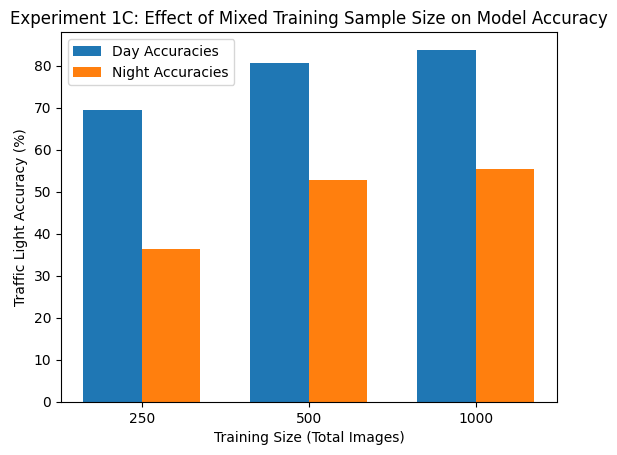

In [2]:
### Plotting results from hardcoded lists
import matplotlib.pyplot as plt

sizes = [250, 500, 1000]
day_accuracies = [69.41, 80.59, 83.77]
night_accuracies = [36.29, 52.70, 55.46]

# Set up the figure and axis
fig, ax1 = plt.subplots()

# Bar width
bar_width = 0.35

# Set the positions of bars on X-axis
bar_positions_day = range(len(sizes))
bar_positions_night = [pos + bar_width for pos in bar_positions_day]

# Create bars for day_accuracies
ax1.bar(bar_positions_day, day_accuracies, width=bar_width, label='Day Accuracies')

# Create bars for night_accuracies
ax1.bar(bar_positions_night, night_accuracies, width=bar_width, label='Night Accuracies')

# Set the x-axis ticks and labels
ax1.set_xticks([pos + bar_width / 2 for pos in bar_positions_day])
ax1.set_xticklabels(sizes)

# Set labels and title
ax1.set_xlabel('Training Size (Total Images)')
ax1.set_ylabel('Traffic Light Accuracy (%)')
ax1.set_title('Experiment 1C: Effect of Mixed Training Sample Size on Model Accuracy')

# Show legend for the primary axis
ax1.legend(loc='upper left')

plt.savefig('Figures/Experiment1_MixedTrainingSizeResults.png', dpi=400)

# Show the plot
%matplotlib inline
plt.show()

